In [15]:
from Imports import *
from Plotting import *
from Helper import *
from Preprocessing import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
jet_images_path = '../data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_images_path, 'r')

print(jet_mass_data.keys())
print(jet_mass_data['image'].shape)

<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
(872666, 25, 25)


In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        self.noise = GaussianNoise(sigma=0.2)

        self.feature_gen = nn.Sequential(
            nn.Linear(9, 256),
            nn.LayerNorm(256),
            self.noise
        )

        self.image_gen1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 1x1 → 2x2
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2x2 → 4x4
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 4x4 → 8x8
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        self.image_gen4 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 8x8 → 16x16
            nn.Sigmoid()
        )

    def forward(self, z_feat):
        img = self.feature_gen(z_feat)
        # print(img.shape)
        img = img.view(-1, 256, 1, 1)
        # print(img.shape)
        img = self.image_gen1(img)
        # print(img.shape)
        img = self.image_gen2(img)
        # print(img.shape)
        img = self.image_gen3(img)
        # print(img.shape)
        img = self.image_gen4(img)
        # print(img.shape)
        img = soft_threshold(img, threshold=0.001, sharpness=1000.0)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Flattened image: 16x16 = 256
        self.image_encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Flatten()
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
        )

        # Dynamically get input dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 16, 16)
            flat_dim = self.image_encoder(dummy).shape[1] + 64

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, img, features):
        img_encoded = self.image_encoder(img)
        feat_encoded = self.feature_encoder(features)
        combined = torch.cat((img_encoded, feat_encoded), dim=1)

        # print(img_encoded.shape)
        # print(feat_encoded.shape)
        # print(combined.shape[-1])

        prob = self.classifier(combined)

        return prob  # Shape: (batch_size, 1)

Image shape: torch.Size([872666, 16, 16])
dR Mean: torch.Size([872666])
dR STD: torch.Size([872666])
Pixel Mean: torch.Size([872666])
Pixel STD: torch.Size([872666])
ΔR min: 0.0
ΔR max: 2.4713454246520996
ΔR mean min: 0.003572926390916109
ΔR mean max: 0.015763528645038605
ΔR std min: 0.017520317807793617
ΔR std max: 0.16022197902202606
Weights (pixel intensity) min: 0.0
Weights (pixel intensity) max: 1.0
Pixel mean min: 0.0028264394495636225
Pixel mean max: 0.004322932101786137
Pixel std min: 0.008012386038899422
Pixel std max: 0.06249340996146202


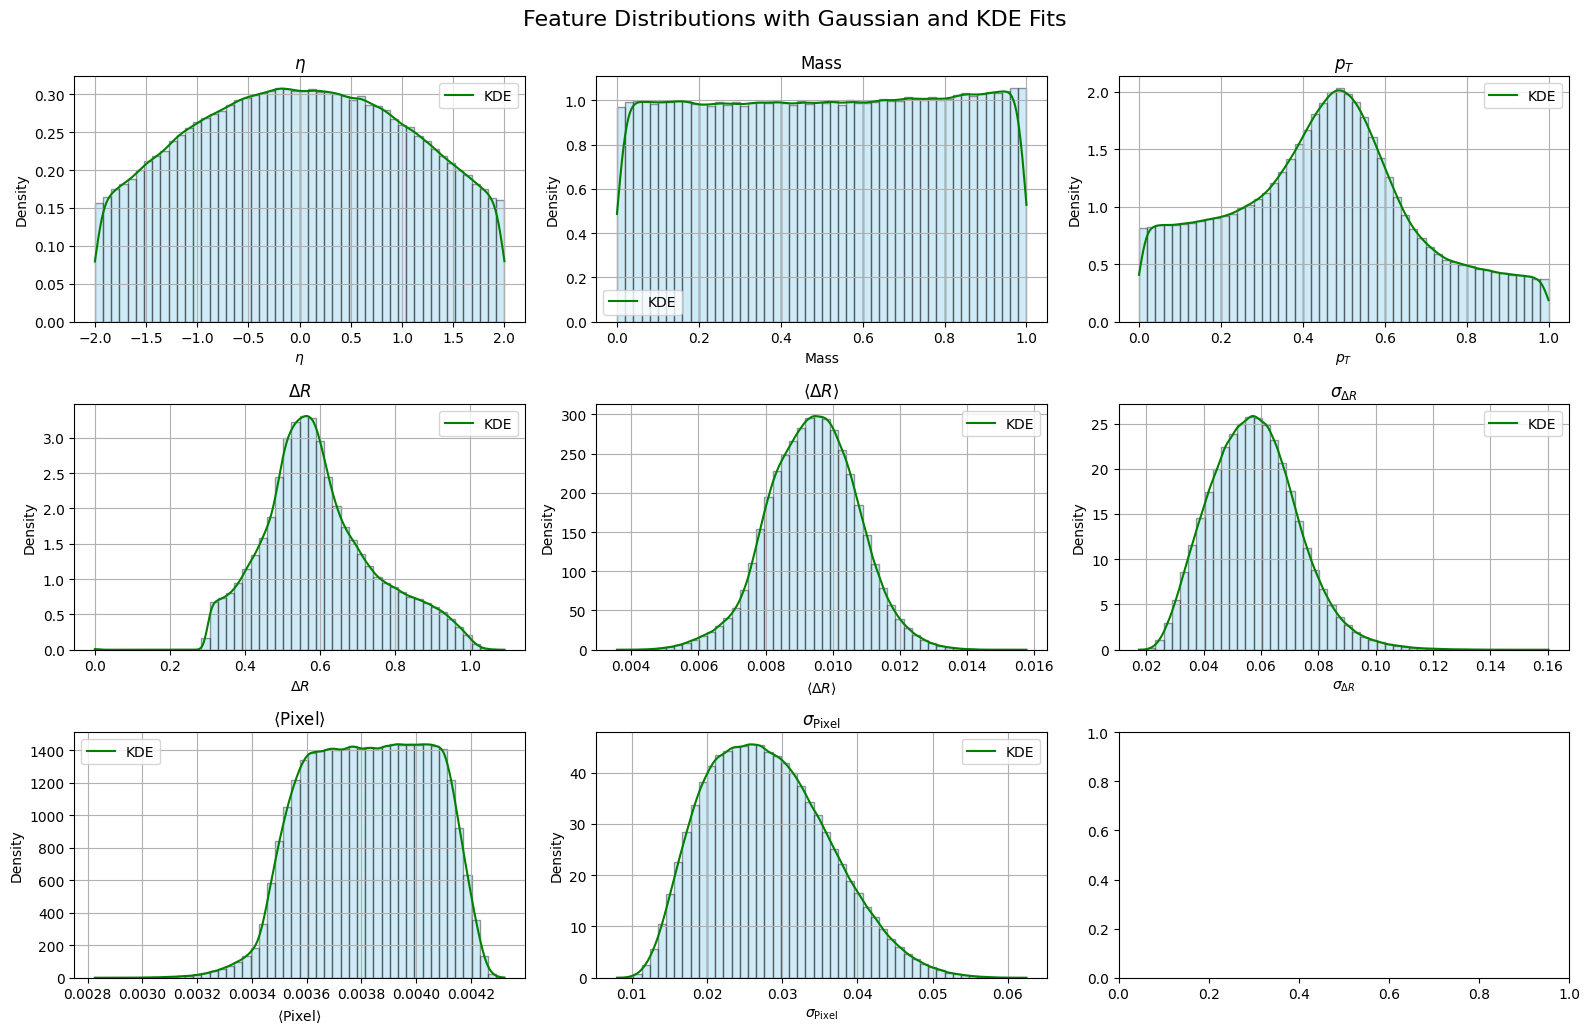

Number of samples: 872666
Image shape: torch.Size([872666, 16, 16])
Feature shape: torch.Size([872666, 9])


In [4]:
batch_size = 128*3
n_events = int(1 * jet_mass_data['image'].shape[0])

dataset = JetDataset(jet_mass_data, n_events)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

kdes = feature_distributions(dataset)

print("Number of samples:", len(dataset))
print("Image shape:", dataset.images.shape)
print("Feature shape:", dataset.features.shape)

In [ ]:
latent_dim = 256
lr = 10e-4
n_epochs = 300
num = 4

generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

g_losses = []
d_losses = []

# Image shape: (16, 16)
H, W = (16, 16)
center_x, center_y = (W - 1) / 2, (H - 1) / 2

# Coordinate grid
x_coords, y_coords = torch.meshgrid(
    torch.arange(W, dtype=torch.float32),
    torch.arange(H, dtype=torch.float32),
    indexing='ij')

# Distance from center
dists = (torch.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)).cuda()
dists = dists.unsqueeze(0)  # [1, 16, 16]

tracked_fake_dR_mean = []
tracked_fake_dR_std = []
tracked_fake_pixel_mean = []
tracked_fake_pixel_std = []

tracked_real_dR_mean = []
tracked_real_dR_std = []
tracked_real_pixel_mean = []
tracked_real_pixel_std = []

In [ ]:
## Load a previous model
# Replace with the desired filename
load_path = "models/class_gan_model_20250712_224355.pt"

# Load the checkpoint
checkpoint = torch.load(load_path)

# Restore model weights
generator.load_state_dict(checkpoint["generator_state_dict"])
discriminator.load_state_dict(checkpoint["discriminator_state_dict"])

# Optionally restore tracking data
g_losses = checkpoint["g_losses"]
d_losses = checkpoint["d_losses"]

tracked_fake_dR_mean = checkpoint["tracked_fake_dR_mean"]
tracked_fake_dR_std = checkpoint["tracked_fake_dR_std"]
tracked_fake_pixel_mean = checkpoint["tracked_fake_pixel_mean"]
tracked_fake_pixel_std = checkpoint["tracked_fake_pixel_std"]

tracked_real_dR_mean = checkpoint["tracked_real_dR_mean"]
tracked_real_dR_std = checkpoint["tracked_real_dR_std"]
tracked_real_pixel_mean = checkpoint["tracked_real_pixel_mean"]
tracked_real_pixel_std = checkpoint["tracked_real_pixel_std"]

print(f"Loaded model from {load_path}")

[Epoch 1/300] [D loss: 0.6625] [G loss: 0.2234] [Validity_loss: 0.0945] 
 [Stat_loss: 0.1024] [NNZ_loss: 0.0265]
Sample feature coding: [ 0.         -1.3790082   0.18083464  0.23922099  0.5823766   0.00660912
  0.03733445  0.00414308  0.02821468]


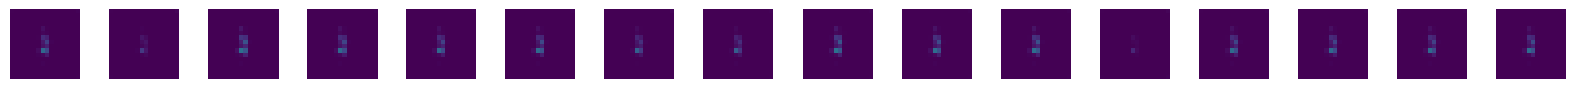

[Epoch 2/300] [D loss: 0.5276] [G loss: 0.2857] [Validity_loss: 0.1556] 
 [Stat_loss: 0.1151] [NNZ_loss: 0.0151]
Sample feature coding: [0.         1.8257043  0.6861523  0.60725796 0.5508882  0.00973692
 0.06127664 0.00340626 0.03142358]


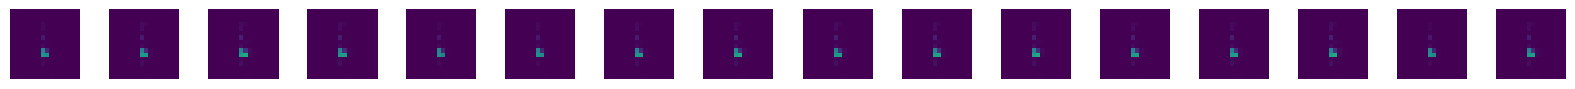

[Epoch 3/300] [D loss: 0.5557] [G loss: 0.2226] [Validity_loss: 0.1205] 
 [Stat_loss: 0.0896] [NNZ_loss: 0.0125]
Sample feature coding: [ 1.         -0.81622666  0.34601554  0.2802857   0.5927161   0.01005119
  0.04981147  0.00410229  0.0134665 ]


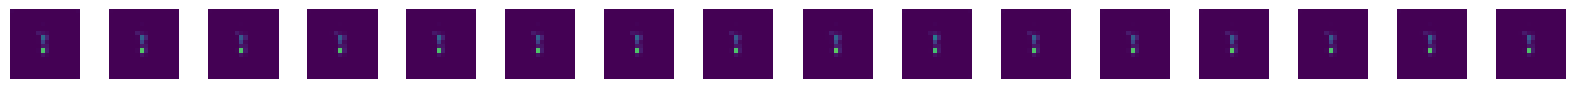

[Epoch 4/300] [D loss: 0.4887] [G loss: 0.2773] [Validity_loss: 0.1769] 
 [Stat_loss: 0.0885] [NNZ_loss: 0.0120]
Sample feature coding: [ 1.         -1.1038541   0.20086737  0.48405367  0.56292284  0.00910941
  0.0618775   0.00365364  0.02178356]


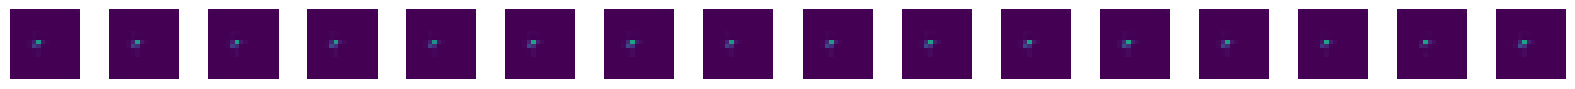

[Epoch 5/300] [D loss: 0.8409] [G loss: 0.3936] [Validity_loss: 0.1874] 
 [Stat_loss: 0.1870] [NNZ_loss: 0.0191]
Sample feature coding: [0.         2.0049632  0.77297944 0.5346272  0.72797525 0.00867705
 0.03324962 0.00398701 0.03065735]


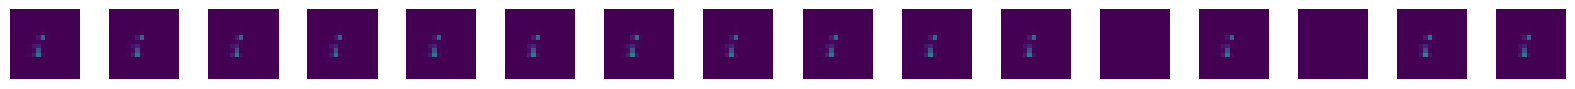

[Epoch 6/300] [D loss: 0.5952] [G loss: 0.3664] [Validity_loss: 0.1450] 
 [Stat_loss: 0.2034] [NNZ_loss: 0.0180]
Sample feature coding: [1.         0.01504345 0.6630104  0.51567477 0.93551147 0.00854833
 0.03470815 0.00387809 0.02200969]


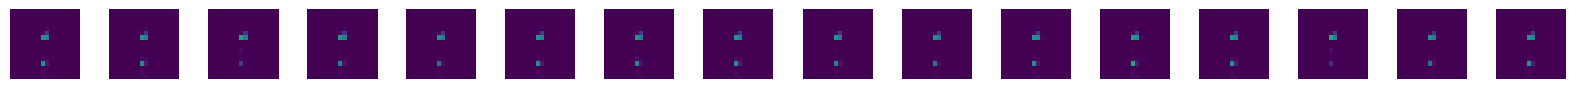

[Epoch 7/300] [D loss: 0.4852] [G loss: 0.2741] [Validity_loss: 0.1760] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0097]
Sample feature coding: [1.         0.27526948 0.64274603 0.7060353  0.5678246  0.00829244
 0.07247055 0.00358259 0.03627411]


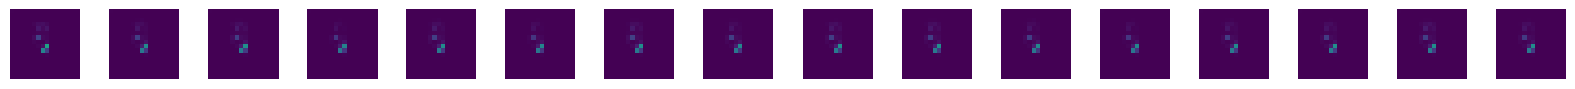

[Epoch 8/300] [D loss: 0.6296] [G loss: 0.2254] [Validity_loss: 0.1276] 
 [Stat_loss: 0.0879] [NNZ_loss: 0.0099]
Sample feature coding: [ 0.         -1.497258    0.832708    0.31270266  0.729001    0.00799433
  0.07522482  0.00399634  0.02836525]


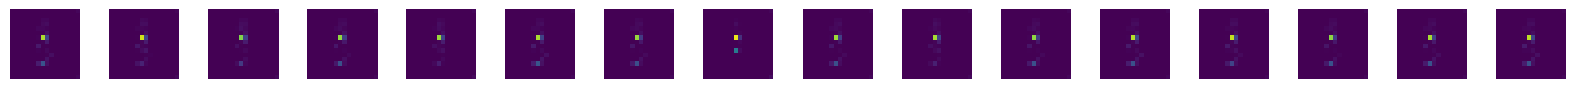

[Epoch 9/300] [D loss: 0.5798] [G loss: 0.3304] [Validity_loss: 0.1325] 
 [Stat_loss: 0.1807] [NNZ_loss: 0.0172]
Sample feature coding: [ 1.         -0.18112336  0.32087392  0.5945144   0.6069851   0.00847348
  0.06205931  0.00350477  0.01975109]


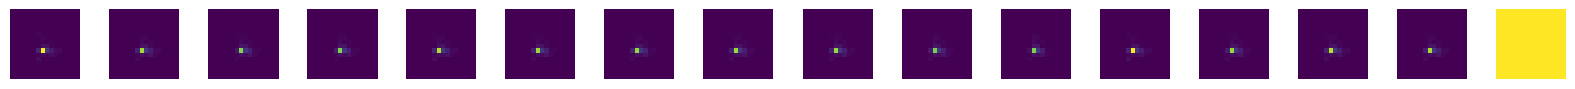

[Epoch 10/300] [D loss: 0.5532] [G loss: 0.2471] [Validity_loss: 0.1482] 
 [Stat_loss: 0.0879] [NNZ_loss: 0.0111]
Sample feature coding: [ 1.         -0.05184587  0.9200628   0.2685887   0.5990839   0.00777723
  0.05430107  0.0040811   0.01803375]


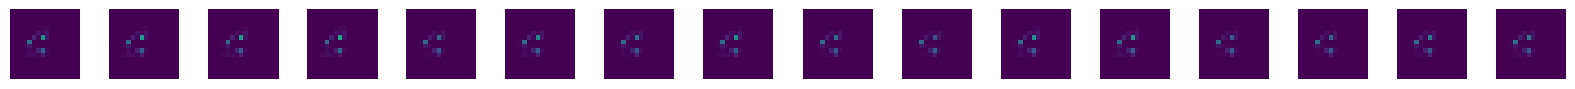

[Epoch 11/300] [D loss: 0.5480] [G loss: 0.6118] [Validity_loss: 0.2023] 
 [Stat_loss: 0.3839] [NNZ_loss: 0.0256]
Sample feature coding: [0.         0.78856426 0.96368927 0.58059776 0.39801127 0.00619045
 0.02891123 0.0034634  0.0440237 ]


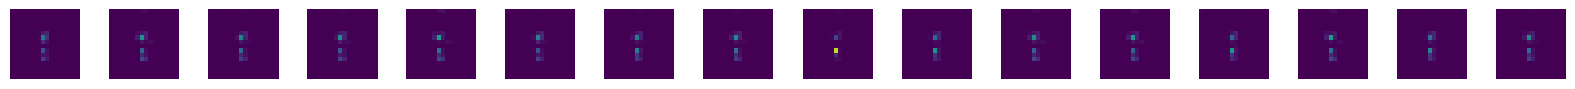

[Epoch 12/300] [D loss: 0.5768] [G loss: 0.2307] [Validity_loss: 0.1273] 
 [Stat_loss: 0.0889] [NNZ_loss: 0.0145]
Sample feature coding: [0.         0.28829923 0.72695655 0.5422546  0.7719476  0.00978834
 0.07919966 0.00373468 0.02792868]


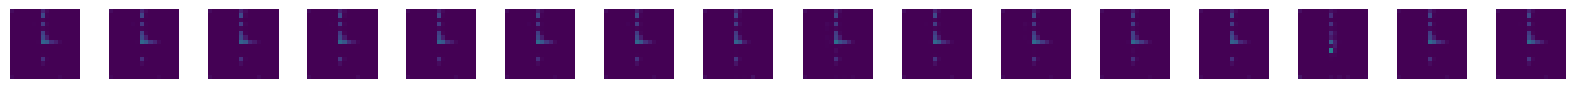

[Epoch 13/300] [D loss: 0.5698] [G loss: 0.3993] [Validity_loss: 0.1439] 
 [Stat_loss: 0.2400] [NNZ_loss: 0.0153]
Sample feature coding: [ 0.         -0.32293278  0.34370387  0.6264434   0.7352151   0.01097535
  0.03198033  0.00380675  0.03073436]


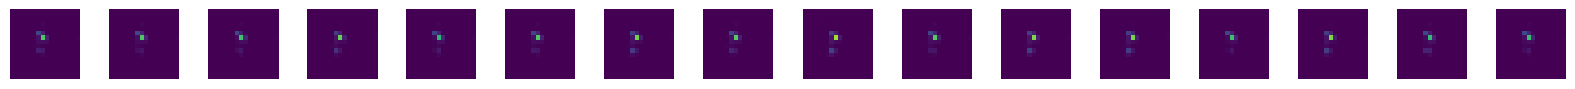

[Epoch 14/300] [D loss: 0.6480] [G loss: 0.2155] [Validity_loss: 0.1167] 
 [Stat_loss: 0.0874] [NNZ_loss: 0.0113]
Sample feature coding: [ 1.         -1.1112114   0.67779255  0.32444558  0.5584419   0.00873932
  0.04203687  0.00419615  0.02180582]


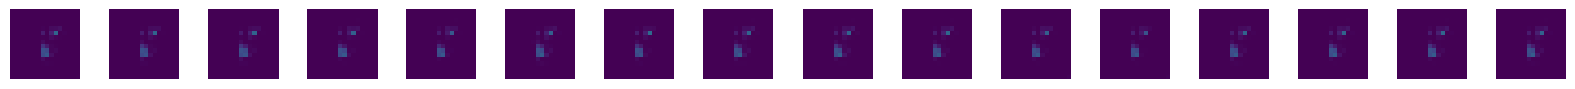

[Epoch 15/300] [D loss: 0.6094] [G loss: 0.4100] [Validity_loss: 0.1407] 
 [Stat_loss: 0.2537] [NNZ_loss: 0.0157]
Sample feature coding: [ 0.         -0.6180935   0.344847    0.8170889   0.5840044   0.00916165
  0.02555052  0.00356202  0.03329165]


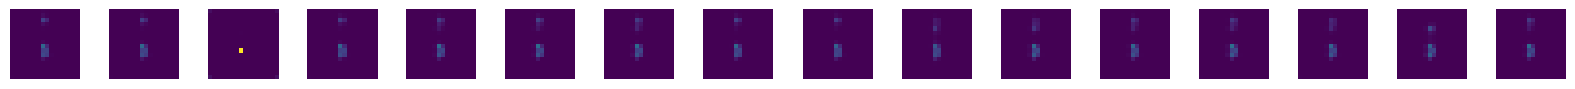

[Epoch 16/300] [D loss: 0.4871] [G loss: 0.3822] [Validity_loss: 0.1626] 
 [Stat_loss: 0.2063] [NNZ_loss: 0.0133]
Sample feature coding: [ 1.         -1.0349119   0.5892841   0.8057331   0.62920237  0.00963439
  0.07116309  0.00375084  0.02484762]


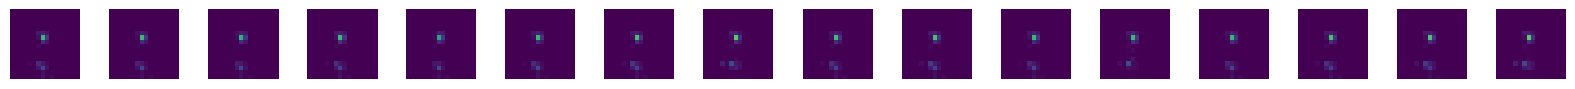

[Epoch 17/300] [D loss: 0.7522] [G loss: 0.2217] [Validity_loss: 0.1234] 
 [Stat_loss: 0.0878] [NNZ_loss: 0.0104]
Sample feature coding: [1.         0.9594749  0.8640366  0.13464539 0.60497755 0.00792459
 0.02828036 0.00399323 0.03069764]


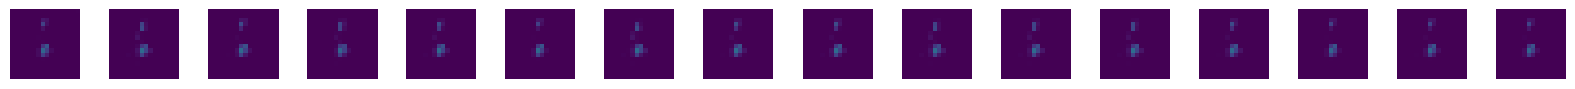

[Epoch 18/300] [D loss: 0.4934] [G loss: 0.2352] [Validity_loss: 0.1366] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0105]
Sample feature coding: [ 0.         -0.7033221   0.13864776  0.4462307   0.5310947   0.00804647
  0.04989836  0.00402829  0.02018319]


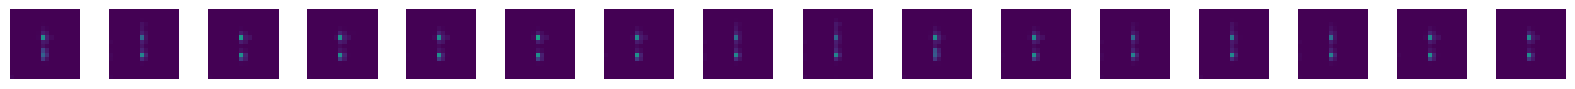

[Epoch 19/300] [D loss: 0.4603] [G loss: 0.2537] [Validity_loss: 0.1549] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0105]
Sample feature coding: [ 1.         -0.6085506   0.7267515   0.23112579  0.72288835  0.00740886
  0.08926845  0.00372028  0.04950639]


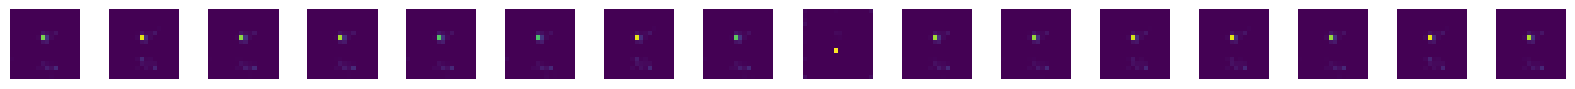

[Epoch 20/300] [D loss: 0.5346] [G loss: 0.3808] [Validity_loss: 0.1529] 
 [Stat_loss: 0.2152] [NNZ_loss: 0.0126]
Sample feature coding: [1.         1.6237186  0.41425228 0.35816124 0.7820458  0.00864175
 0.05974124 0.00360364 0.03089554]


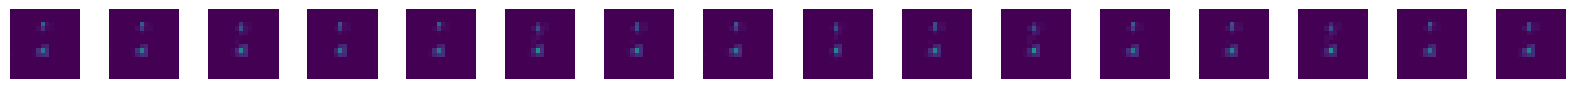

[Epoch 21/300] [D loss: 0.6099] [G loss: 0.2226] [Validity_loss: 0.1235] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0109]
Sample feature coding: [ 1.         -1.9862084   0.6262431   0.83844995  0.32898164  0.01308842
  0.05598569  0.00364879  0.02902313]


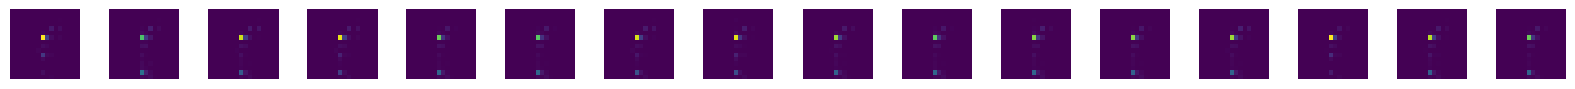

[Epoch 22/300] [D loss: 0.3827] [G loss: 0.2946] [Validity_loss: 0.1955] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0109]
Sample feature coding: [ 0.         -1.7704853   0.18632448  0.58945113  0.67469025  0.01019629
  0.053987    0.00356573  0.03626266]


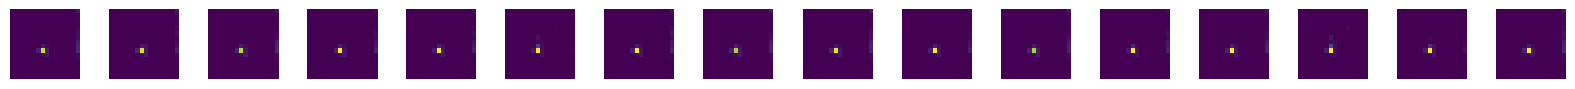

[Epoch 23/300] [D loss: 0.6216] [G loss: 0.2853] [Validity_loss: 0.1797] 
 [Stat_loss: 0.0939] [NNZ_loss: 0.0117]
Sample feature coding: [0.         1.076201   0.45509544 0.8574969  0.66084343 0.00975097
 0.04798516 0.00370322 0.03439032]


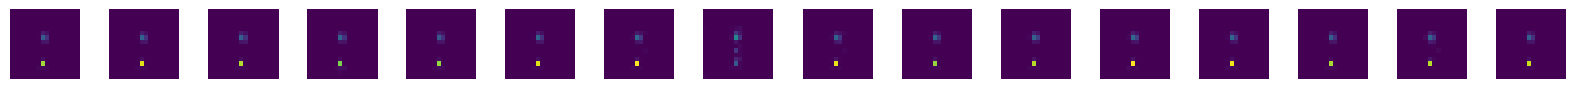

[Epoch 24/300] [D loss: 0.6541] [G loss: 0.2182] [Validity_loss: 0.1193] 
 [Stat_loss: 0.0886] [NNZ_loss: 0.0103]
Sample feature coding: [1.         0.41134727 0.80389625 0.26321414 0.7926451  0.01044232
 0.06786612 0.00402184 0.03206848]


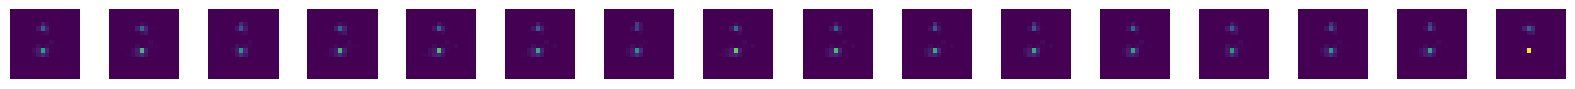

[Epoch 25/300] [D loss: 0.4486] [G loss: 0.2865] [Validity_loss: 0.1874] 
 [Stat_loss: 0.0886] [NNZ_loss: 0.0105]
Sample feature coding: [1.         0.4497629  0.8762369  0.44415647 0.50612205 0.00703308
 0.05500831 0.00412305 0.01975872]


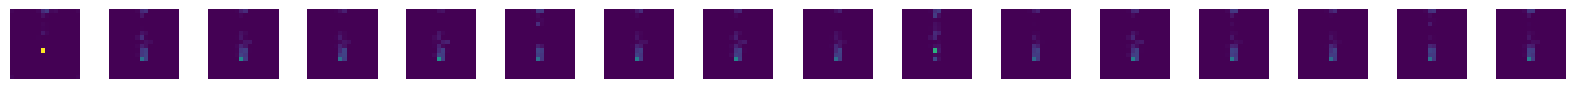

[Epoch 26/300] [D loss: 0.4267] [G loss: 0.4066] [Validity_loss: 0.1829] 
 [Stat_loss: 0.2064] [NNZ_loss: 0.0173]
Sample feature coding: [ 0.         -1.5320349   0.15005678  0.47294644  0.9592634   0.0100144
  0.04622402  0.00383299  0.01531496]


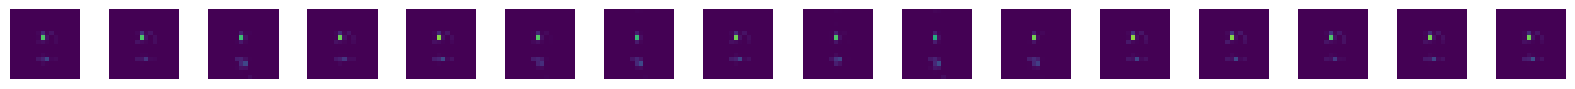

[Epoch 27/300] [D loss: 0.4036] [G loss: 0.2692] [Validity_loss: 0.1701] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0109]
Sample feature coding: [1.         1.321446   0.4496647  0.02289228 0.6984233  0.01003976
 0.03782507 0.00350414 0.04234846]


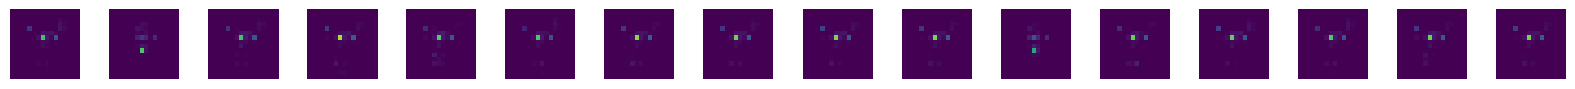

[Epoch 28/300] [D loss: 0.4425] [G loss: 0.3769] [Validity_loss: 0.1735] 
 [Stat_loss: 0.1853] [NNZ_loss: 0.0180]
Sample feature coding: [1.         0.7648602  0.5583809  0.6908402  0.9954028  0.01131156
 0.06738313 0.00355033 0.03567002]


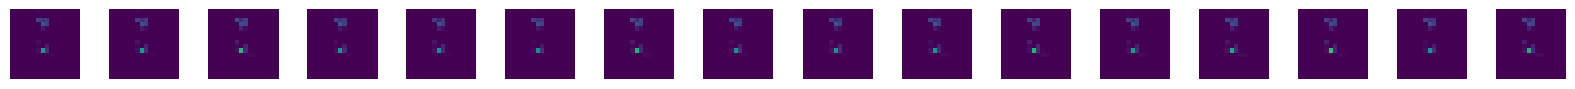

[Epoch 29/300] [D loss: 0.4831] [G loss: 0.2534] [Validity_loss: 0.1550] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0102]
Sample feature coding: [ 0.         -0.56294554  0.40170845  0.281767    0.8150073   0.00814879
  0.11500914  0.00374202  0.03177483]


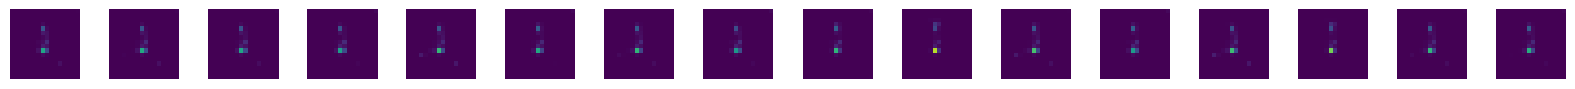

[Epoch 30/300] [D loss: 0.5434] [G loss: 0.2284] [Validity_loss: 0.1292] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0108]
Sample feature coding: [1.         0.43401513 0.8861193  0.49295375 0.5017677  0.01044118
 0.03756581 0.00353834 0.02642372]


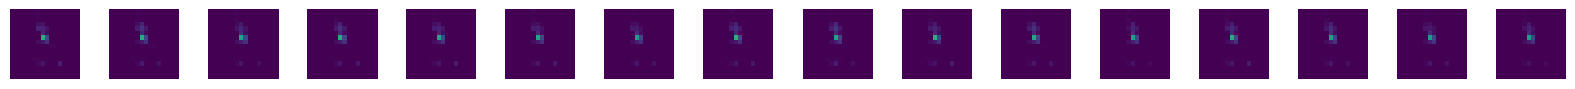

[Epoch 31/300] [D loss: 0.3821] [G loss: 0.2726] [Validity_loss: 0.1727] 
 [Stat_loss: 0.0885] [NNZ_loss: 0.0115]
Sample feature coding: [ 0.         -0.7246894   0.20663011  0.44180593  0.56322175  0.00756701
  0.05338787  0.00388258  0.02943736]


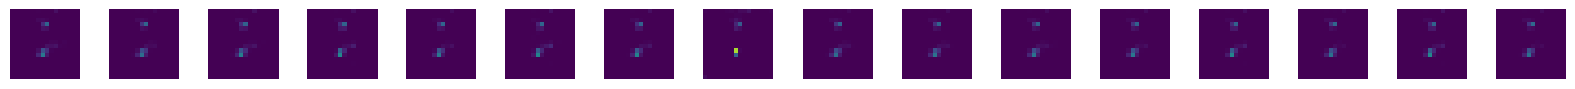

[Epoch 32/300] [D loss: 0.3805] [G loss: 0.2825] [Validity_loss: 0.1835] 
 [Stat_loss: 0.0874] [NNZ_loss: 0.0116]
Sample feature coding: [ 1.         -1.5522878   0.6585534   0.38517097  0.61949956  0.00682077
  0.06442448  0.00414638  0.0253591 ]


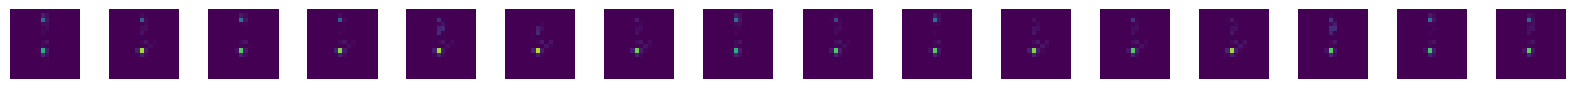

[Epoch 33/300] [D loss: 0.5358] [G loss: 0.2464] [Validity_loss: 0.1473] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0107]
Sample feature coding: [0.         1.0185016  0.6543388  0.85606927 0.6788954  0.00981875
 0.06151121 0.00380103 0.01926818]


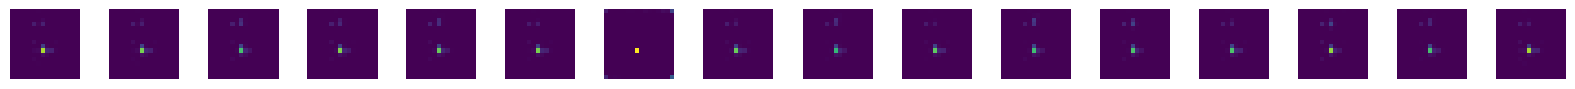

[Epoch 34/300] [D loss: 0.5561] [G loss: 0.4433] [Validity_loss: 0.1670] 
 [Stat_loss: 0.2635] [NNZ_loss: 0.0129]
Sample feature coding: [1.         0.02839116 0.81472075 0.0857242  0.7362776  0.00786277
 0.08213075 0.00352222 0.02956555]


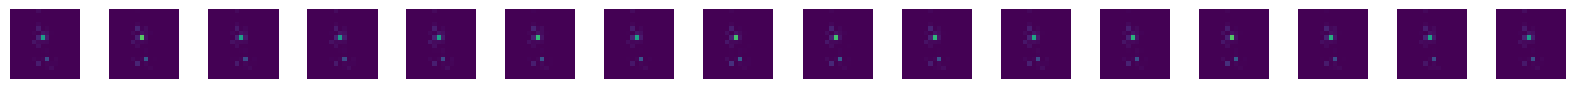

[Epoch 35/300] [D loss: 0.5641] [G loss: 0.2474] [Validity_loss: 0.1488] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0103]
Sample feature coding: [1.         1.4465383  0.9223313  0.44070652 0.39474708 0.01240069
 0.04157904 0.00404408 0.01399583]


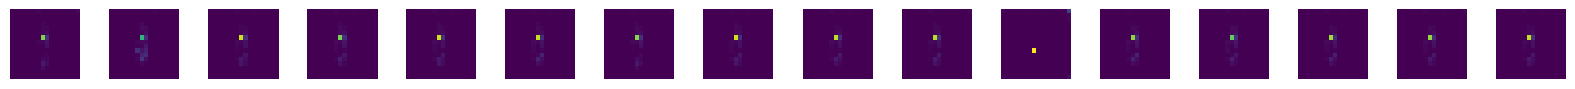

[Epoch 36/300] [D loss: 0.5666] [G loss: 0.2598] [Validity_loss: 0.1548] 
 [Stat_loss: 0.0942] [NNZ_loss: 0.0108]
Sample feature coding: [0.         0.4734866  0.36530933 0.47883388 0.34560615 0.01117329
 0.0417709  0.00373609 0.04119189]


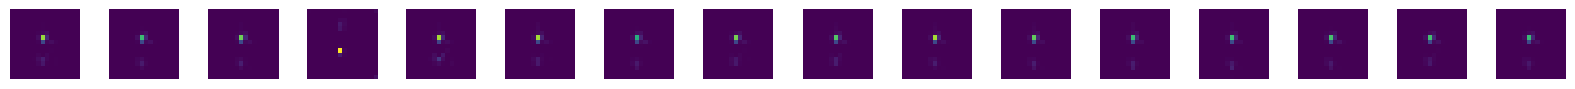

[Epoch 37/300] [D loss: 0.6273] [G loss: 0.3852] [Validity_loss: 0.1329] 
 [Stat_loss: 0.2393] [NNZ_loss: 0.0129]
Sample feature coding: [ 0.         -0.5193721   0.51999     0.08059961  0.5156906   0.00947863
  0.06475415  0.00373502  0.02171699]


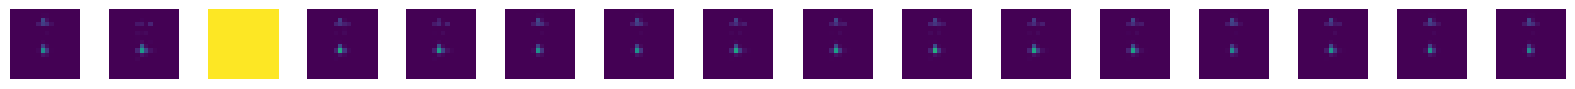

[Epoch 38/300] [D loss: 0.4833] [G loss: 0.2860] [Validity_loss: 0.1774] 
 [Stat_loss: 0.0981] [NNZ_loss: 0.0105]
Sample feature coding: [0.         0.79337823 0.2113791  0.5809656  0.63141614 0.00945843
 0.05953275 0.00360235 0.0312662 ]


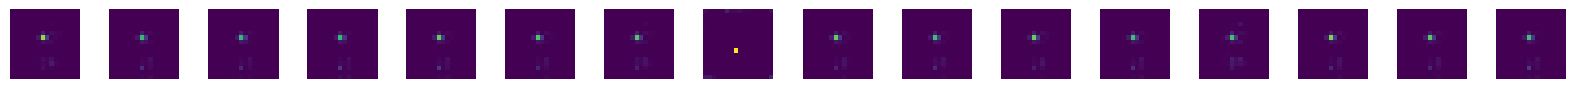

[Epoch 39/300] [D loss: 0.5765] [G loss: 0.2354] [Validity_loss: 0.1359] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0112]
Sample feature coding: [1.         0.7730347  0.12133531 0.1372162  0.51148605 0.00895631
 0.06888141 0.00384344 0.0246029 ]


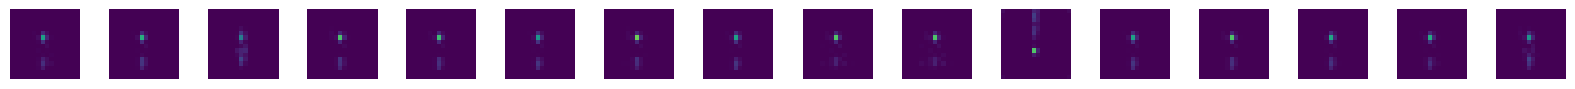

[Epoch 40/300] [D loss: 0.5309] [G loss: 0.2596] [Validity_loss: 0.1603] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0108]
Sample feature coding: [ 0.         -1.9367502   0.56405175  0.48399022  0.77880317  0.0099459
  0.05506953  0.00384995  0.03938681]


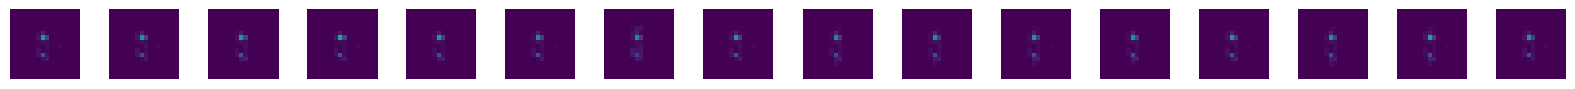

[Epoch 41/300] [D loss: 0.5054] [G loss: 0.3953] [Validity_loss: 0.1648] 
 [Stat_loss: 0.2137] [NNZ_loss: 0.0169]
Sample feature coding: [ 0.         -1.755129    0.9202618   0.5279466   0.6592048   0.00927331
  0.03892865  0.00415599  0.02972807]


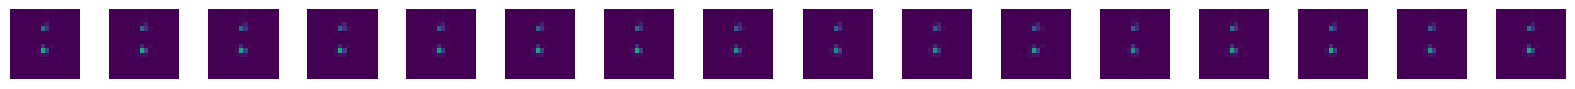

[Epoch 42/300] [D loss: 0.4677] [G loss: 0.2651] [Validity_loss: 0.1654] 
 [Stat_loss: 0.0880] [NNZ_loss: 0.0116]
Sample feature coding: [0.         1.6706158  0.8980481  0.7362173  0.9110382  0.00654614
 0.03952922 0.00399517 0.03185285]


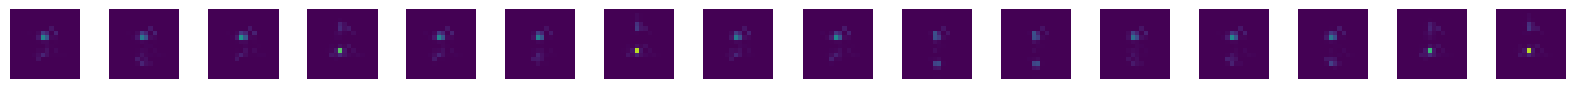

[Epoch 43/300] [D loss: 0.4698] [G loss: 0.2622] [Validity_loss: 0.1607] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0132]
Sample feature coding: [1.         0.8761412  0.5811776  0.5871477  0.47882852 0.00976956
 0.06823207 0.0034853  0.02231332]


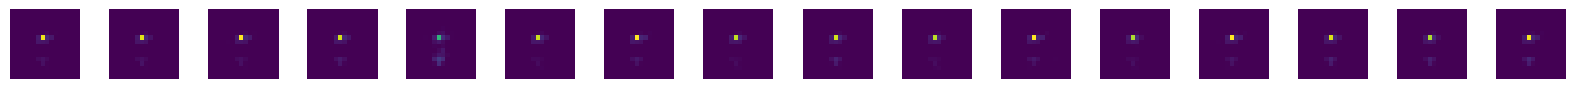

[Epoch 44/300] [D loss: 0.5119] [G loss: 0.2679] [Validity_loss: 0.1694] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0104]
Sample feature coding: [0.         0.68824106 0.345058   0.57822675 0.7946305  0.01042144
 0.04265317 0.00386255 0.03857344]


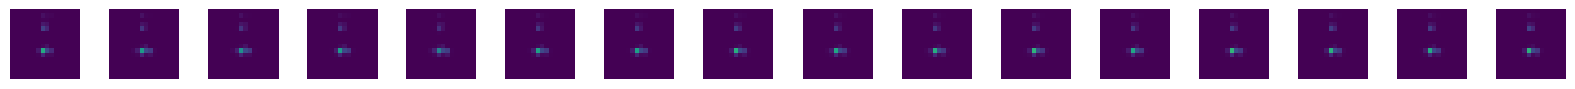

[Epoch 45/300] [D loss: 0.6062] [G loss: 0.2734] [Validity_loss: 0.1737] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0113]
Sample feature coding: [ 0.         -1.5161521   0.70182914  0.47246084  0.9432205   0.00961877
  0.06154426  0.00396022  0.03654136]


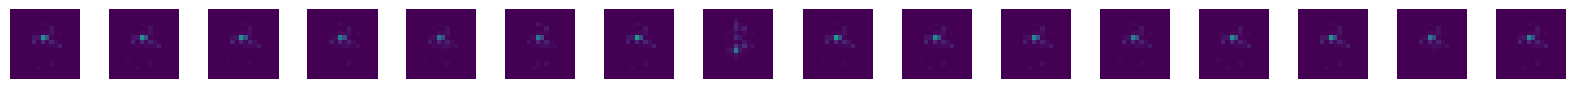

[Epoch 46/300] [D loss: 0.4959] [G loss: 0.2704] [Validity_loss: 0.1713] 
 [Stat_loss: 0.0885] [NNZ_loss: 0.0106]
Sample feature coding: [1.         0.80819994 0.22681785 0.4966217  0.43803006 0.00901
 0.07719243 0.00408088 0.04135347]


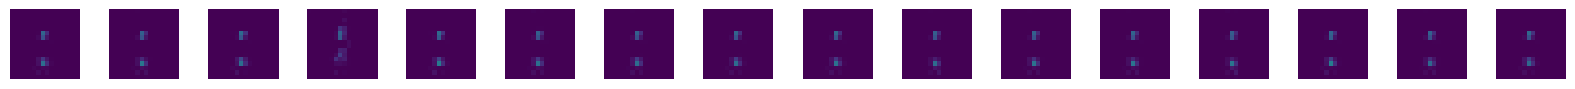

[Epoch 47/300] [D loss: 0.5790] [G loss: 0.2464] [Validity_loss: 0.1474] 
 [Stat_loss: 0.0880] [NNZ_loss: 0.0109]
Sample feature coding: [ 0.         -0.69798917  0.4916216   0.5948279   0.4855805   0.00594404
  0.06974909  0.00372154  0.0220483 ]


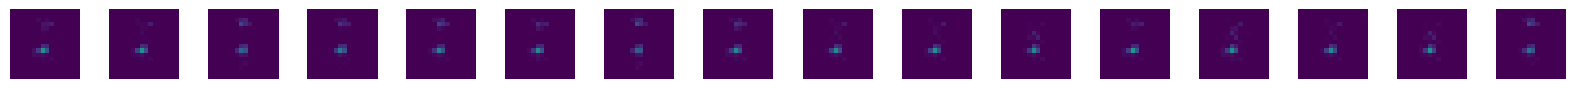

[Epoch 48/300] [D loss: 0.3466] [G loss: 0.2929] [Validity_loss: 0.1872] 
 [Stat_loss: 0.0933] [NNZ_loss: 0.0124]
Sample feature coding: [ 1.         -1.5292405   0.97816306  0.1282892   0.58653504  0.01213
  0.04153338  0.00402302  0.03434208]


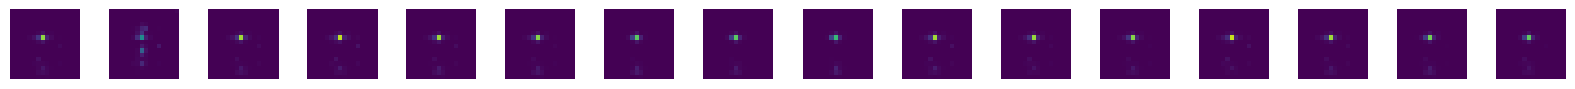

[Epoch 49/300] [D loss: 0.7088] [G loss: 0.2338] [Validity_loss: 0.1344] 
 [Stat_loss: 0.0875] [NNZ_loss: 0.0119]
Sample feature coding: [0.         1.878995   0.72320324 0.6226903  0.47802097 0.00823001
 0.04289155 0.00417541 0.03540606]


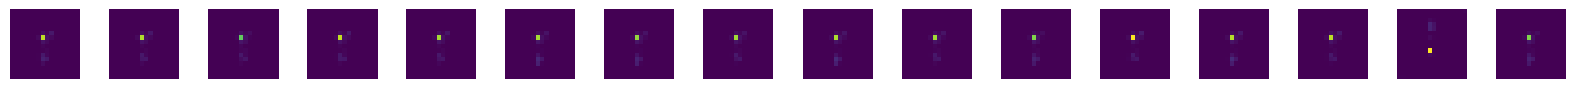

[Epoch 50/300] [D loss: 0.5318] [G loss: 0.3112] [Validity_loss: 0.2110] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0120]
Sample feature coding: [0.         0.9262939  0.14065798 0.42511144 0.73584247 0.00978734
 0.05538741 0.00386496 0.02369266]


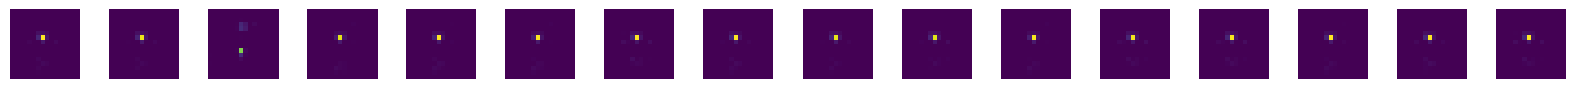

[Epoch 51/300] [D loss: 0.5452] [G loss: 0.2684] [Validity_loss: 0.1688] 
 [Stat_loss: 0.0886] [NNZ_loss: 0.0110]
Sample feature coding: [1.         1.217298   0.07735965 0.36182168 0.40798846 0.00962287
 0.04157064 0.0036346  0.02680696]


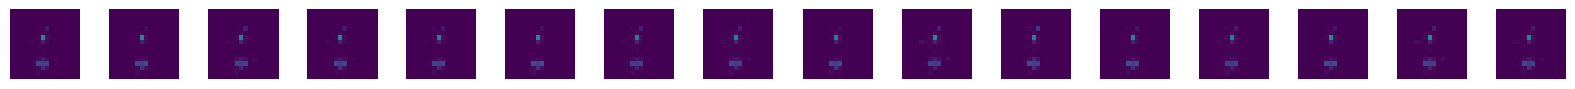

[Epoch 52/300] [D loss: 0.4617] [G loss: 0.2531] [Validity_loss: 0.1553] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0095]
Sample feature coding: [ 0.         -0.15731245  0.19340993  0.43431944  0.5122061   0.00898344
  0.07237073  0.00370134  0.0248607 ]


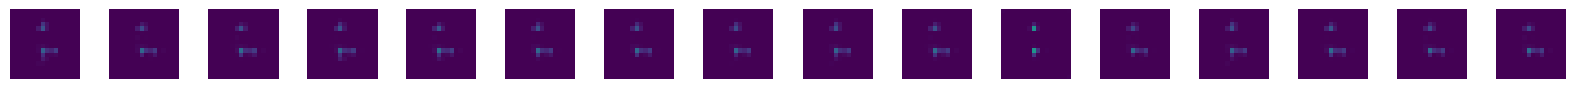

[Epoch 53/300] [D loss: 0.4888] [G loss: 0.2441] [Validity_loss: 0.1448] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0110]
Sample feature coding: [1.         1.6757884  0.48436138 0.16975974 0.9013061  0.00993002
 0.06190271 0.00399242 0.03330214]


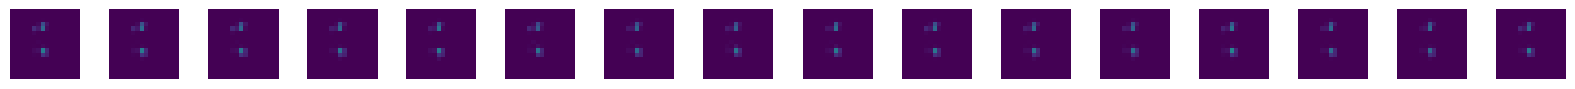

[Epoch 54/300] [D loss: 0.4526] [G loss: 0.2634] [Validity_loss: 0.1633] 
 [Stat_loss: 0.0880] [NNZ_loss: 0.0122]
Sample feature coding: [ 0.         -0.9429843   0.13509561  0.38069522  0.50282055  0.00829863
  0.06316765  0.00409831  0.0322276 ]


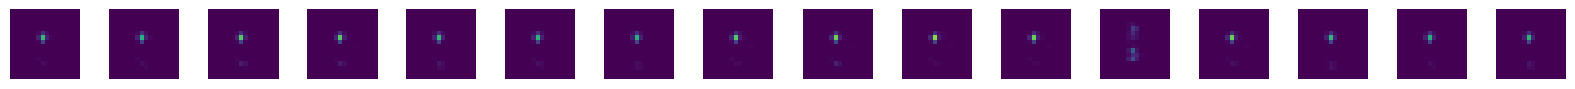

[Epoch 55/300] [D loss: 0.5140] [G loss: 0.4447] [Validity_loss: 0.1825] 
 [Stat_loss: 0.2494] [NNZ_loss: 0.0128]
Sample feature coding: [ 0.         -1.246836    0.3105385   0.22754025  0.5124581   0.00870831
  0.04854954  0.00361745  0.02725816]


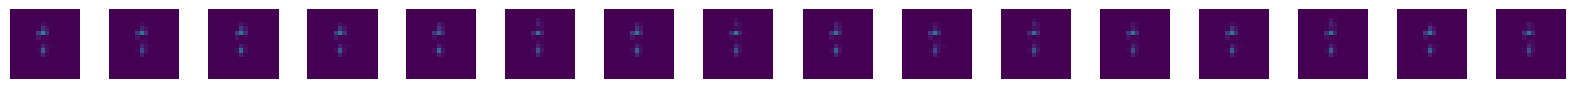

[Epoch 56/300] [D loss: 0.4985] [G loss: 0.2619] [Validity_loss: 0.1627] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0108]
Sample feature coding: [1.         0.71199524 1.0285916  0.7933114  0.4040411  0.00908376
 0.08428477 0.00398729 0.03151689]


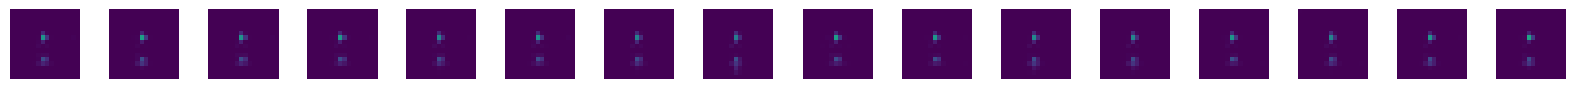

[Epoch 57/300] [D loss: 0.4642] [G loss: 0.2460] [Validity_loss: 0.1481] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0096]
Sample feature coding: [ 1.         -1.9857213   0.55736226  0.2846941   0.6654123   0.01038616
  0.05056994  0.00396758  0.02494973]


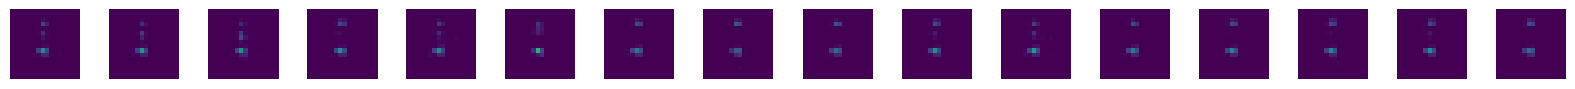

[Epoch 58/300] [D loss: 0.5040] [G loss: 0.2738] [Validity_loss: 0.1750] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0105]
Sample feature coding: [ 0.         -1.1786938   0.7758285   0.06993697  0.7501018   0.01078868
  0.03980965  0.00391472  0.03451062]


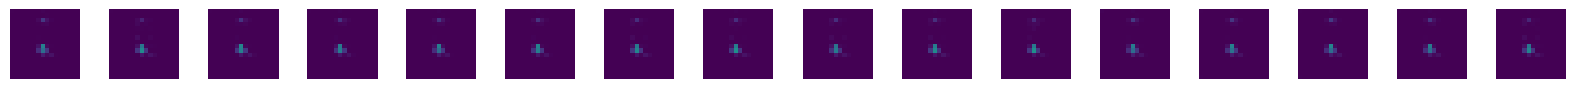

[Epoch 59/300] [D loss: 0.4566] [G loss: 0.2471] [Validity_loss: 0.1475] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0115]
Sample feature coding: [0.         2.0235884  0.984666   0.42886192 0.6440447  0.00652317
 0.04060904 0.00402263 0.02327833]


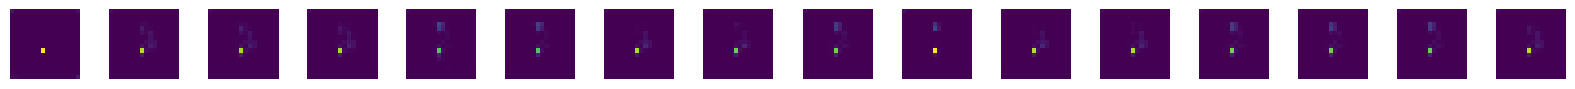

[Epoch 60/300] [D loss: 0.4286] [G loss: 0.2699] [Validity_loss: 0.1713] 
 [Stat_loss: 0.0878] [NNZ_loss: 0.0108]
Sample feature coding: [0.         0.26329973 0.45616916 0.27016032 0.41480133 0.00860851
 0.05697051 0.0031337  0.03352799]


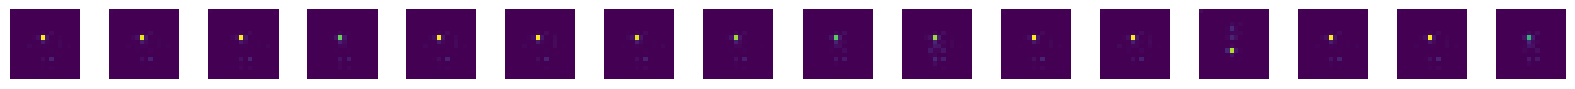

[Epoch 61/300] [D loss: 0.5363] [G loss: 0.2546] [Validity_loss: 0.1547] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0117]
Sample feature coding: [1.         1.0156857  0.44720381 0.29549605 0.8220417  0.00911083
 0.06100983 0.00361043 0.02846288]


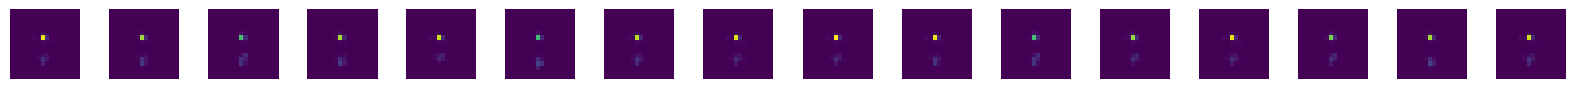

[Epoch 62/300] [D loss: 0.5191] [G loss: 0.2404] [Validity_loss: 0.1417] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0104]
Sample feature coding: [1.         0.31676847 0.14917308 0.49496484 0.7813622  0.0109507
 0.04856802 0.00379411 0.02825061]


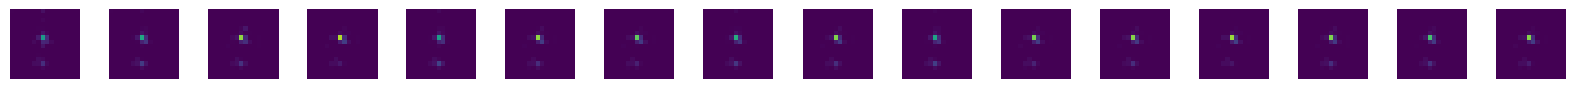

[Epoch 63/300] [D loss: 0.4201] [G loss: 0.2899] [Validity_loss: 0.1880] 
 [Stat_loss: 0.0885] [NNZ_loss: 0.0134]
Sample feature coding: [1.         0.7416957  0.9399843  0.13499461 0.38097265 0.0076232
 0.07410191 0.00385465 0.0168848 ]


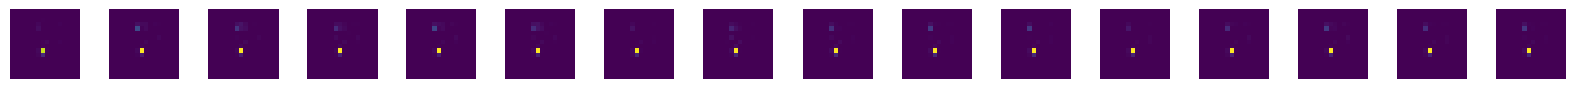

[Epoch 64/300] [D loss: 0.5500] [G loss: 0.2516] [Validity_loss: 0.1535] 
 [Stat_loss: 0.0868] [NNZ_loss: 0.0113]
Sample feature coding: [ 1.         -1.8542345   0.64388484  0.35774526  0.7806715   0.00851065
  0.04276279  0.00358843  0.05111388]


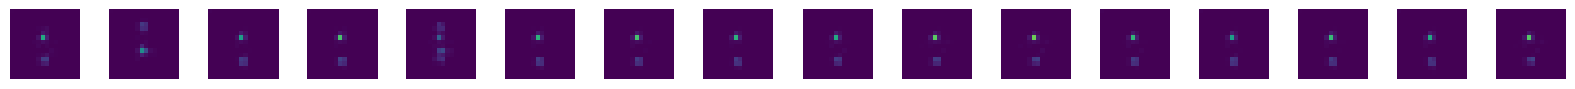

[Epoch 65/300] [D loss: 0.4992] [G loss: 0.2692] [Validity_loss: 0.1700] 
 [Stat_loss: 0.0885] [NNZ_loss: 0.0107]
Sample feature coding: [ 0.         -1.4383453   0.20333035  0.07755292  0.40289345  0.01030495
  0.07689366  0.00420519  0.0181534 ]


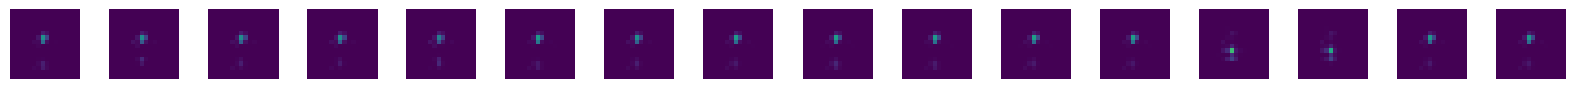

[Epoch 66/300] [D loss: 0.4239] [G loss: 0.2509] [Validity_loss: 0.1513] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0115]
Sample feature coding: [1.         1.5197573  0.78069067 0.42635578 0.7939209  0.00806351
 0.03240093 0.00397826 0.03722117]


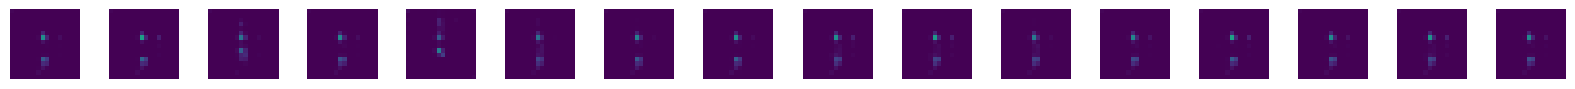

[Epoch 67/300] [D loss: 0.3192] [G loss: 0.2942] [Validity_loss: 0.1939] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0120]
Sample feature coding: [1.         1.5215868  0.7470313  0.35510764 0.6370414  0.00948162
 0.05959426 0.0040831  0.02437101]


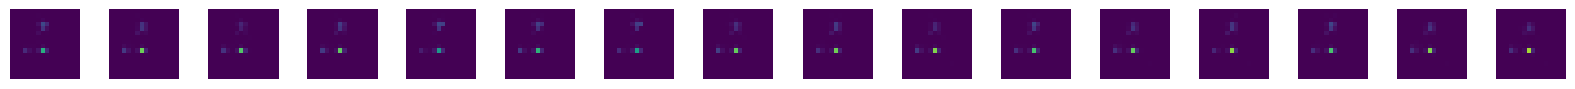

[Epoch 68/300] [D loss: 0.5133] [G loss: 0.2283] [Validity_loss: 0.1290] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0110]
Sample feature coding: [0.         1.9217186  1.0174323  0.9096857  0.58527064 0.00808267
 0.02793154 0.00400284 0.0148477 ]


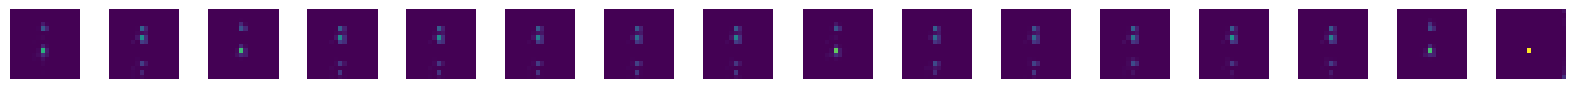

[Epoch 69/300] [D loss: 0.5935] [G loss: 0.2493] [Validity_loss: 0.1497] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0113]
Sample feature coding: [0.         0.9588155  0.50782967 0.37295696 0.5862112  0.00940645
 0.06412353 0.00373043 0.01879516]


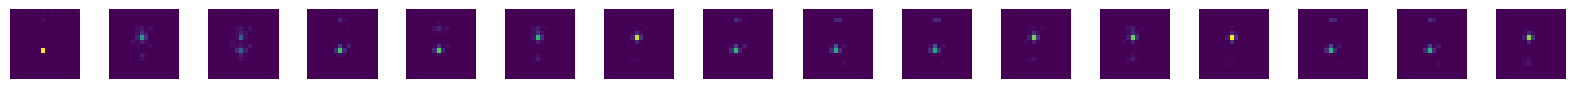

[Epoch 70/300] [D loss: 0.7414] [G loss: 0.2430] [Validity_loss: 0.1444] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0102]
Sample feature coding: [1.         0.23211448 0.8879276  0.120022   0.40986997 0.0118494
 0.03765279 0.00408146 0.01501612]


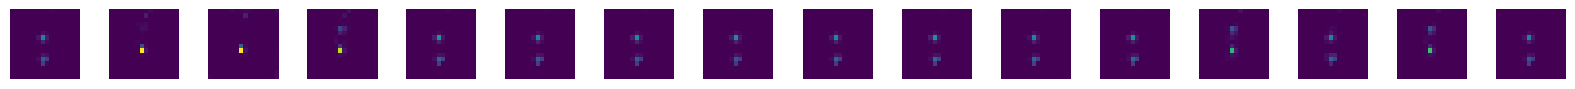

[Epoch 71/300] [D loss: 0.5181] [G loss: 0.2638] [Validity_loss: 0.1655] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0101]
Sample feature coding: [1.         0.75326157 0.27597228 0.38331816 0.5324395  0.01093271
 0.04183241 0.00356709 0.03484838]


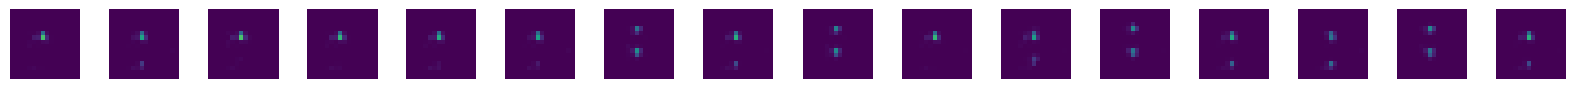

[Epoch 72/300] [D loss: 0.6217] [G loss: 0.2195] [Validity_loss: 0.1211] 
 [Stat_loss: 0.0879] [NNZ_loss: 0.0105]
Sample feature coding: [ 1.         -0.44028407  0.6128593   0.6294194   0.7043173   0.00837579
  0.07178941  0.00387356  0.0369892 ]


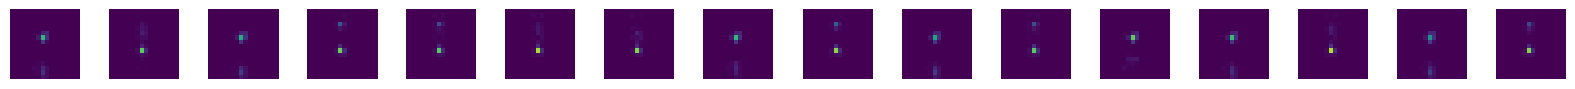

[Epoch 73/300] [D loss: 0.5323] [G loss: 0.2555] [Validity_loss: 0.1561] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0111]
Sample feature coding: [0.         0.23332115 0.516888   0.04603819 0.5235321  0.0098219
 0.04182913 0.00368277 0.04025373]


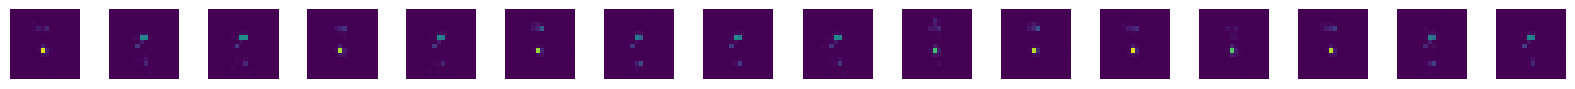

[Epoch 74/300] [D loss: 0.6314] [G loss: 0.2329] [Validity_loss: 0.1339] 
 [Stat_loss: 0.0880] [NNZ_loss: 0.0110]
Sample feature coding: [ 1.         -0.7491028   0.1554977   0.39901468  0.60512924  0.01004283
  0.05103216  0.00396233  0.02472297]


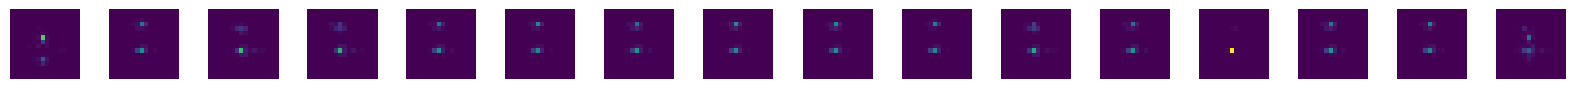

[Epoch 75/300] [D loss: 0.6566] [G loss: 0.2362] [Validity_loss: 0.1355] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0124]
Sample feature coding: [ 0.         -0.54460204  0.02380594  0.46557802  0.70276207  0.01015619
  0.07464916  0.00379812  0.03524292]


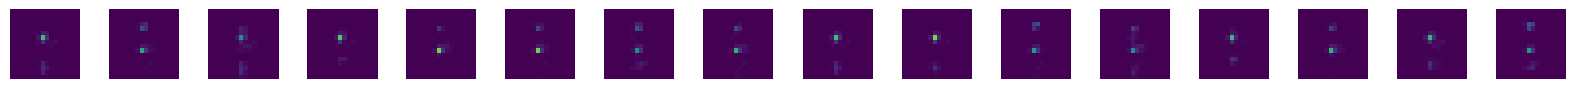

[Epoch 76/300] [D loss: 0.6607] [G loss: 0.2281] [Validity_loss: 0.1297] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0101]
Sample feature coding: [1.         0.5562985  0.2642822  0.00298162 0.57911205 0.00919572
 0.08423876 0.00420083 0.02795809]


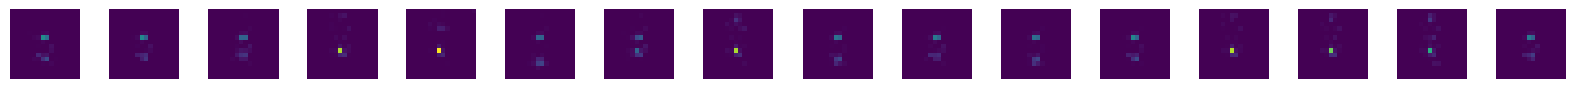

[Epoch 77/300] [D loss: 0.5743] [G loss: 0.2405] [Validity_loss: 0.1407] 
 [Stat_loss: 0.0885] [NNZ_loss: 0.0113]
Sample feature coding: [ 1.         -0.92937005  0.68823856  0.56956196  0.64584273  0.00998349
  0.04192067  0.00357693  0.02598239]


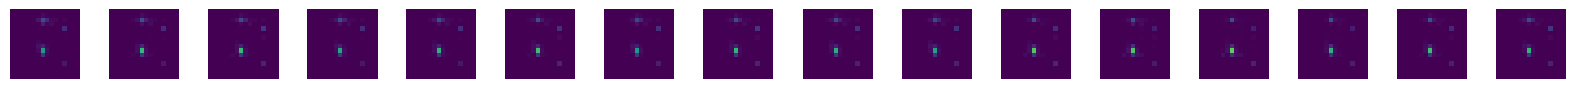

[Epoch 78/300] [D loss: 0.5186] [G loss: 0.2660] [Validity_loss: 0.1656] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0121]
Sample feature coding: [ 0.         -1.8624309   0.0177818   0.11935108  0.5599239   0.01138407
  0.03731075  0.00391471  0.03023553]


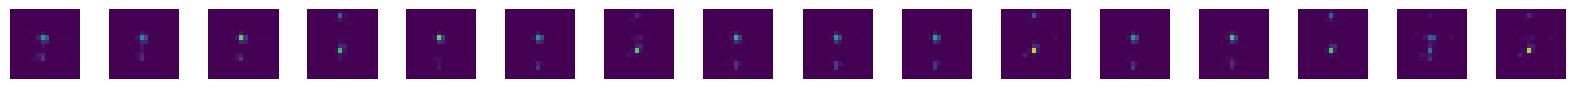

[Epoch 79/300] [D loss: 0.6208] [G loss: 0.2258] [Validity_loss: 0.1258] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0116]
Sample feature coding: [ 1.         -1.2684147   0.13605312  1.0003326   0.77049184  0.01108056
  0.0547849   0.00377233  0.0407623 ]


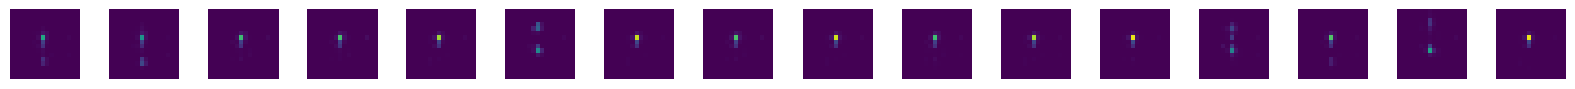

[Epoch 80/300] [D loss: 0.5412] [G loss: 0.3000] [Validity_loss: 0.1898] 
 [Stat_loss: 0.0979] [NNZ_loss: 0.0123]
Sample feature coding: [ 0.         -0.4577637   0.9304857   0.73099333  0.5792068   0.0104588
  0.06010046  0.00404621  0.03425169]


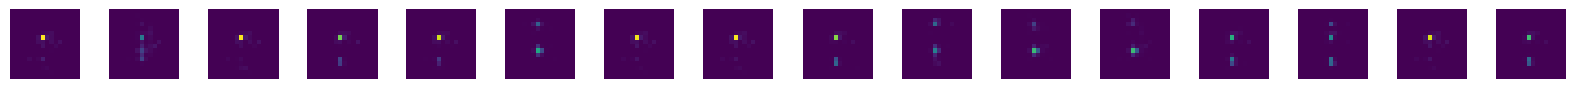

[Epoch 81/300] [D loss: 0.6327] [G loss: 0.2920] [Validity_loss: 0.1927] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0109]
Sample feature coding: [ 1.         -1.5818714   0.48986727  0.64750504  0.61337173  0.00763918
  0.06030352  0.00414686  0.02778961]


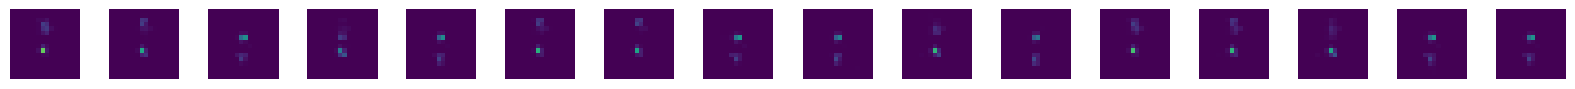

[Epoch 82/300] [D loss: 0.6375] [G loss: 0.2326] [Validity_loss: 0.1330] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0114]
Sample feature coding: [ 1.         -0.8213028   0.88746136  0.00431373  0.6922379   0.00999022
  0.06402483  0.00387845  0.01703133]


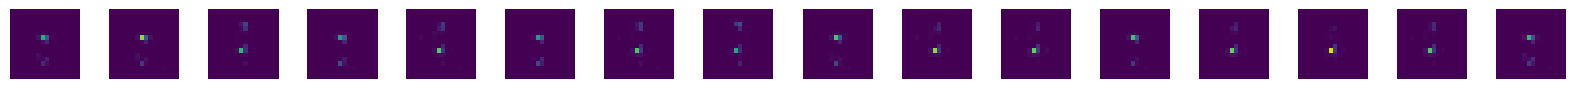

[Epoch 83/300] [D loss: 0.5938] [G loss: 0.2392] [Validity_loss: 0.1395] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0114]
Sample feature coding: [0.         0.7007276  0.10787576 0.61356145 0.6872233  0.00927416
 0.07912532 0.00361889 0.01712053]


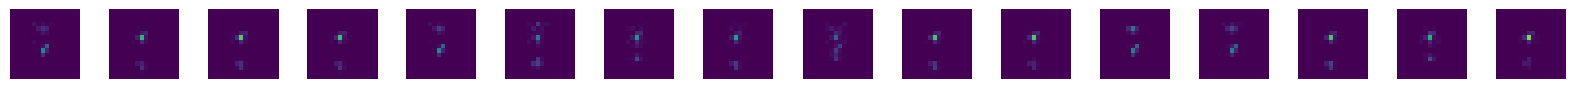

[Epoch 84/300] [D loss: 0.5522] [G loss: 0.2585] [Validity_loss: 0.1588] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0114]
Sample feature coding: [0.         0.4022324  0.72243065 0.49958953 0.74344605 0.00896719
 0.07501995 0.00351572 0.03677943]


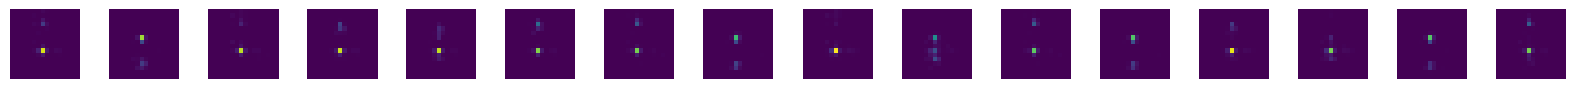

[Epoch 85/300] [D loss: 0.5923] [G loss: 0.2535] [Validity_loss: 0.1535] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0116]
Sample feature coding: [1.         0.46407768 0.7531688  0.39596936 0.71065235 0.01088132
 0.03214891 0.00366081 0.01612079]


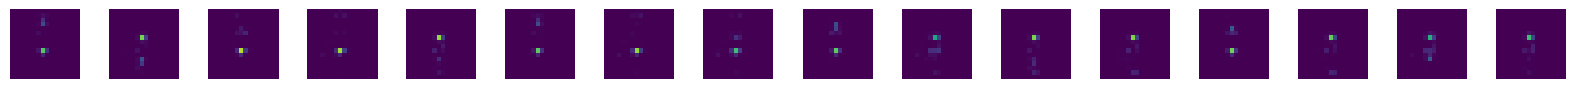

[Epoch 86/300] [D loss: 0.5108] [G loss: 0.4329] [Validity_loss: 0.1707] 
 [Stat_loss: 0.2488] [NNZ_loss: 0.0134]
Sample feature coding: [1.         0.9146918  0.72684234 0.7048828  0.5124215  0.00965809
 0.05698207 0.0039806  0.0207475 ]


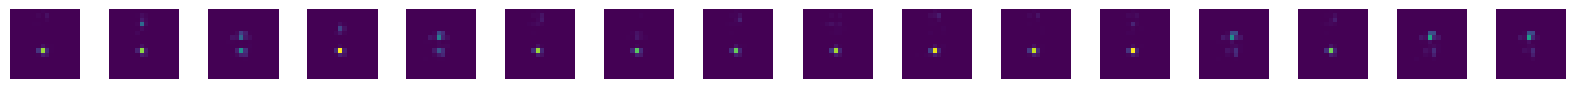

[Epoch 87/300] [D loss: 0.6144] [G loss: 0.2364] [Validity_loss: 0.1354] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0127]
Sample feature coding: [0.         0.10236627 0.923559   0.8714595  0.51619536 0.00930562
 0.05921895 0.00385812 0.01987458]


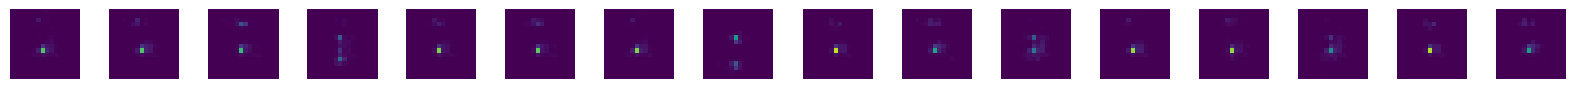

[Epoch 88/300] [D loss: 0.6187] [G loss: 0.2459] [Validity_loss: 0.1459] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0118]
Sample feature coding: [1.         1.0054116  0.8568154  0.5316916  0.6620354  0.00933687
 0.03683821 0.00362881 0.02437942]


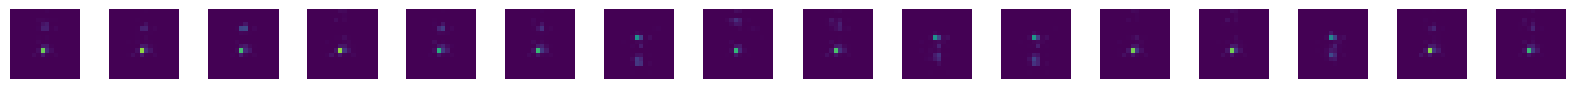

[Epoch 89/300] [D loss: 0.6259] [G loss: 0.2234] [Validity_loss: 0.1245] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0107]
Sample feature coding: [ 0.         -1.2442629   0.45565668  0.36845827  0.60769403  0.00969782
  0.03926386  0.00365557  0.02016862]


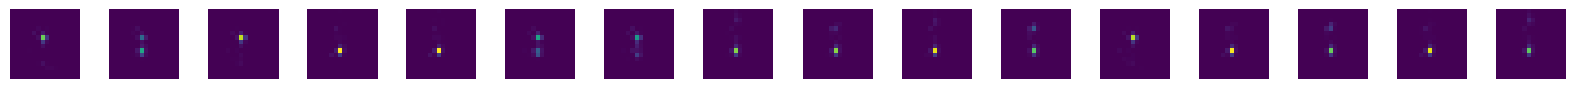

[Epoch 90/300] [D loss: 0.5709] [G loss: 0.3386] [Validity_loss: 0.1515] 
 [Stat_loss: 0.1757] [NNZ_loss: 0.0114]
Sample feature coding: [ 0.         -0.10033123  0.743885    0.48494315  0.5596389   0.00807773
  0.04514908  0.00393325  0.01855697]


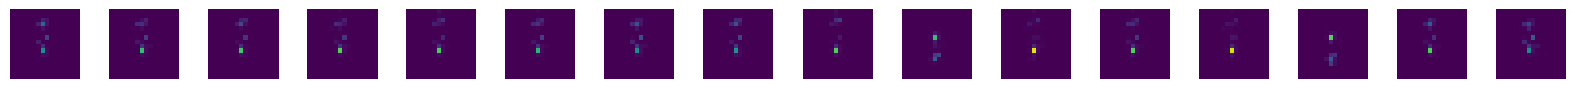

[Epoch 91/300] [D loss: 0.5918] [G loss: 0.2406] [Validity_loss: 0.1409] 
 [Stat_loss: 0.0880] [NNZ_loss: 0.0117]
Sample feature coding: [ 0.         -2.1385486   0.40535226  0.47314835  0.60632527  0.00814391
  0.04331064  0.00386092  0.02370056]


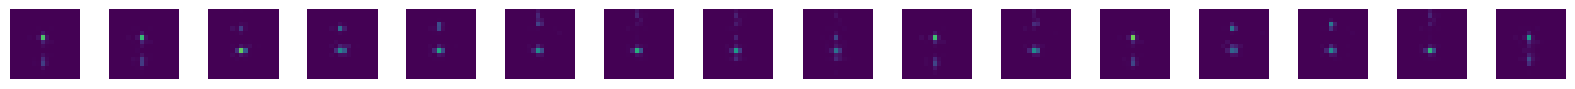

[Epoch 92/300] [D loss: 0.5630] [G loss: 0.2505] [Validity_loss: 0.1459] 
 [Stat_loss: 0.0936] [NNZ_loss: 0.0109]
Sample feature coding: [0.         0.6688882  0.7770818  0.5155956  0.5178373  0.00891387
 0.06063043 0.00419307 0.03400863]


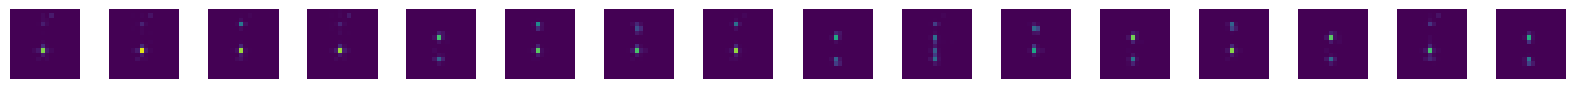

[Epoch 93/300] [D loss: 0.6225] [G loss: 0.2770] [Validity_loss: 0.1769] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0120]
Sample feature coding: [ 1.         -0.54066205  0.61850315  0.583377    0.49094024  0.00859383
  0.05631396  0.00390527  0.02056233]


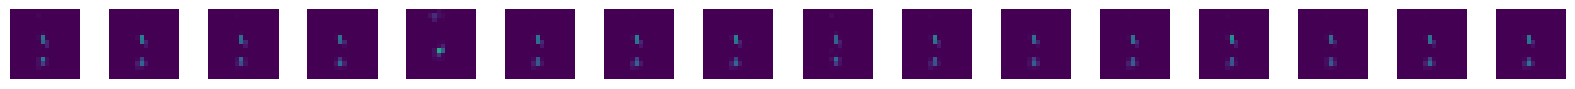

[Epoch 94/300] [D loss: 0.4995] [G loss: 0.2838] [Validity_loss: 0.1807] 
 [Stat_loss: 0.0927] [NNZ_loss: 0.0105]
Sample feature coding: [ 1.         -0.10097706  0.16216221  0.37689257  0.6977894   0.00971325
  0.0336158   0.00362753  0.02526086]


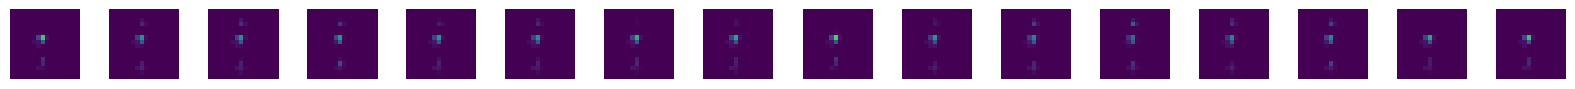

[Epoch 95/300] [D loss: 0.5431] [G loss: 0.2511] [Validity_loss: 0.1520] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0107]
Sample feature coding: [ 1.         -0.57039285  0.77758944  0.7172973   0.526991    0.00910038
  0.0855699   0.00378699  0.02200169]


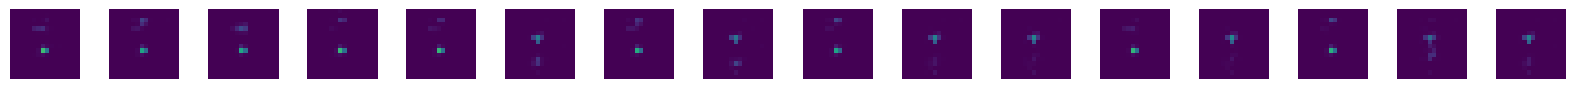

[Epoch 96/300] [D loss: 0.5849] [G loss: 0.2315] [Validity_loss: 0.1311] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0122]
Sample feature coding: [1.         0.44572437 0.12962374 0.60417086 0.42629665 0.00589506
 0.03867494 0.00340065 0.0383077 ]


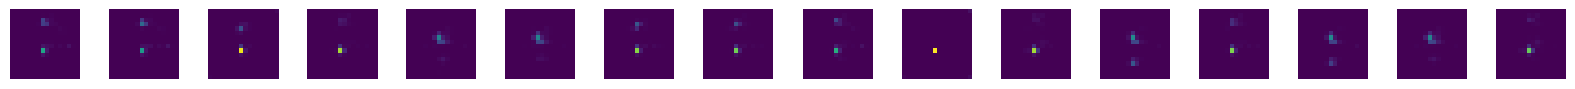

[Epoch 97/300] [D loss: 0.5348] [G loss: 0.2535] [Validity_loss: 0.1529] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0125]
Sample feature coding: [ 0.         -0.68966424  0.16196267  0.47167227  0.48638994  0.00707323
  0.05322583  0.00364243  0.01980635]


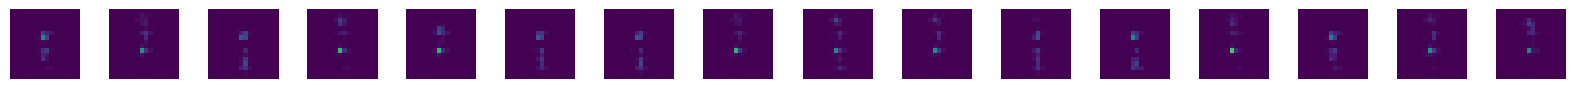

[Epoch 98/300] [D loss: 0.5867] [G loss: 0.3386] [Validity_loss: 0.1427] 
 [Stat_loss: 0.1775] [NNZ_loss: 0.0184]
Sample feature coding: [ 0.         -1.6597223   0.10562388  0.15428592  0.5869778   0.00948131
  0.07535965  0.00372436  0.04311927]


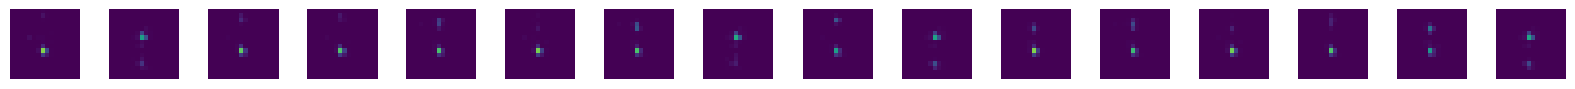

[Epoch 99/300] [D loss: 0.5552] [G loss: 0.2366] [Validity_loss: 0.1376] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0108]
Sample feature coding: [ 0.         -0.33556074  0.23392549  0.38984683  0.6523877   0.01006523
  0.03383964  0.0038997   0.02687972]


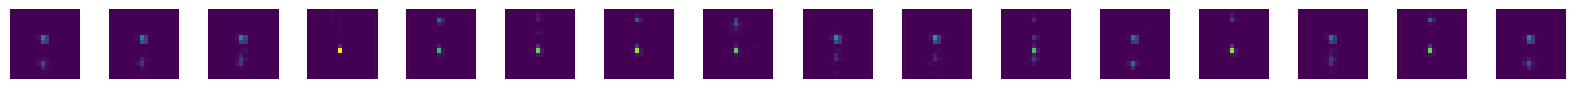

[Epoch 100/300] [D loss: 0.5620] [G loss: 0.2323] [Validity_loss: 0.1310] 
 [Stat_loss: 0.0900] [NNZ_loss: 0.0113]
Sample feature coding: [1.         0.37938914 0.9117536  0.5623799  0.46730208 0.00972031
 0.05865151 0.00355844 0.02296294]


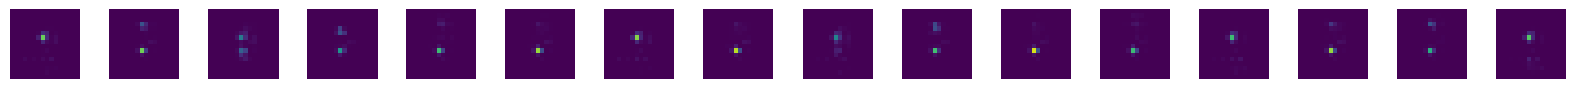

[Epoch 101/300] [D loss: 0.5741] [G loss: 0.2367] [Validity_loss: 0.1377] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0107]
Sample feature coding: [1.         1.7099661  0.59013265 0.1259852  0.5464892  0.00839292
 0.05751751 0.00391327 0.02073764]


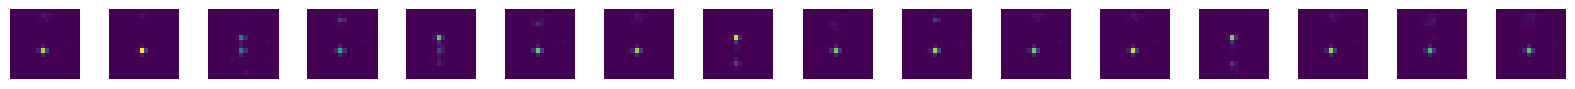

[Epoch 102/300] [D loss: 0.5605] [G loss: 0.2407] [Validity_loss: 0.1406] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0117]
Sample feature coding: [ 1.         -1.0889125   0.8051248   0.17193964  0.5438574   0.00960236
  0.07412557  0.00352523  0.02184605]


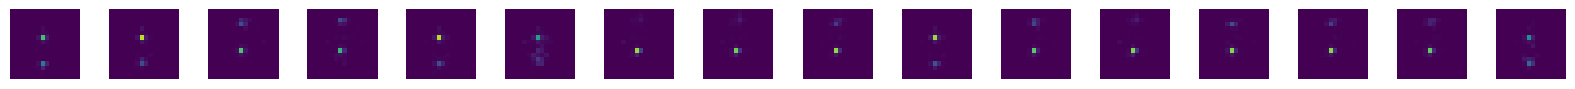

[Epoch 103/300] [D loss: 0.6054] [G loss: 0.2344] [Validity_loss: 0.1351] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0110]
Sample feature coding: [1.         0.41511327 0.61050063 0.5004609  0.4030592  0.01012243
 0.07219009 0.00364751 0.0167025 ]


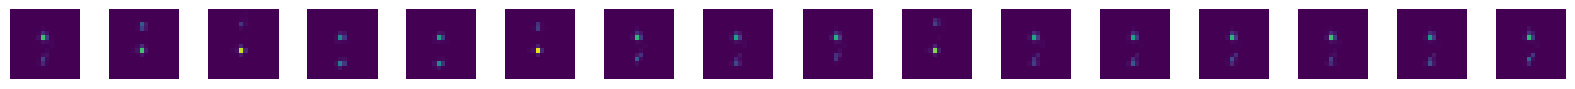

[Epoch 104/300] [D loss: 0.5455] [G loss: 0.2432] [Validity_loss: 0.1439] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0109]
Sample feature coding: [ 1.         -0.51194555  0.5706493   0.6724048   0.49416476  0.00882636
  0.06850111  0.00411306  0.03300177]


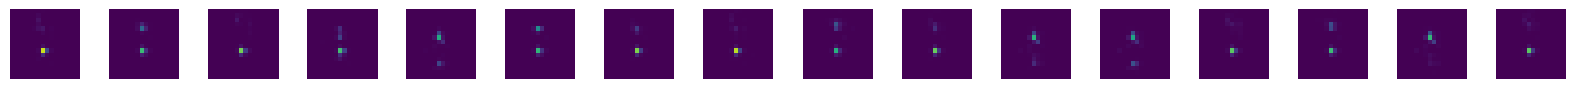

[Epoch 105/300] [D loss: 0.5713] [G loss: 0.2465] [Validity_loss: 0.1467] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0114]
Sample feature coding: [ 1.         -0.06907561  0.4644744   0.34950796  0.5358078   0.00963077
  0.05496686  0.00339218  0.01889911]


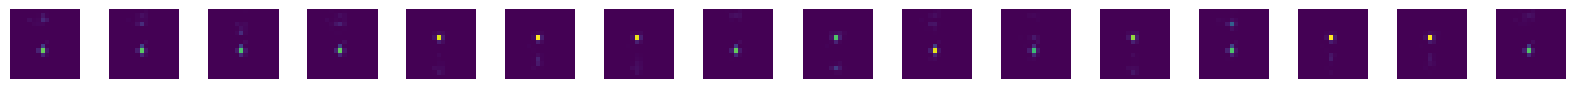

[Epoch 106/300] [D loss: 0.5938] [G loss: 0.2374] [Validity_loss: 0.1376] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0115]
Sample feature coding: [ 1.         -1.110793    0.26313147  0.29727283  0.50952333  0.01134979
  0.05091234  0.00373239  0.02094166]


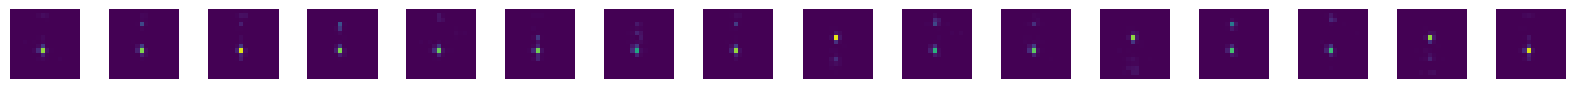

[Epoch 107/300] [D loss: 0.7023] [G loss: 0.2743] [Validity_loss: 0.1737] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0122]
Sample feature coding: [0.         1.9925431  0.97159976 0.23439473 0.53604573 0.00890493
 0.05313371 0.00375589 0.0392055 ]


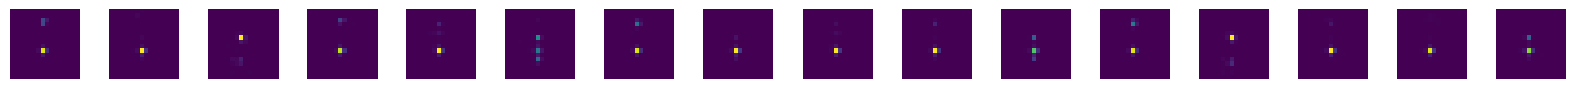

[Epoch 108/300] [D loss: 0.5075] [G loss: 0.2612] [Validity_loss: 0.1614] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0115]
Sample feature coding: [ 0.         -1.5441803   0.86837375  0.0300156   0.87369263  0.00795362
  0.03427163  0.00395215  0.04335025]


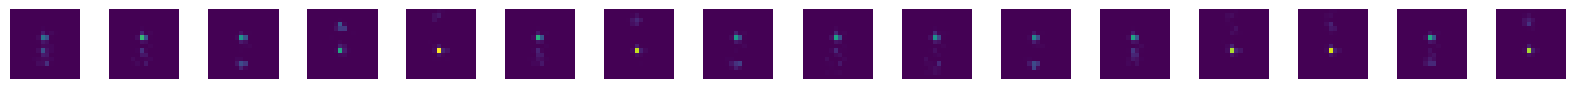

[Epoch 109/300] [D loss: 0.5682] [G loss: 0.3682] [Validity_loss: 0.1514] 
 [Stat_loss: 0.1986] [NNZ_loss: 0.0182]
Sample feature coding: [0.         0.48511857 0.9592588  0.41785812 0.5643933  0.01088576
 0.05800989 0.00386812 0.02257022]


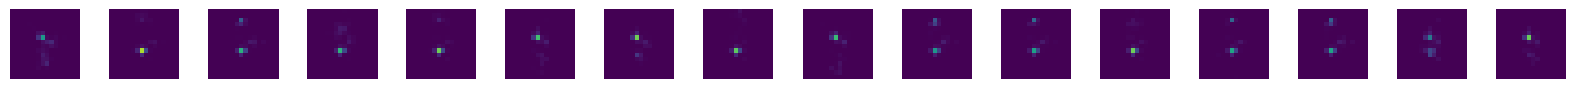

[Epoch 110/300] [D loss: 0.5550] [G loss: 0.2329] [Validity_loss: 0.1338] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0107]
Sample feature coding: [1.         1.6734048  0.22048715 0.3445541  0.46106768 0.01007201
 0.06104025 0.00341469 0.0320414 ]


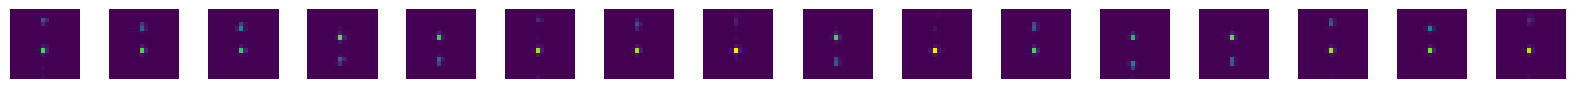

[Epoch 111/300] [D loss: 0.5284] [G loss: 0.2754] [Validity_loss: 0.1695] 
 [Stat_loss: 0.0935] [NNZ_loss: 0.0124]
Sample feature coding: [ 0.         -1.4946163   0.6565837   0.05920507  0.7821361   0.00749567
  0.0531754   0.00410527  0.02511928]


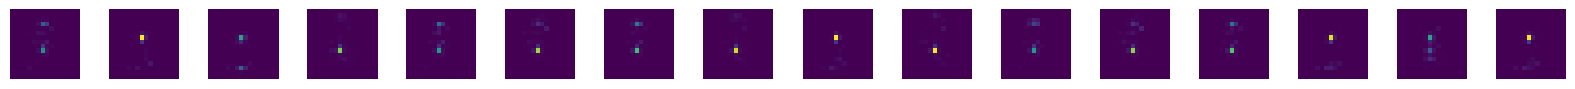

[Epoch 112/300] [D loss: 0.5756] [G loss: 0.4412] [Validity_loss: 0.1640] 
 [Stat_loss: 0.2612] [NNZ_loss: 0.0160]
Sample feature coding: [0.         0.60695314 0.5569071  0.41797933 0.50462085 0.01015272
 0.02850092 0.00377387 0.02736283]


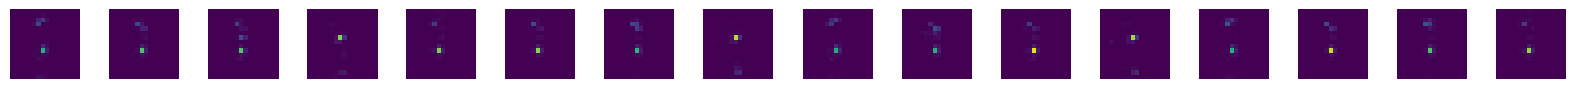

[Epoch 113/300] [D loss: 0.4995] [G loss: 0.2752] [Validity_loss: 0.1739] 
 [Stat_loss: 0.0902] [NNZ_loss: 0.0111]
Sample feature coding: [1.         1.9675455  0.95297647 0.2259266  0.53401446 0.01077638
 0.06999481 0.00403832 0.02666922]


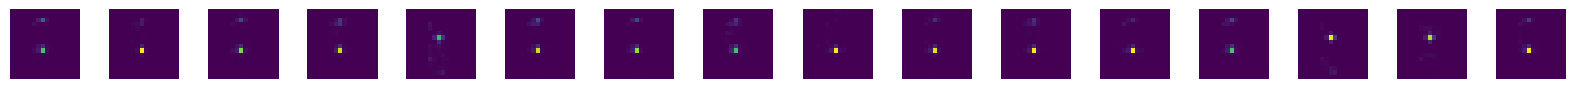

[Epoch 114/300] [D loss: 0.5878] [G loss: 0.2465] [Validity_loss: 0.1469] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0113]
Sample feature coding: [1.         1.7013848  0.89874446 1.0260221  0.9101144  0.0106907
 0.03579932 0.0038655  0.02557635]


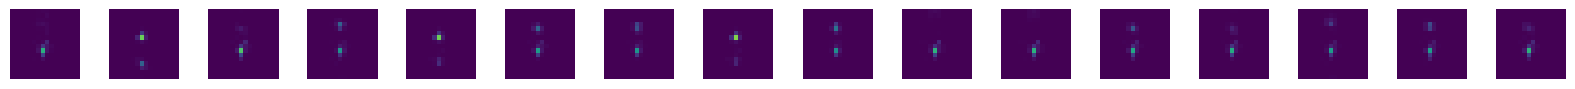

[Epoch 115/300] [D loss: 0.5281] [G loss: 0.2430] [Validity_loss: 0.1444] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0102]
Sample feature coding: [ 0.         -0.36482307  0.74050885  0.19116175  0.5591902   0.00919814
  0.0670649   0.00355404  0.02268672]


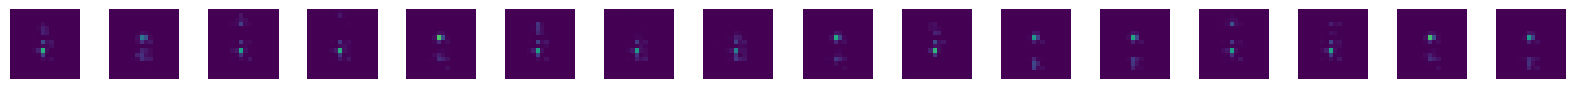

[Epoch 116/300] [D loss: 0.5571] [G loss: 0.4236] [Validity_loss: 0.1966] 
 [Stat_loss: 0.2090] [NNZ_loss: 0.0180]
Sample feature coding: [ 1.         -1.9516562   0.6419537   0.7865653   0.5143553   0.01135323
  0.05067018  0.00414865  0.02768999]


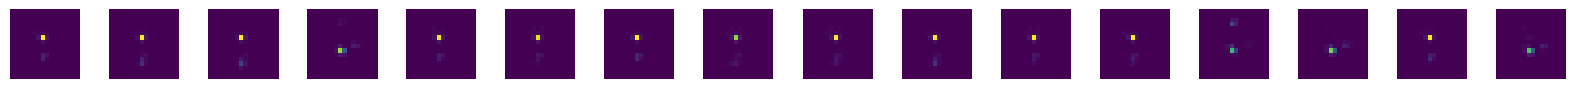

[Epoch 117/300] [D loss: 0.5774] [G loss: 0.2621] [Validity_loss: 0.1594] 
 [Stat_loss: 0.0909] [NNZ_loss: 0.0117]
Sample feature coding: [0.         0.16802874 0.5571392  0.88974804 0.62391895 0.01003336
 0.04806839 0.00413325 0.03880706]


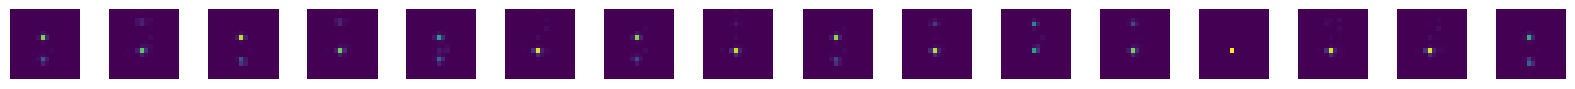

[Epoch 118/300] [D loss: 0.5872] [G loss: 0.2279] [Validity_loss: 0.1273] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0122]
Sample feature coding: [0.         0.54881424 0.33210108 0.44997248 0.5780046  0.01049221
 0.04133034 0.00372435 0.04060531]


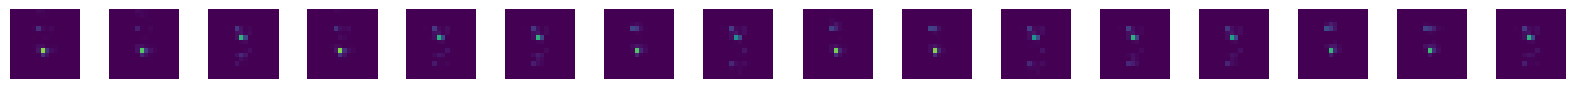

[Epoch 119/300] [D loss: 0.5148] [G loss: 0.2485] [Validity_loss: 0.1495] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0106]
Sample feature coding: [1.         0.09947966 0.5933701  0.18267253 0.9607183  0.01248466
 0.07934339 0.003676   0.03213446]


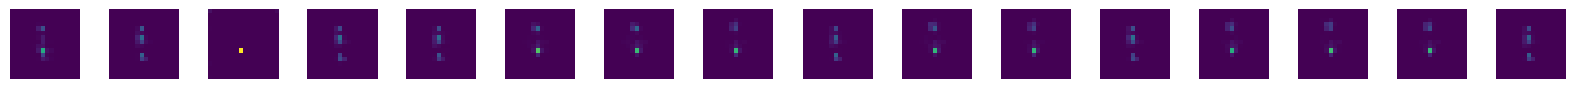

[Epoch 120/300] [D loss: 0.5597] [G loss: 0.2671] [Validity_loss: 0.1611] 
 [Stat_loss: 0.0943] [NNZ_loss: 0.0116]
Sample feature coding: [0.         0.74890184 0.8528293  0.36004102 0.50372267 0.00823945
 0.04778848 0.00397103 0.02200372]


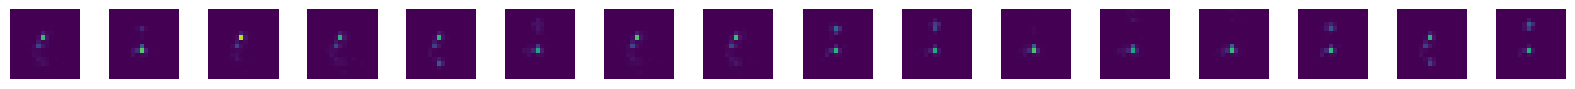

[Epoch 121/300] [D loss: 0.5454] [G loss: 0.2570] [Validity_loss: 0.1519] 
 [Stat_loss: 0.0938] [NNZ_loss: 0.0113]
Sample feature coding: [ 1.         -1.4964967   0.35324988  0.0944014   0.590663    0.01046621
  0.06517921  0.00382401  0.0362156 ]


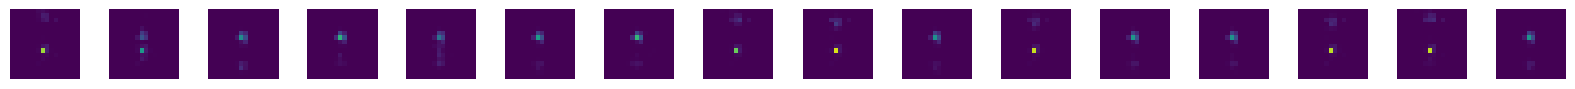

[Epoch 122/300] [D loss: 0.4916] [G loss: 0.3725] [Validity_loss: 0.1626] 
 [Stat_loss: 0.1906] [NNZ_loss: 0.0193]
Sample feature coding: [1.         0.903314   0.13430558 0.38598415 0.43820122 0.00867807
 0.06852975 0.00370293 0.02868937]


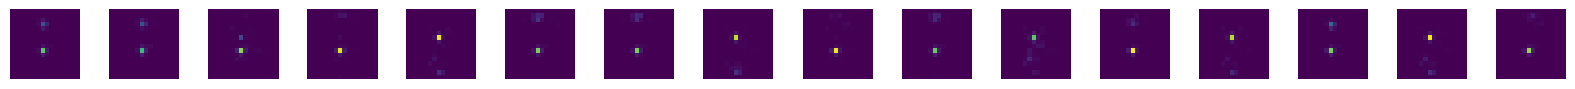

[Epoch 123/300] [D loss: 0.5993] [G loss: 0.2496] [Validity_loss: 0.1501] 
 [Stat_loss: 0.0885] [NNZ_loss: 0.0111]
Sample feature coding: [1.         1.3187681  0.84187365 0.5013844  0.3170848  0.00856004
 0.09494515 0.00395869 0.02676132]


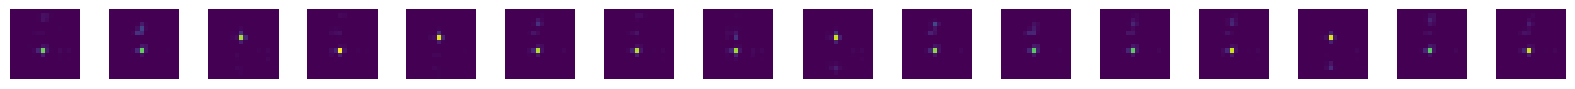

[Epoch 124/300] [D loss: 0.5147] [G loss: 0.4425] [Validity_loss: 0.1647] 
 [Stat_loss: 0.2627] [NNZ_loss: 0.0151]
Sample feature coding: [ 1.         -1.6489353   0.73064005  0.4979198   0.8418816   0.00970362
  0.07167991  0.00394686  0.03271596]


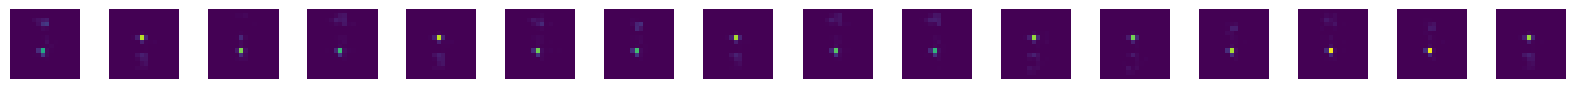

[Epoch 125/300] [D loss: 0.5016] [G loss: 0.3718] [Validity_loss: 0.1624] 
 [Stat_loss: 0.1958] [NNZ_loss: 0.0136]
Sample feature coding: [0.         1.4845266  0.24600296 0.38129175 0.49703726 0.00802903
 0.05223612 0.00404143 0.02072219]


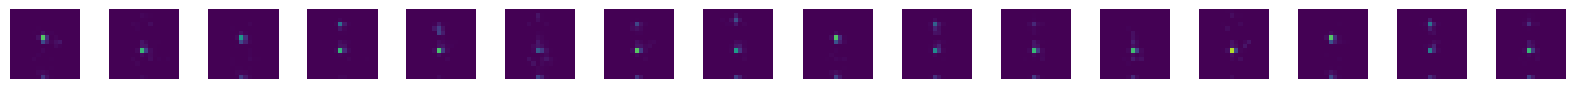

[Epoch 126/300] [D loss: 0.5440] [G loss: 0.2425] [Validity_loss: 0.1431] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0112]
Sample feature coding: [0.         0.03352275 0.9363405  0.37948683 0.48687568 0.00816135
 0.07672755 0.00419605 0.02270773]


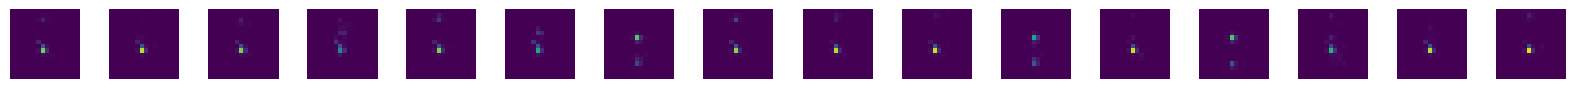

[Epoch 127/300] [D loss: 0.6727] [G loss: 0.2507] [Validity_loss: 0.1504] 
 [Stat_loss: 0.0880] [NNZ_loss: 0.0122]
Sample feature coding: [ 0.         -0.9217426   0.6300743   0.04557686  1.0387586   0.01027004
  0.04620744  0.00367237  0.03627938]


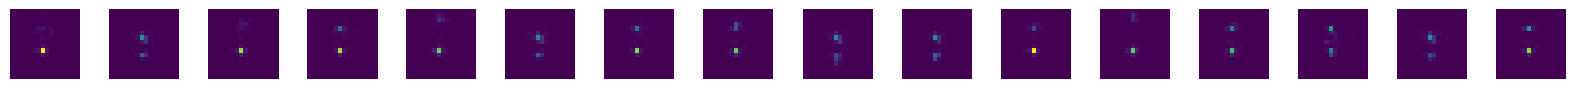

[Epoch 128/300] [D loss: 0.5464] [G loss: 0.2474] [Validity_loss: 0.1479] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0112]
Sample feature coding: [ 0.         -0.31813627  0.5859801   0.5379844   0.3133508   0.00985114
  0.06925205  0.00357349  0.0268066 ]


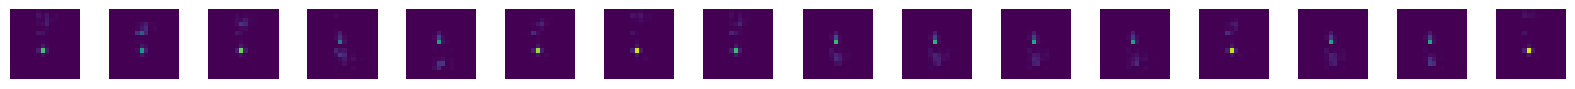

[Epoch 129/300] [D loss: 0.5975] [G loss: 0.2181] [Validity_loss: 0.1166] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0131]
Sample feature coding: [ 0.         -0.8009796   0.514582    0.5972482   0.32733065  0.00967403
  0.06777254  0.00379632  0.01755062]


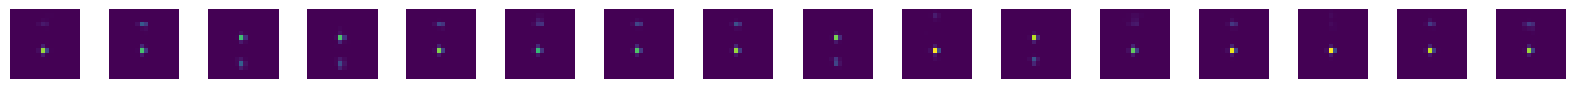

[Epoch 130/300] [D loss: 0.5379] [G loss: 0.2394] [Validity_loss: 0.1390] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0121]
Sample feature coding: [ 1.         -1.7924279   0.49905518  0.25953078  0.5510125   0.00889886
  0.06673595  0.00346199  0.02873054]


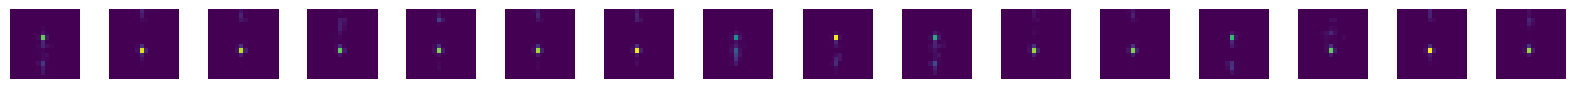

[Epoch 131/300] [D loss: 0.5316] [G loss: 0.2627] [Validity_loss: 0.1588] 
 [Stat_loss: 0.0927] [NNZ_loss: 0.0112]
Sample feature coding: [1.         0.42071164 0.82716274 0.36342072 0.4086753  0.01041516
 0.0596552  0.00399637 0.0222579 ]


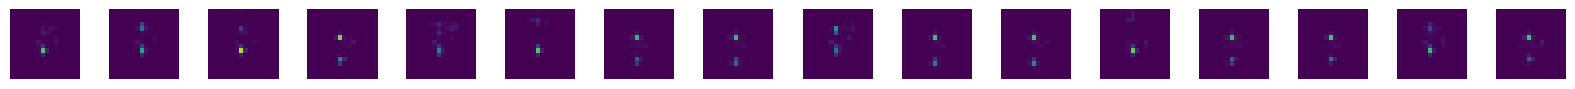

[Epoch 132/300] [D loss: 0.5713] [G loss: 0.2341] [Validity_loss: 0.1346] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0111]
Sample feature coding: [0.         0.17008221 0.10567993 0.24886364 0.5730581  0.01190353
 0.06090439 0.00349826 0.05027736]


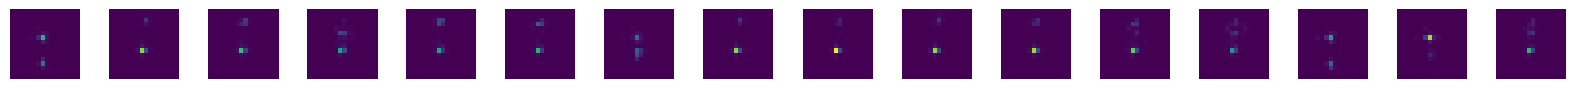

[Epoch 133/300] [D loss: 0.5743] [G loss: 0.2474] [Validity_loss: 0.1474] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0116]
Sample feature coding: [1.         1.6809262  0.8354536  0.4325934  0.35752967 0.00880681
 0.08029198 0.00401535 0.0278036 ]


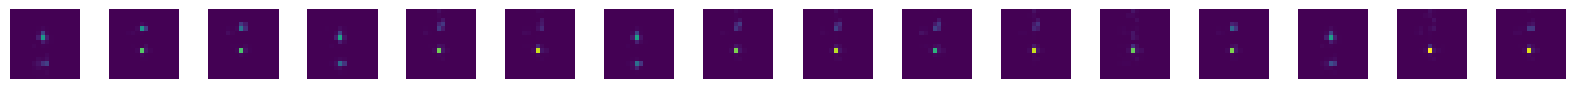

[Epoch 134/300] [D loss: 0.5398] [G loss: 0.2479] [Validity_loss: 0.1490] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0107]
Sample feature coding: [ 0.         -1.7054257   0.8995163   0.41177583  0.6060186   0.00769234
  0.07023112  0.0037747   0.03465816]


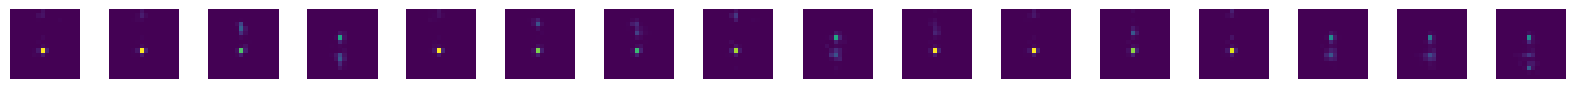

[Epoch 135/300] [D loss: 0.5155] [G loss: 0.2688] [Validity_loss: 0.1693] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0112]
Sample feature coding: [ 1.         -0.50727016  0.70914656  0.52103573  0.71190345  0.00918811
  0.07795002  0.00405291  0.0273324 ]


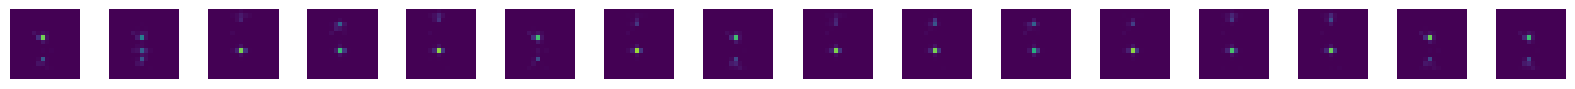

[Epoch 136/300] [D loss: 0.5498] [G loss: 0.2648] [Validity_loss: 0.1645] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0120]
Sample feature coding: [1.         1.6721284  0.56028366 0.20865619 0.60260373 0.00893467
 0.0698449  0.00379321 0.01492402]


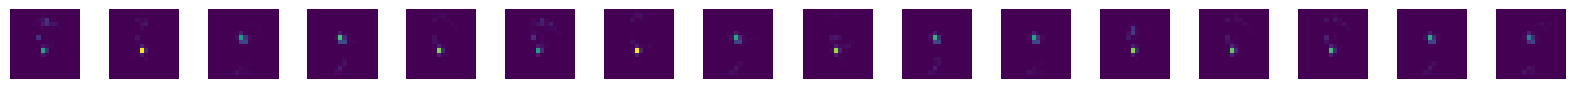

[Epoch 137/300] [D loss: 0.5377] [G loss: 0.2656] [Validity_loss: 0.1668] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0105]
Sample feature coding: [ 0.         -0.39003384  0.440504    0.7528525   0.38918656  0.01073403
  0.06961311  0.00360877  0.0361868 ]


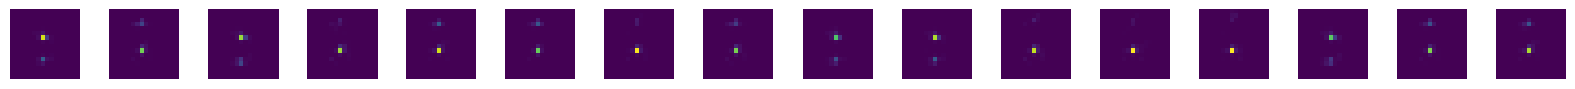

[Epoch 138/300] [D loss: 0.5279] [G loss: 0.2497] [Validity_loss: 0.1506] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0108]
Sample feature coding: [0.         0.31232184 0.25594613 0.35991442 0.49403274 0.01255953
 0.05135277 0.00392275 0.02283383]


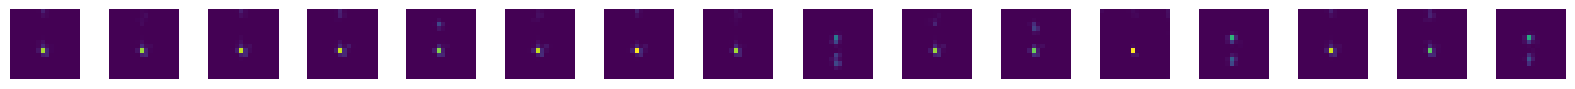

[Epoch 139/300] [D loss: 0.5206] [G loss: 0.2745] [Validity_loss: 0.1664] 
 [Stat_loss: 0.0965] [NNZ_loss: 0.0116]
Sample feature coding: [1.         1.7244582  0.50537825 0.35089752 0.4580127  0.00982766
 0.03426614 0.00376194 0.02725817]


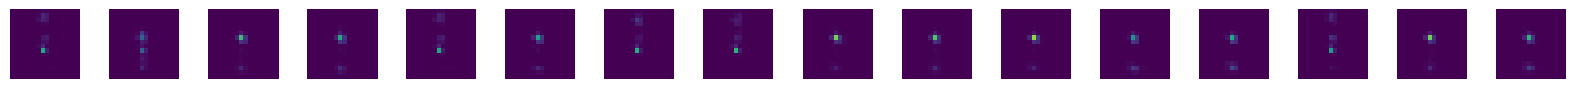

[Epoch 140/300] [D loss: 0.5280] [G loss: 0.2694] [Validity_loss: 0.1710] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0101]
Sample feature coding: [1.         0.9721699  0.5824789  0.85025215 0.53879887 0.01172923
 0.03474243 0.00416158 0.02319776]


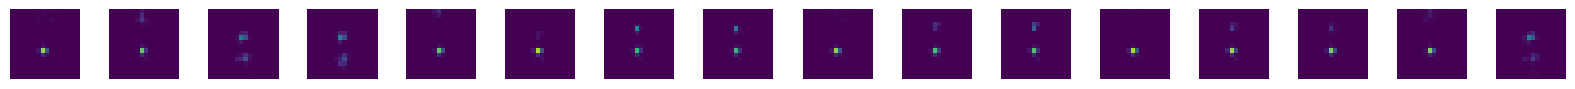

[Epoch 141/300] [D loss: 0.5835] [G loss: 0.2592] [Validity_loss: 0.1600] 
 [Stat_loss: 0.0873] [NNZ_loss: 0.0119]
Sample feature coding: [0.         0.11657323 0.1981486  0.32316852 0.68333924 0.00822593
 0.05729597 0.00369898 0.03510954]


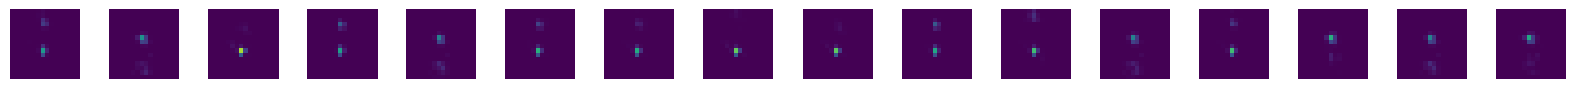

[Epoch 142/300] [D loss: 0.5539] [G loss: 0.2621] [Validity_loss: 0.1614] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0125]
Sample feature coding: [0.         1.2634196  0.14667134 0.2797123  0.886035   0.00785483
 0.08325658 0.00393263 0.01644619]


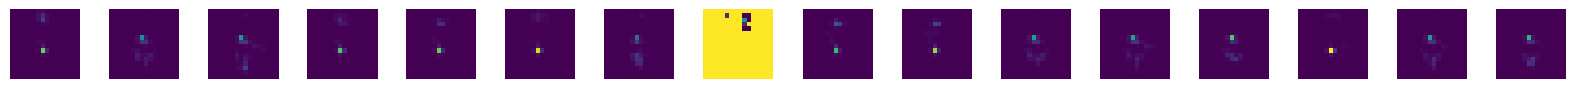

[Epoch 143/300] [D loss: 0.5987] [G loss: 0.2682] [Validity_loss: 0.1654] 
 [Stat_loss: 0.0880] [NNZ_loss: 0.0148]
Sample feature coding: [ 1.         -0.12820251  0.8277574   0.4771331   0.7253694   0.01091352
  0.04984367  0.00347192  0.03212657]


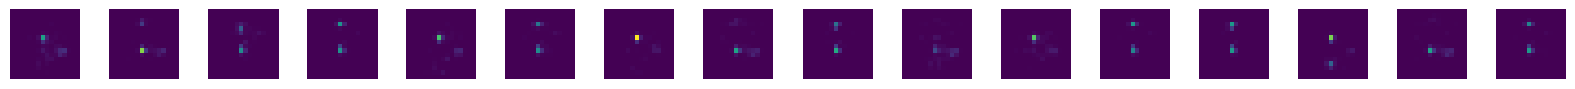

[Epoch 144/300] [D loss: 0.5549] [G loss: 0.2517] [Validity_loss: 0.1511] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0124]
Sample feature coding: [1.         0.35301635 0.46980014 0.20649543 0.6901033  0.00842935
 0.04313578 0.00360616 0.02315131]


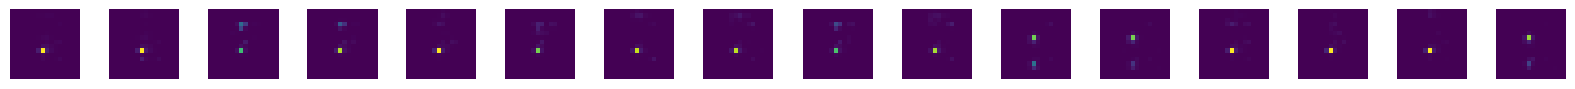

[Epoch 145/300] [D loss: 0.5556] [G loss: 0.2505] [Validity_loss: 0.1498] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0125]
Sample feature coding: [ 1.         -0.06859072  0.941107    0.30630153  0.75130516  0.00877637
  0.06701617  0.00354553  0.02291142]


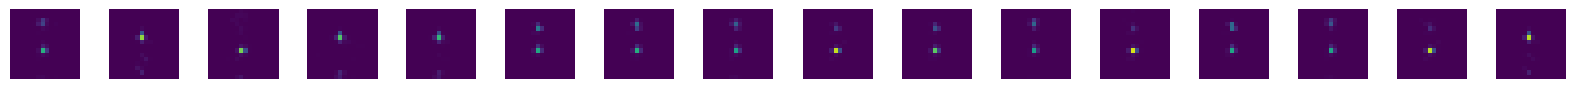

[Epoch 146/300] [D loss: 0.5116] [G loss: 0.2594] [Validity_loss: 0.1606] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0107]
Sample feature coding: [ 1.         -1.9447244   0.10903565  0.17703213  0.62446475  0.01059862
  0.09049609  0.00381085  0.02833101]


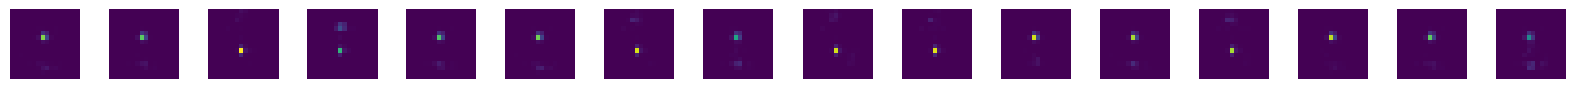

[Epoch 147/300] [D loss: 0.6007] [G loss: 0.2237] [Validity_loss: 0.1256] 
 [Stat_loss: 0.0873] [NNZ_loss: 0.0108]
Sample feature coding: [1.         0.461614   0.46438766 0.4353685  0.41957608 0.0095625
 0.04066106 0.00373984 0.01484777]


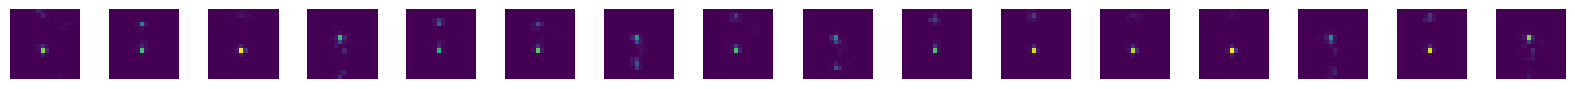

[Epoch 148/300] [D loss: 0.5242] [G loss: 0.2691] [Validity_loss: 0.1695] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0113]
Sample feature coding: [ 1.         -1.8976421   0.5812578   0.03659706  0.6299618   0.00935348
  0.04689018  0.00364583  0.03207514]


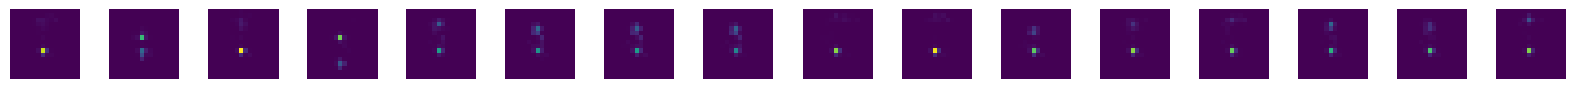

[Epoch 149/300] [D loss: 0.5218] [G loss: 0.2653] [Validity_loss: 0.1658] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0112]
Sample feature coding: [ 0.         -1.6624945   0.38647902  0.41275805  0.6038845   0.00981218
  0.03621829  0.00390422  0.03628166]


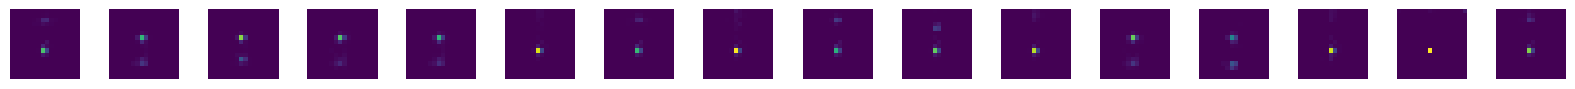

[Epoch 150/300] [D loss: 0.5527] [G loss: 0.2489] [Validity_loss: 0.1498] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0108]
Sample feature coding: [ 0.         -0.9524643   0.07092539  0.36690164  0.37881956  0.00753216
  0.0416944   0.00413973  0.03024634]


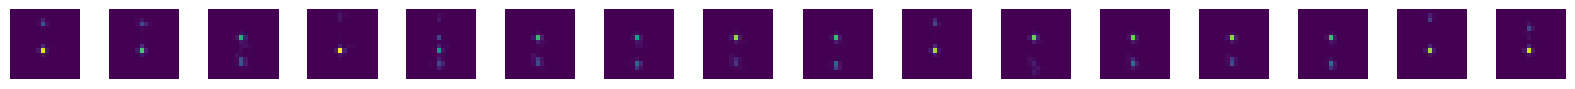

[Epoch 151/300] [D loss: 0.5264] [G loss: 0.2638] [Validity_loss: 0.1638] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0117]
Sample feature coding: [ 0.         -1.924923    0.23050173  0.47930458  0.6700795   0.00988729
  0.07000757  0.00358796  0.03360087]


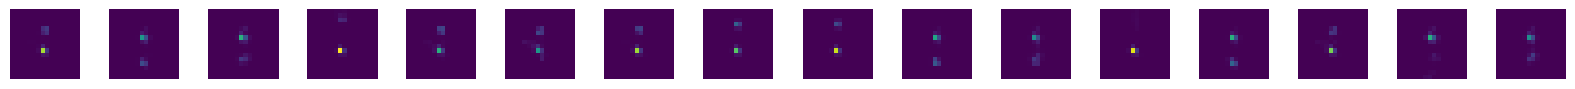

[Epoch 152/300] [D loss: 0.5670] [G loss: 0.2276] [Validity_loss: 0.1288] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0104]
Sample feature coding: [0.         0.07102954 0.0483121  0.6700077  0.8964371  0.01014613
 0.05862729 0.00404662 0.01503591]


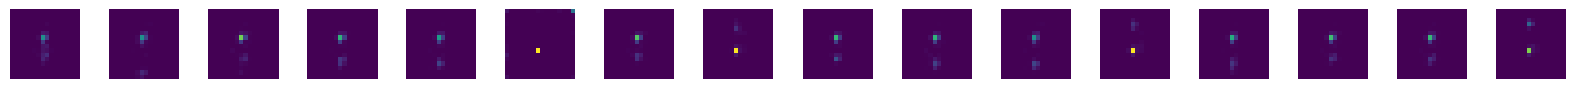

[Epoch 153/300] [D loss: 0.5379] [G loss: 0.2506] [Validity_loss: 0.1520] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0105]
Sample feature coding: [ 0.         -1.7372453   0.53999484  0.6899394   0.40736502  0.00917203
  0.0480211   0.0039204   0.05574338]


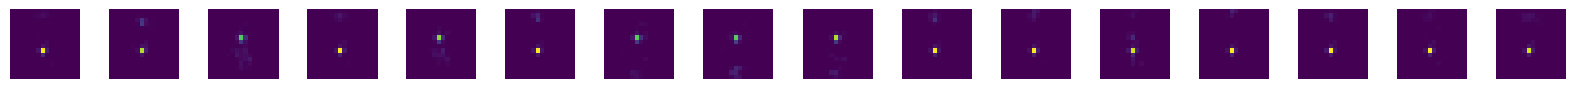

[Epoch 154/300] [D loss: 0.5177] [G loss: 0.2659] [Validity_loss: 0.1651] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0125]
Sample feature coding: [ 1.         -0.03051341  0.4848402   0.54951704  0.79323834  0.01113089
  0.05129114  0.00364362  0.03050284]


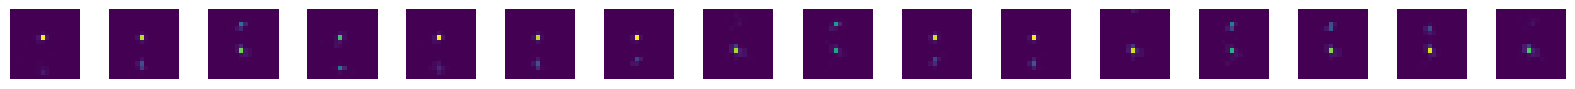

[Epoch 155/300] [D loss: 0.5514] [G loss: 0.2962] [Validity_loss: 0.1821] 
 [Stat_loss: 0.1024] [NNZ_loss: 0.0117]
Sample feature coding: [ 0.         -0.89457273  0.5535809   0.6720227   0.37872416  0.00761387
  0.05418384  0.00409551  0.02945944]


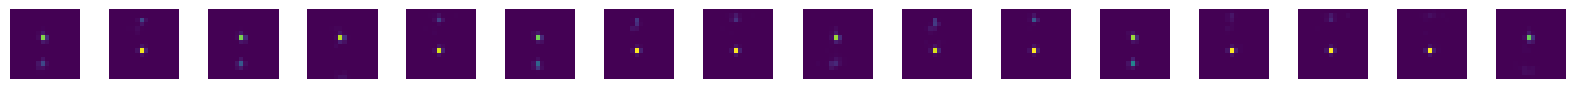

[Epoch 156/300] [D loss: 0.5158] [G loss: 0.2969] [Validity_loss: 0.1804] 
 [Stat_loss: 0.1056] [NNZ_loss: 0.0109]
Sample feature coding: [ 0.         -1.1235012   0.31416294  0.37801003  0.35140395  0.01105449
  0.04584844  0.00400751  0.04305797]


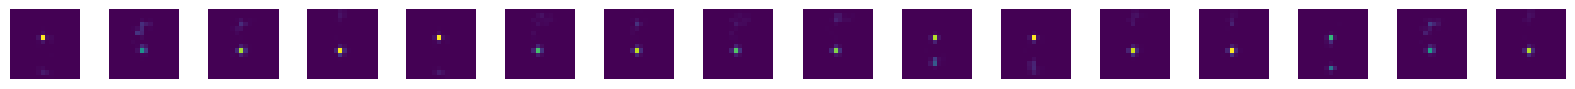

[Epoch 157/300] [D loss: 0.4762] [G loss: 0.2820] [Validity_loss: 0.1829] 
 [Stat_loss: 0.0879] [NNZ_loss: 0.0111]
Sample feature coding: [ 1.         -0.5526449   0.952381    0.45096758  0.66183764  0.00789093
  0.04733643  0.00389717  0.03203071]


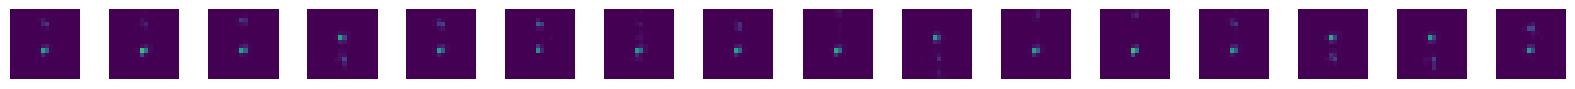

[Epoch 158/300] [D loss: 0.5293] [G loss: 0.3513] [Validity_loss: 0.1808] 
 [Stat_loss: 0.1578] [NNZ_loss: 0.0126]
Sample feature coding: [ 1.         -1.6102988   0.07104442  0.4889892   0.4235761   0.00993946
  0.0639354   0.00376255  0.03734453]


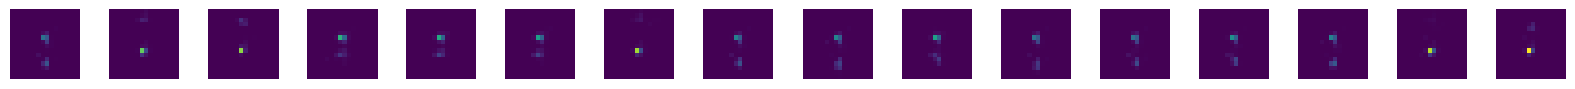

[Epoch 159/300] [D loss: 0.5501] [G loss: 0.2782] [Validity_loss: 0.1784] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0115]
Sample feature coding: [1.         0.9979641  0.6082355  0.93959826 0.50622433 0.01033856
 0.06622913 0.00413813 0.02989898]


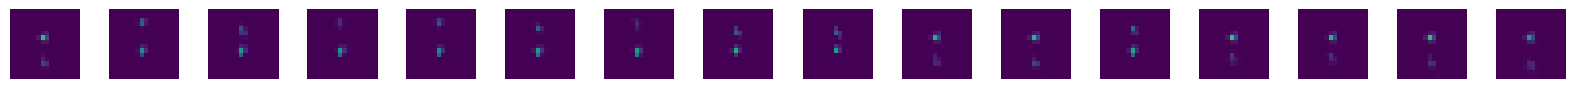

[Epoch 160/300] [D loss: 0.4899] [G loss: 0.2655] [Validity_loss: 0.1657] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0115]
Sample feature coding: [1.         0.22417226 0.7686148  0.48590896 0.5750081  0.0105364
 0.0623862  0.00381348 0.04252139]


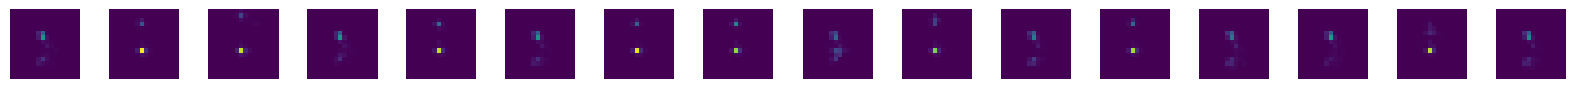

[Epoch 161/300] [D loss: 0.5805] [G loss: 0.2443] [Validity_loss: 0.1449] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0111]
Sample feature coding: [0.         1.3059497  0.9754072  0.11230123 0.77977896 0.00819094
 0.06401654 0.00413775 0.03267999]


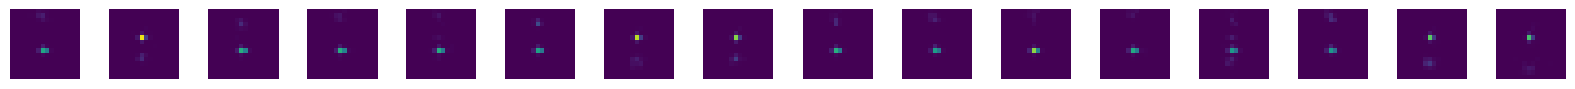

[Epoch 162/300] [D loss: 0.5931] [G loss: 0.2532] [Validity_loss: 0.1532] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0117]
Sample feature coding: [ 0.         -0.989173    0.19025446  0.45651832  0.49293226  0.01082227
  0.06986586  0.00373163  0.02901757]


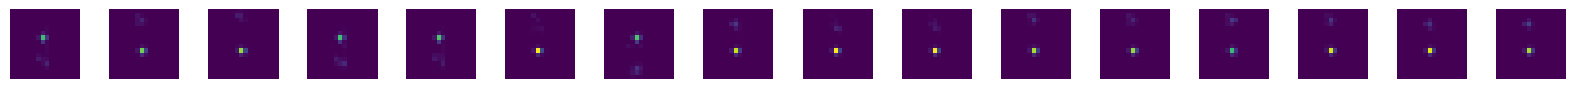

[Epoch 163/300] [D loss: 0.5081] [G loss: 0.2912] [Validity_loss: 0.1923] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0108]
Sample feature coding: [1.         1.1153506  0.10318541 0.7159255  0.38470525 0.00992119
 0.05042704 0.00404489 0.04860584]


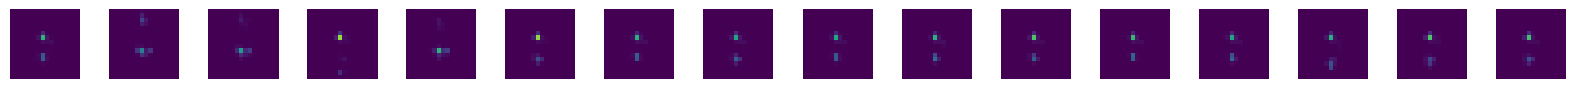

[Epoch 164/300] [D loss: 0.3986] [G loss: 0.3112] [Validity_loss: 0.2121] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0110]
Sample feature coding: [0.         0.15035509 0.8102008  0.34925508 0.70413077 0.01148203
 0.06702592 0.00367032 0.02768563]


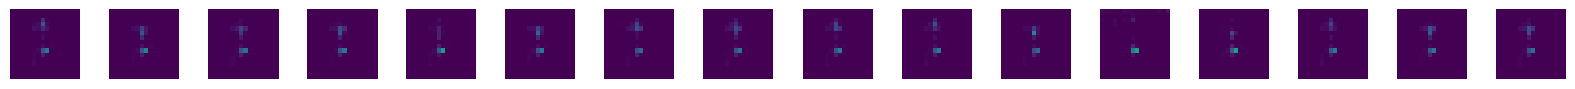

[Epoch 165/300] [D loss: 0.4302] [G loss: 0.2891] [Validity_loss: 0.1906] 
 [Stat_loss: 0.0877] [NNZ_loss: 0.0108]
Sample feature coding: [ 0.         -0.478155    0.3765342   0.5159587   0.6997322   0.00943243
  0.03155272  0.00361029  0.02831052]


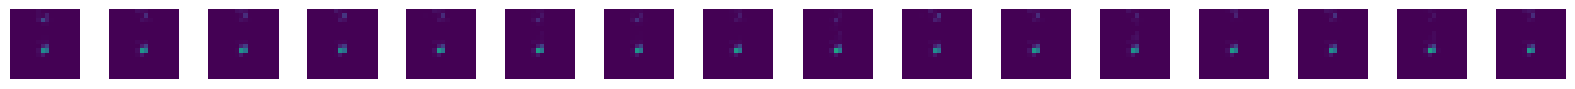

[Epoch 166/300] [D loss: 0.6115] [G loss: 0.2732] [Validity_loss: 0.1742] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0107]
Sample feature coding: [1.         0.18796577 0.7925018  0.04668398 0.7215011  0.01001739
 0.05523443 0.00370597 0.01954394]


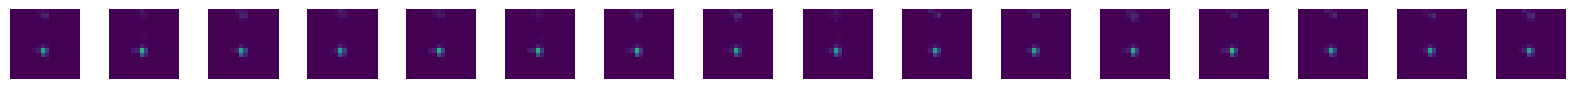

[Epoch 167/300] [D loss: 0.5464] [G loss: 0.2491] [Validity_loss: 0.1491] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0118]
Sample feature coding: [1.         2.1134667  0.7120492  0.3521558  0.67580247 0.00780147
 0.05891586 0.00406826 0.03754207]


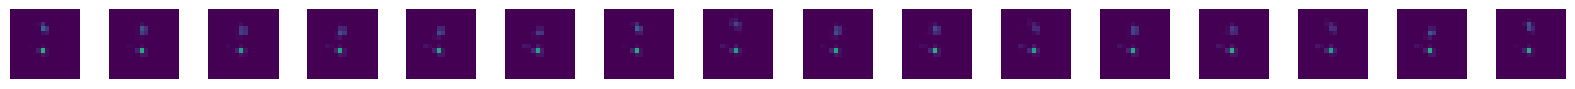

[Epoch 168/300] [D loss: 0.5881] [G loss: 0.3187] [Validity_loss: 0.2207] 
 [Stat_loss: 0.0880] [NNZ_loss: 0.0100]
Sample feature coding: [1.         0.27756146 0.48231605 0.27718514 0.43510652 0.009551
 0.04130585 0.00401356 0.03616797]


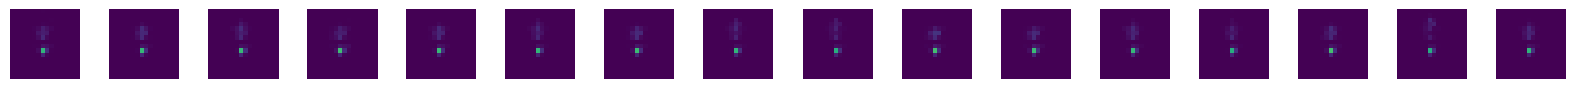

[Epoch 169/300] [D loss: 0.5620] [G loss: 0.3258] [Validity_loss: 0.2216] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0158]
Sample feature coding: [1.         1.9245024  0.02444675 0.49018618 0.58632725 0.00996946
 0.0766091  0.00384716 0.01584411]


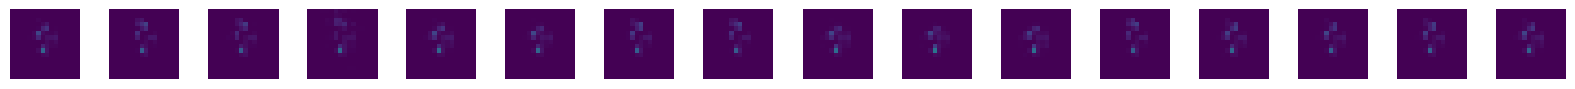

[Epoch 170/300] [D loss: 0.4013] [G loss: 0.3337] [Validity_loss: 0.2335] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0121]
Sample feature coding: [ 0.         -0.3328851   0.38217887  0.4765133   0.44129175  0.00985197
  0.0562862   0.00375314  0.03124298]


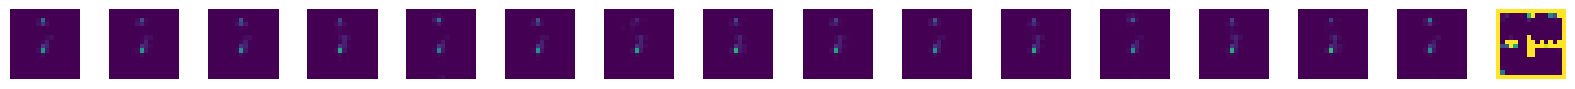

[Epoch 171/300] [D loss: 0.5427] [G loss: 0.2657] [Validity_loss: 0.1666] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0109]
Sample feature coding: [0.         0.43665427 0.19264656 0.29417807 0.43058267 0.00829883
 0.04655843 0.00371214 0.02133013]


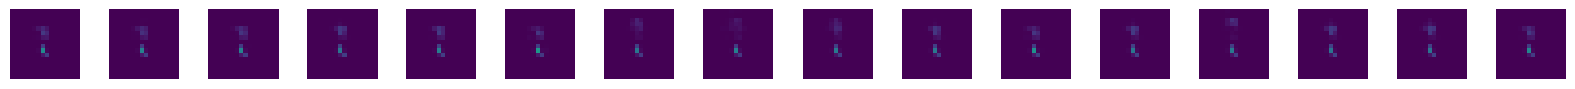

[Epoch 172/300] [D loss: 0.4018] [G loss: 0.3424] [Validity_loss: 0.2436] 
 [Stat_loss: 0.0880] [NNZ_loss: 0.0108]
Sample feature coding: [ 0.         -0.4051286   0.845857    0.861611    0.4335347   0.00840511
  0.06238497  0.00346043  0.03014721]


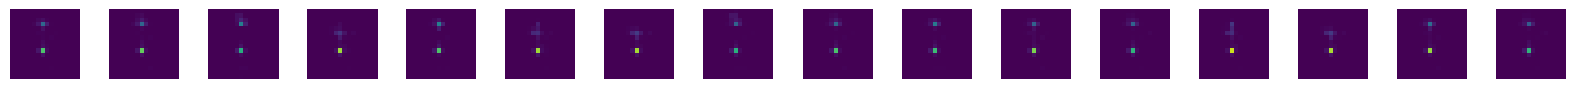

[Epoch 173/300] [D loss: 0.4508] [G loss: 0.2714] [Validity_loss: 0.1713] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0120]
Sample feature coding: [0.         1.5402484  0.23739928 0.86371297 0.5913575  0.00850877
 0.07460091 0.00352567 0.02720232]


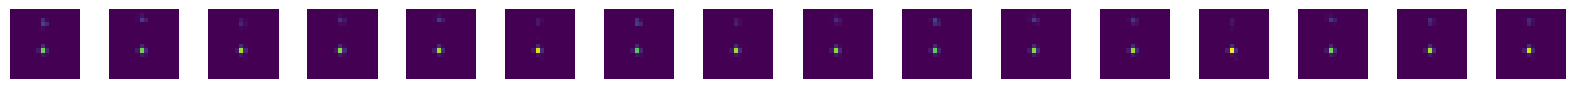

[Epoch 174/300] [D loss: 0.4779] [G loss: 0.3249] [Validity_loss: 0.2136] 
 [Stat_loss: 0.0990] [NNZ_loss: 0.0122]
Sample feature coding: [ 1.         -1.2555321   0.2942656   0.99851435  0.53500164  0.01064834
  0.03073962  0.00371582  0.01202806]


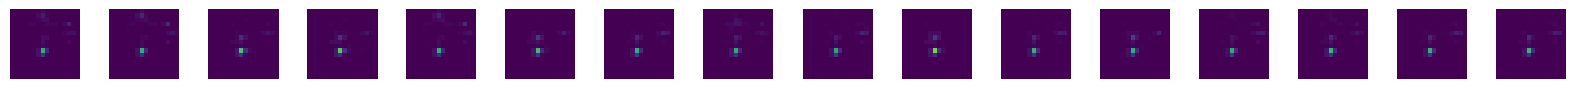

[Epoch 175/300] [D loss: 0.4908] [G loss: 0.3123] [Validity_loss: 0.2120] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0121]
Sample feature coding: [ 1.         -1.0865443   0.04807427  0.2180234   0.6105376   0.00769762
  0.06328195  0.00364331  0.02997099]


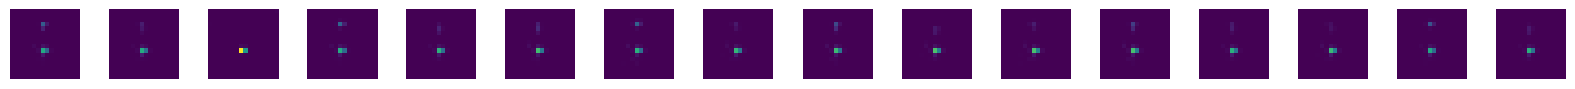

[Epoch 176/300] [D loss: 0.3934] [G loss: 0.3468] [Validity_loss: 0.2484] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0103]
Sample feature coding: [ 0.         -0.47873032  0.02133692  0.81532294  0.61478347  0.00852453
  0.10757073  0.00403149  0.03080415]


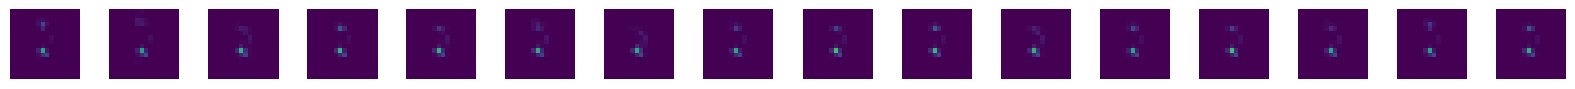

[Epoch 177/300] [D loss: 0.4217] [G loss: 0.3116] [Validity_loss: 0.2120] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0113]
Sample feature coding: [ 0.         -1.4633961   0.87774175  0.47530955  0.7681981   0.00924716
  0.05414454  0.0036422   0.01801703]


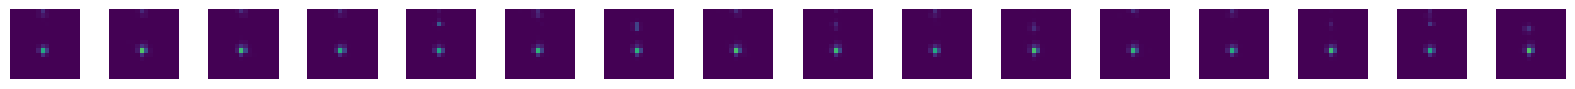

[Epoch 178/300] [D loss: 0.4154] [G loss: 0.3047] [Validity_loss: 0.2068] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0096]
Sample feature coding: [1.         0.18792963 0.53374517 0.22221439 0.53007174 0.00833706
 0.04725619 0.0038094  0.03882738]


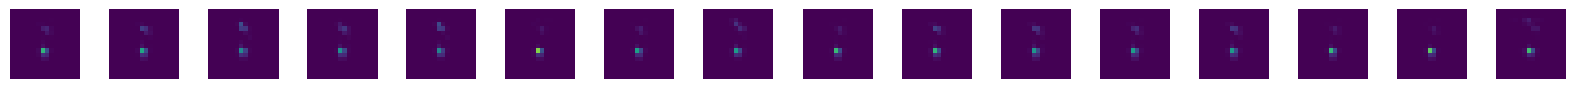

[Epoch 179/300] [D loss: 0.4634] [G loss: 0.2881] [Validity_loss: 0.1900] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0101]
Sample feature coding: [1.         0.3746166  0.4083453  0.6096859  0.539114   0.00983888
 0.05483641 0.00420625 0.03903329]


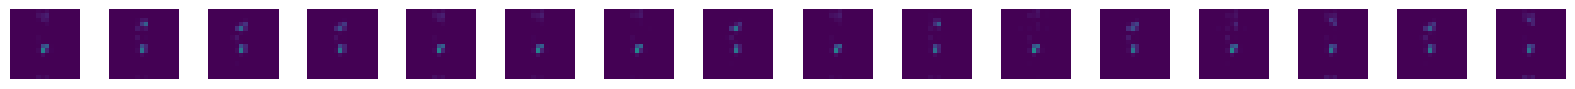

[Epoch 180/300] [D loss: 0.4850] [G loss: 0.2823] [Validity_loss: 0.1790] 
 [Stat_loss: 0.0923] [NNZ_loss: 0.0110]
Sample feature coding: [ 1.         -1.0639541   0.77910024  0.52572733  0.35092154  0.01009734
  0.04509826  0.0039951   0.02627685]


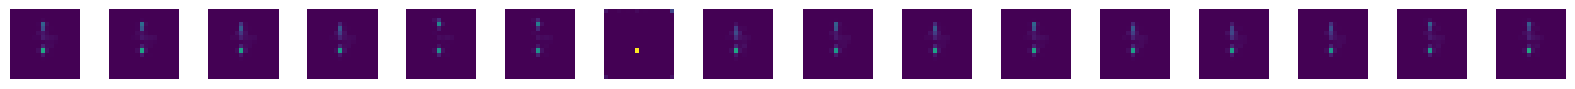

[Epoch 181/300] [D loss: 0.3305] [G loss: 0.4594] [Validity_loss: 0.3519] 
 [Stat_loss: 0.0939] [NNZ_loss: 0.0136]
Sample feature coding: [0.         1.2152923  0.8294862  0.545177   0.5277842  0.00772018
 0.03714101 0.00346803 0.02955412]


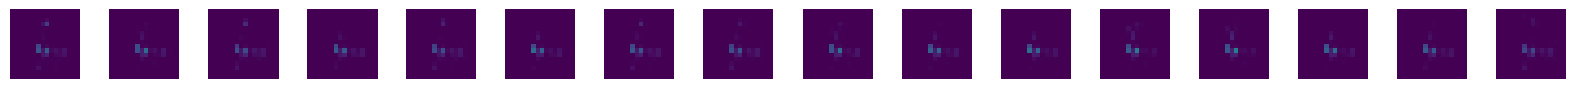

[Epoch 182/300] [D loss: 0.4813] [G loss: 0.2621] [Validity_loss: 0.1628] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0110]
Sample feature coding: [1.         0.6160556  0.849152   0.76941216 0.6104366  0.00766076
 0.08865153 0.0035299  0.02935772]


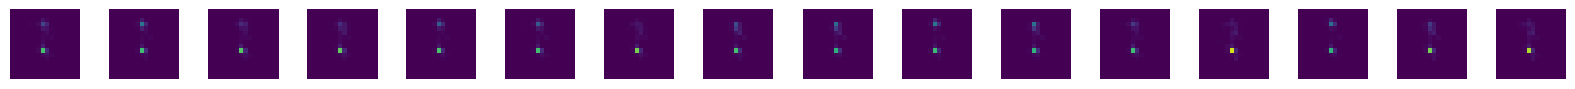

[Epoch 183/300] [D loss: 0.4958] [G loss: 0.2613] [Validity_loss: 0.1631] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0099]
Sample feature coding: [ 1.         -0.848164    0.18266541  0.65988517  0.561431    0.01116557
  0.02709518  0.00396625  0.03346331]


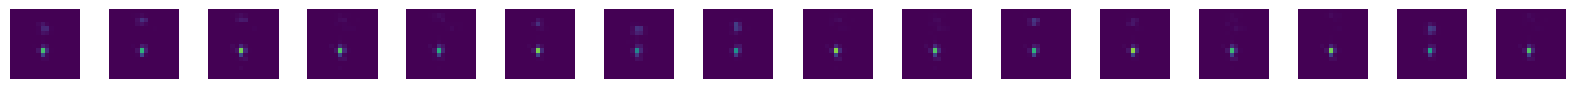

[Epoch 184/300] [D loss: 0.4353] [G loss: 0.2927] [Validity_loss: 0.1932] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0113]
Sample feature coding: [0.         1.6144054  0.06568171 0.33786544 0.43325192 0.00743434
 0.05984233 0.00376166 0.04502673]


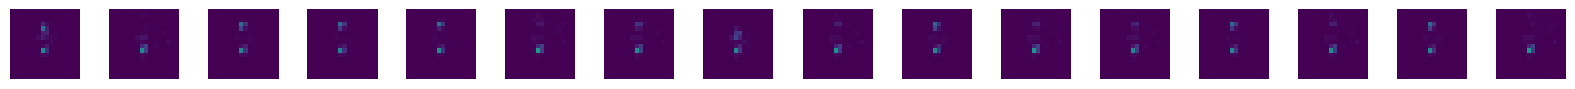

[Epoch 185/300] [D loss: 0.4415] [G loss: 0.2867] [Validity_loss: 0.1842] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0143]
Sample feature coding: [0.         0.44131696 0.35479492 0.03022185 0.49274692 0.00713273
 0.04688202 0.00365611 0.03646153]


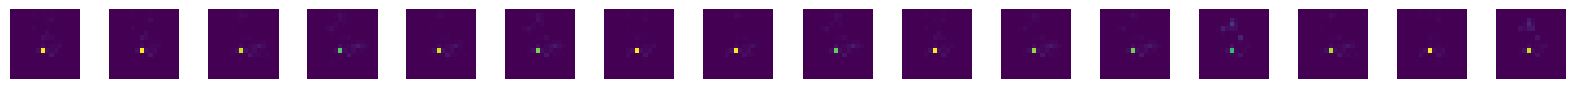

[Epoch 186/300] [D loss: 0.6092] [G loss: 0.3084] [Validity_loss: 0.2097] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0105]
Sample feature coding: [0.         1.5306695  0.07491037 0.362275   0.74512064 0.00932059
 0.04550585 0.0036459  0.02682132]


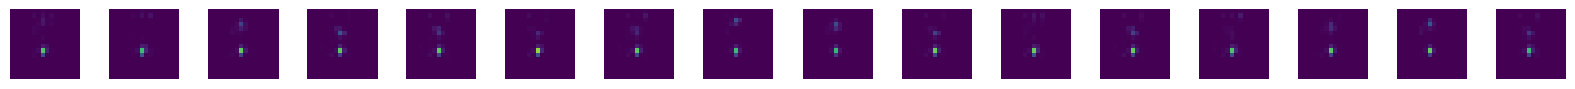

[Epoch 187/300] [D loss: 0.4893] [G loss: 0.2707] [Validity_loss: 0.1709] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0116]
Sample feature coding: [0.         0.38483274 0.7730484  0.50211436 0.5437261  0.00986642
 0.03155909 0.00400852 0.04459236]


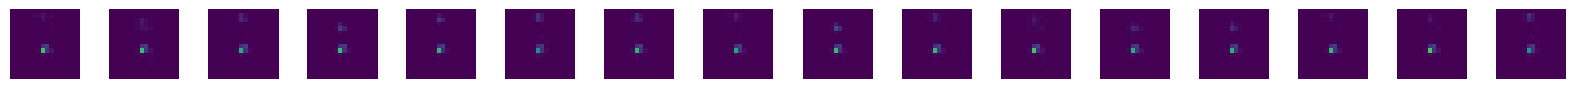

[Epoch 188/300] [D loss: 0.4736] [G loss: 0.2543] [Validity_loss: 0.1543] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0117]
Sample feature coding: [ 1.         -1.3286228   0.37149796  0.7440657   0.46127146  0.0092634
  0.06024102  0.00410365  0.02311613]


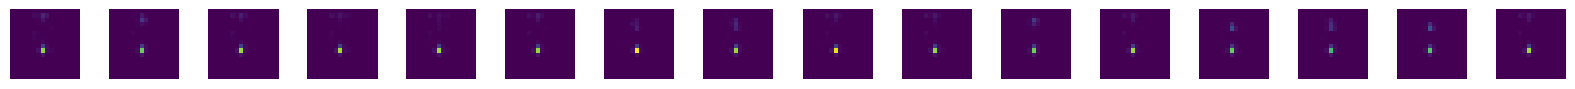

[Epoch 189/300] [D loss: 0.6565] [G loss: 0.2842] [Validity_loss: 0.1852] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0109]
Sample feature coding: [ 1.         -0.7943934  -0.00208917  0.42020363  0.7064953   0.00791132
  0.04173918  0.00413265  0.02475355]


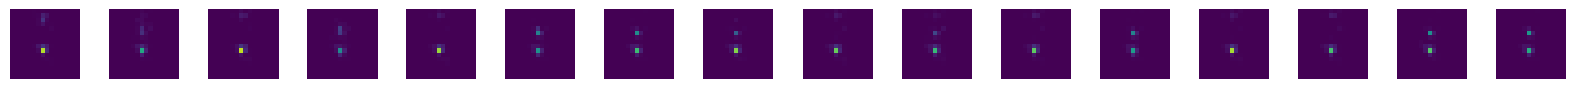

[Epoch 190/300] [D loss: 0.4639] [G loss: 0.2676] [Validity_loss: 0.1676] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0118]
Sample feature coding: [1.         1.176578   0.442051   0.50805855 0.6212038  0.00782842
 0.05431617 0.00348281 0.01694814]


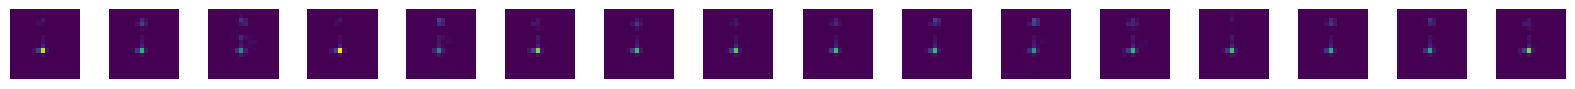

[Epoch 191/300] [D loss: 0.5171] [G loss: 0.2791] [Validity_loss: 0.1800] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0109]
Sample feature coding: [1.         0.861954   0.8471823  0.9921533  0.6976335  0.00867792
 0.03388338 0.00347058 0.0300678 ]


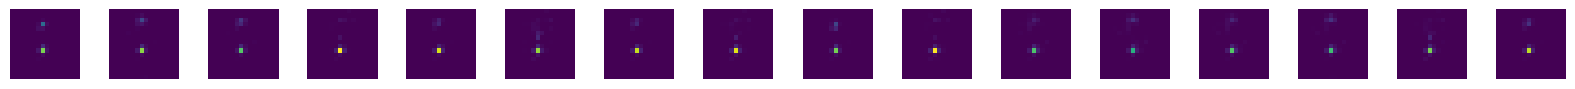

[Epoch 192/300] [D loss: 0.5020] [G loss: 0.2902] [Validity_loss: 0.1902] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0117]
Sample feature coding: [ 0.         -1.8335574   0.13325982  0.45194685  0.378733    0.00791305
  0.0365476   0.00378506  0.02777715]


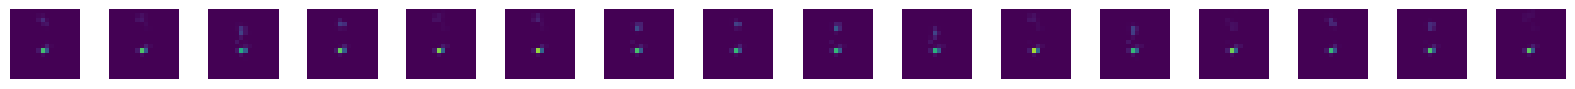

[Epoch 193/300] [D loss: 0.4875] [G loss: 0.2940] [Validity_loss: 0.1939] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0120]
Sample feature coding: [ 0.         -0.7256686   0.77118826  0.4876252   0.7507229   0.01154615
  0.0534285   0.00389192  0.01324001]


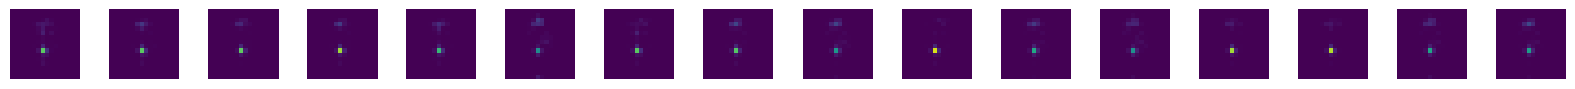

[Epoch 194/300] [D loss: 0.4948] [G loss: 0.3069] [Validity_loss: 0.2074] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0111]
Sample feature coding: [ 1.         -1.5458629   0.6805163   0.4173875   0.69551134  0.01156494
  0.06247914  0.00400875  0.02056772]


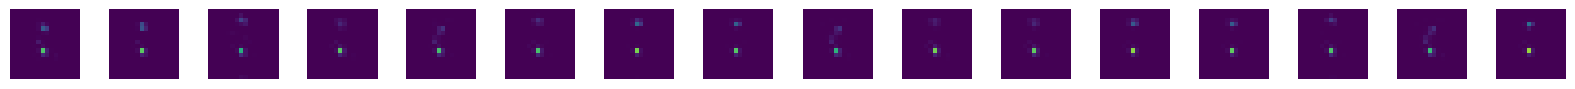

[Epoch 195/300] [D loss: 0.4720] [G loss: 0.2884] [Validity_loss: 0.1896] 
 [Stat_loss: 0.0876] [NNZ_loss: 0.0111]
Sample feature coding: [1.         0.7582179  0.7095769  0.57289165 0.3594202  0.01065303
 0.03558075 0.00392484 0.03245562]


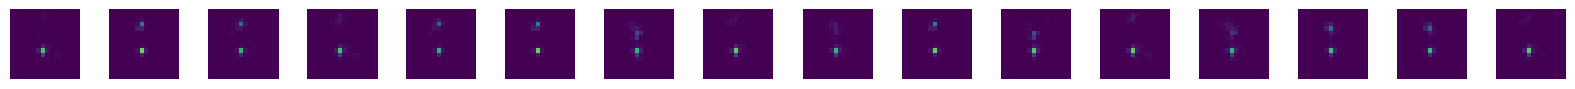

[Epoch 196/300] [D loss: 0.4553] [G loss: 0.2704] [Validity_loss: 0.1704] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0118]
Sample feature coding: [ 1.         -0.06793231  0.78750974  0.05615644  0.9574431   0.00934364
  0.09409162  0.00383457  0.04735855]


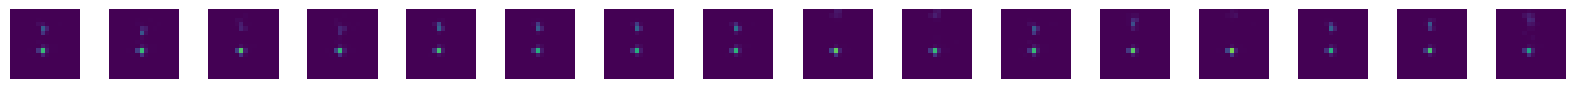

[Epoch 197/300] [D loss: 0.4312] [G loss: 0.3135] [Validity_loss: 0.2143] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0111]
Sample feature coding: [ 1.         -1.342617    0.677837    0.15884373  0.93996596  0.00818907
  0.07396144  0.00349754  0.02341145]


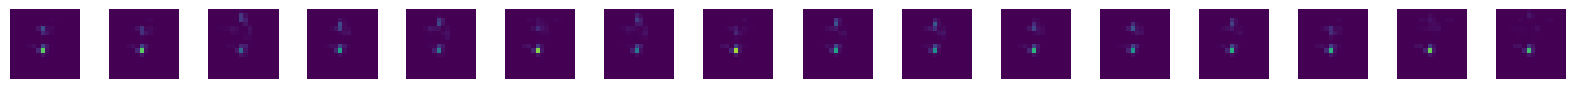

[Epoch 198/300] [D loss: 0.4141] [G loss: 0.3050] [Validity_loss: 0.2013] 
 [Stat_loss: 0.0931] [NNZ_loss: 0.0107]
Sample feature coding: [ 0.         -0.405002    0.07896422  0.7141758   0.66333246  0.00954563
  0.04386621  0.00380878  0.03814173]


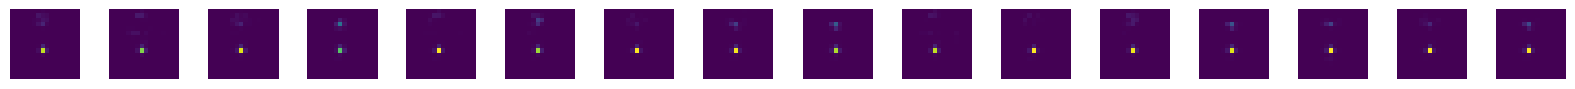

[Epoch 199/300] [D loss: 0.4658] [G loss: 0.2670] [Validity_loss: 0.1668] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0122]
Sample feature coding: [1.         0.955573   0.7885438  0.38982472 0.6571035  0.01031157
 0.04383338 0.00393558 0.02406719]


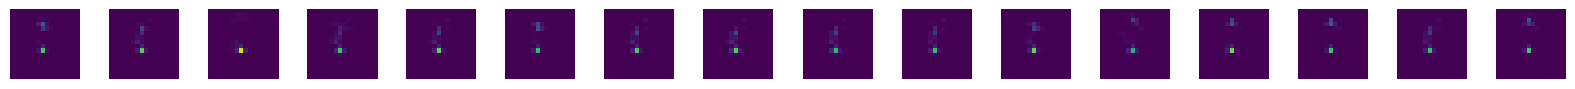

[Epoch 200/300] [D loss: 0.3798] [G loss: 0.3699] [Validity_loss: 0.2654] 
 [Stat_loss: 0.0933] [NNZ_loss: 0.0112]
Sample feature coding: [0.         0.5978639  0.13358973 0.17440853 0.53929096 0.00933866
 0.06714593 0.00395141 0.02298056]


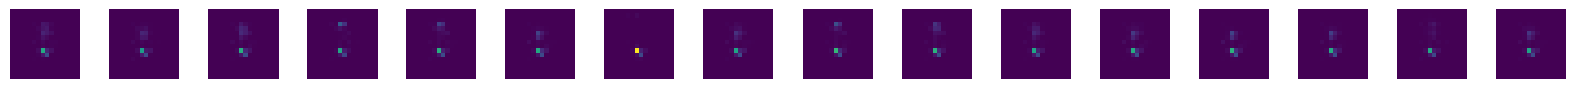

[Epoch 201/300] [D loss: 0.4265] [G loss: 0.2983] [Validity_loss: 0.1991] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0109]
Sample feature coding: [ 0.         -1.5587771   0.78496146  0.88564193  0.93693745  0.00874516
  0.07136361  0.00393382  0.03422452]


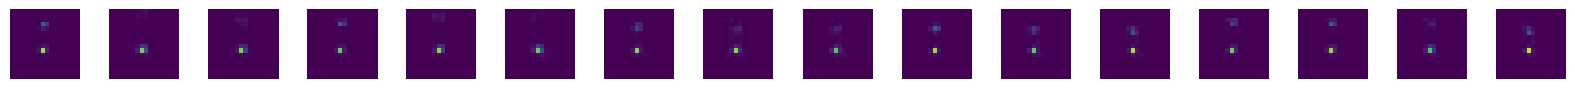

[Epoch 202/300] [D loss: 0.4270] [G loss: 0.2648] [Validity_loss: 0.1651] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0113]
Sample feature coding: [0.         0.5364094  0.4690508  0.6387686  0.80356055 0.00788798
 0.06070705 0.00372555 0.03278653]


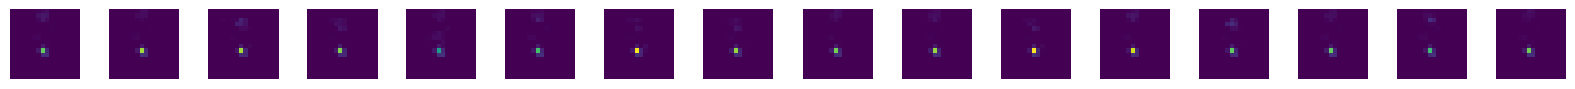

[Epoch 203/300] [D loss: 0.5417] [G loss: 0.4891] [Validity_loss: 0.2097] 
 [Stat_loss: 0.2616] [NNZ_loss: 0.0177]
Sample feature coding: [ 0.         -0.45389116  0.2761108   0.9338498   0.5863483   0.009573
  0.06774803  0.00396217  0.02822229]


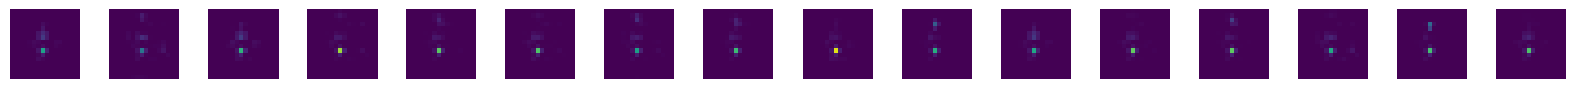

[Epoch 204/300] [D loss: 0.5147] [G loss: 0.2704] [Validity_loss: 0.1708] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0112]
Sample feature coding: [1.         1.6584097  0.9764304  0.32493734 0.81383455 0.00825771
 0.05830786 0.0038379  0.0406861 ]


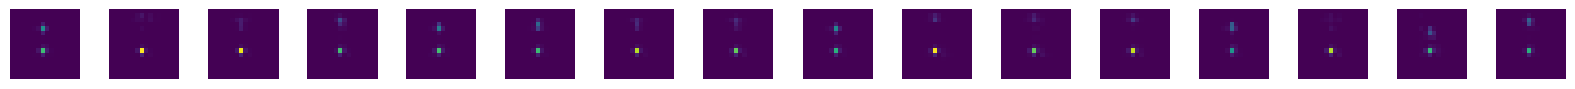

[Epoch 205/300] [D loss: 0.4343] [G loss: 0.2878] [Validity_loss: 0.1888] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0108]
Sample feature coding: [ 1.         -0.06410957  0.7076641   0.23849086  0.7261516   0.00968097
  0.06434305  0.00411144  0.02849716]


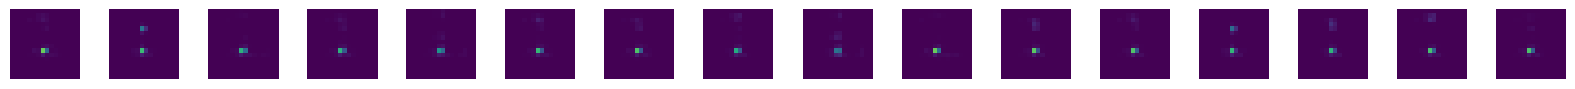

[Epoch 206/300] [D loss: 0.5036] [G loss: 0.2952] [Validity_loss: 0.1939] 
 [Stat_loss: 0.0879] [NNZ_loss: 0.0135]
Sample feature coding: [0.         2.0130324  0.8076804  0.5990636  0.30962124 0.01037649
 0.0601637  0.00412655 0.02338249]


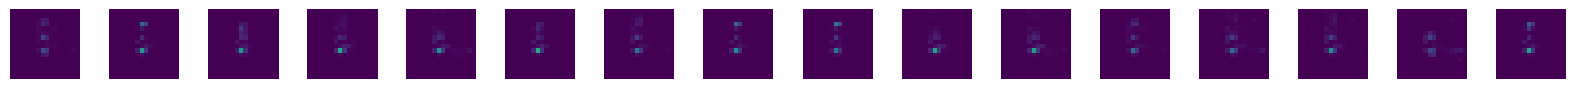

[Epoch 207/300] [D loss: 0.4655] [G loss: 0.2837] [Validity_loss: 0.1834] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0120]
Sample feature coding: [0.         0.8848109  0.23103918 0.31853813 0.3337845  0.00873587
 0.08519153 0.00361827 0.0236259 ]


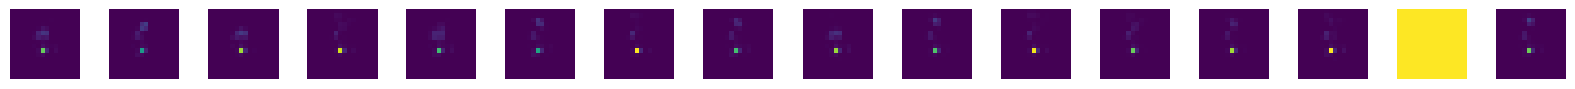

[Epoch 208/300] [D loss: 0.4940] [G loss: 0.2679] [Validity_loss: 0.1665] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0132]
Sample feature coding: [ 1.         -1.6728661   0.37271044  0.22169241  0.5571829   0.01053346
  0.06365782  0.0036296   0.02873872]


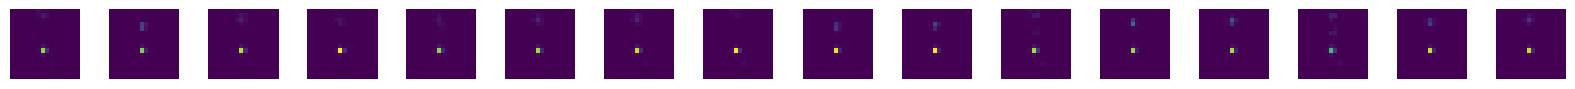

[Epoch 209/300] [D loss: 0.4483] [G loss: 0.2740] [Validity_loss: 0.1736] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0121]
Sample feature coding: [ 0.         -0.8323233   0.03006023  0.29809278  0.59015286  0.00969643
  0.06325663  0.00415683  0.01856396]


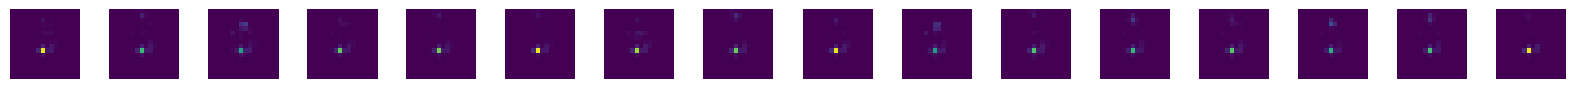

[Epoch 210/300] [D loss: 0.4948] [G loss: 0.2672] [Validity_loss: 0.1675] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0114]
Sample feature coding: [ 0.         -0.17732106  0.7919562   0.93672884  0.5462667   0.00501866
  0.06253108  0.00356672  0.03270338]


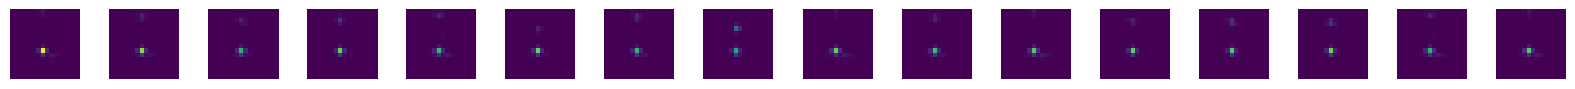

[Epoch 211/300] [D loss: 0.4821] [G loss: 0.2767] [Validity_loss: 0.1769] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0115]
Sample feature coding: [0.         0.82334137 0.18707563 0.22518802 0.40395817 0.01039148
 0.06933706 0.0035626  0.03710089]


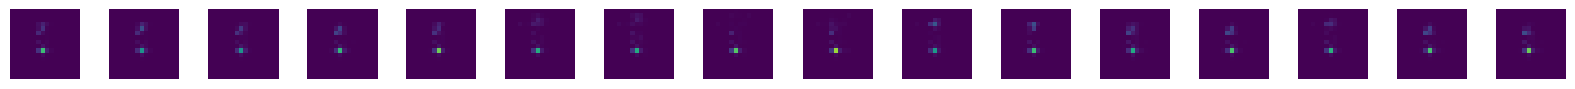

[Epoch 212/300] [D loss: 0.4415] [G loss: 0.2795] [Validity_loss: 0.1799] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0113]
Sample feature coding: [0.         1.3689096  0.38834417 0.6342957  0.60370094 0.0092819
 0.04587744 0.00409388 0.02019473]


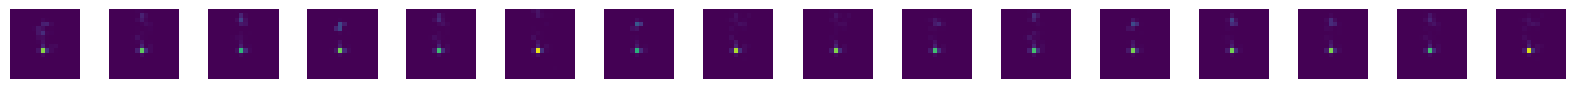

[Epoch 213/300] [D loss: 0.4387] [G loss: 0.2713] [Validity_loss: 0.1709] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0121]
Sample feature coding: [0.         0.31307745 0.55759525 0.2734105  0.5538968  0.00900391
 0.03047459 0.00367788 0.04075031]


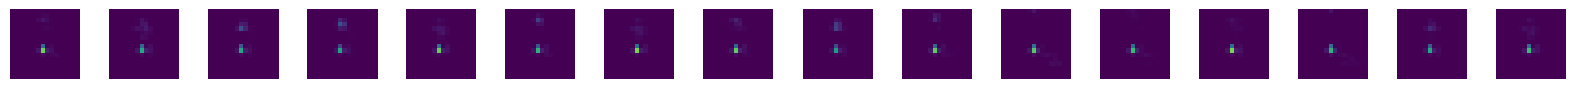

[Epoch 214/300] [D loss: 0.4320] [G loss: 0.2848] [Validity_loss: 0.1851] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0114]
Sample feature coding: [1.         1.3764001  0.1827756  0.11059847 0.5907683  0.01001752
 0.05846686 0.00386642 0.03993634]


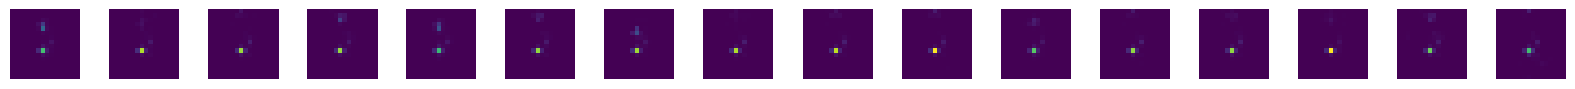

[Epoch 215/300] [D loss: 0.4647] [G loss: 0.2750] [Validity_loss: 0.1736] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0131]
Sample feature coding: [0.         1.2121369  0.0716534  0.4532176  0.7490006  0.0094202
 0.03992689 0.00342089 0.01861871]


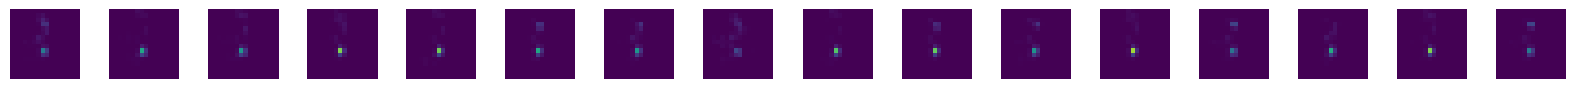

[Epoch 216/300] [D loss: 0.4657] [G loss: 0.2924] [Validity_loss: 0.1921] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0120]
Sample feature coding: [ 0.         -0.18061809  0.05337721  0.27241972  0.97793597  0.00988047
  0.07078887  0.00411822  0.02334295]


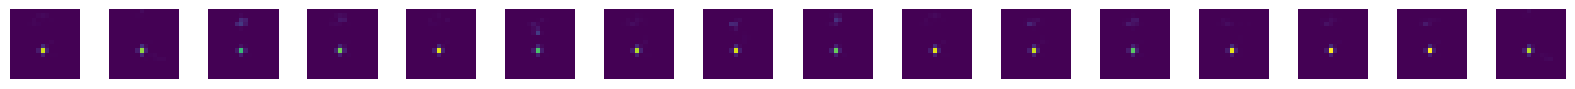

[Epoch 217/300] [D loss: 0.4313] [G loss: 0.2867] [Validity_loss: 0.1853] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0132]
Sample feature coding: [ 0.         -0.72486585  0.9839928   0.37606978  0.5060738   0.00722886
  0.05500302  0.00423732  0.03147284]


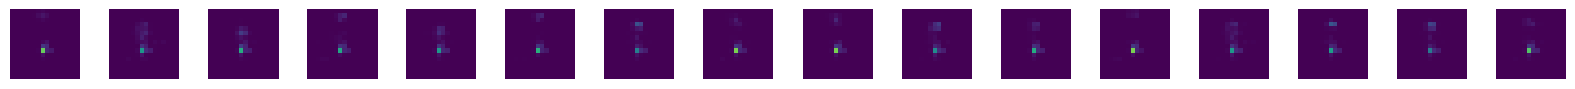

[Epoch 218/300] [D loss: 0.4681] [G loss: 0.2935] [Validity_loss: 0.1931] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0122]
Sample feature coding: [0.         0.8715031  0.46787894 0.41165656 0.5893266  0.00863506
 0.05748672 0.00381301 0.02770514]


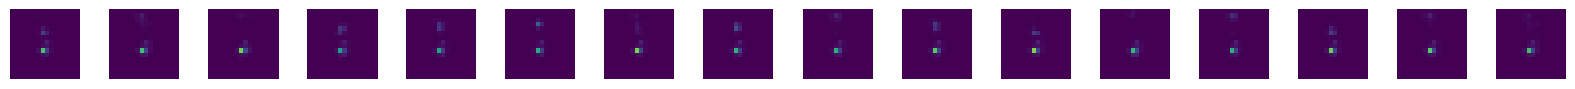

[Epoch 219/300] [D loss: 0.3858] [G loss: 0.3085] [Validity_loss: 0.2085] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0117]
Sample feature coding: [ 1.         -1.1566972   0.39407468  0.34479436  0.32923275  0.0080368
  0.06922463  0.00380781  0.02222057]


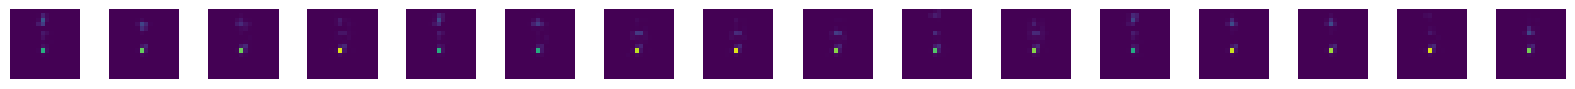

[Epoch 220/300] [D loss: 0.4611] [G loss: 0.3142] [Validity_loss: 0.2138] 
 [Stat_loss: 0.0902] [NNZ_loss: 0.0102]
Sample feature coding: [1.         0.70246804 0.47881824 0.5242544  0.9734693  0.00807568
 0.05030521 0.00362145 0.02845778]


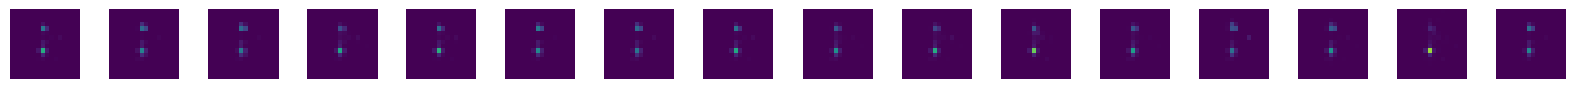

[Epoch 221/300] [D loss: 0.4550] [G loss: 0.2846] [Validity_loss: 0.1852] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0112]
Sample feature coding: [1.         1.4022704  0.22408563 0.56258667 0.5778695  0.00687242
 0.06531419 0.00418971 0.0368565 ]


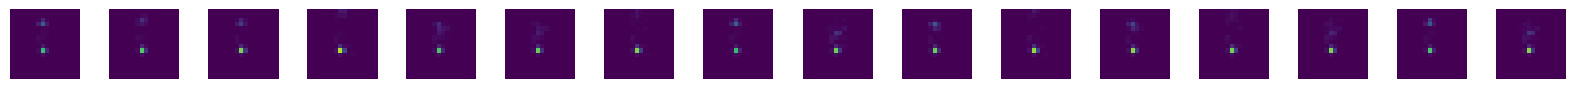

[Epoch 222/300] [D loss: 0.4592] [G loss: 0.2904] [Validity_loss: 0.1920] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0101]
Sample feature coding: [0.         1.5526583  0.66125906 0.97869265 0.7648748  0.01010797
 0.06543566 0.00309084 0.03164517]


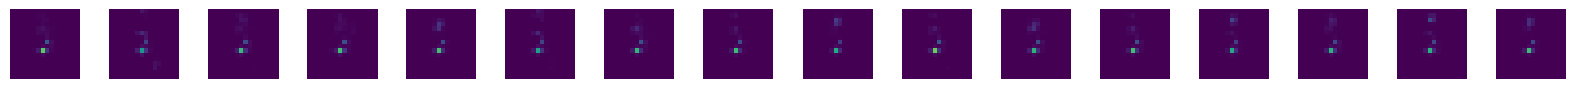

[Epoch 223/300] [D loss: 0.4675] [G loss: 0.3999] [Validity_loss: 0.2028] 
 [Stat_loss: 0.1795] [NNZ_loss: 0.0175]
Sample feature coding: [0.         1.3689594  0.4426205  0.4792498  0.8064741  0.00800038
 0.04044288 0.00352225 0.03405783]


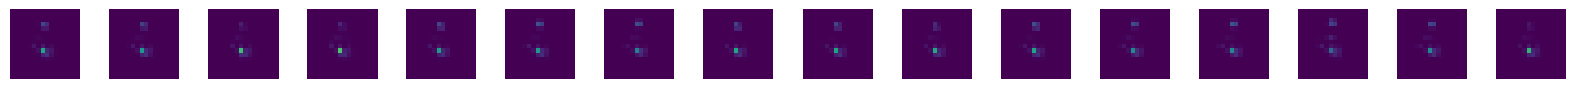

[Epoch 224/300] [D loss: 0.5119] [G loss: 0.2784] [Validity_loss: 0.1787] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0115]
Sample feature coding: [ 0.         -1.5140821   0.56767344  0.40207177  0.48843533  0.01208645
  0.06329283  0.00388958  0.02857467]


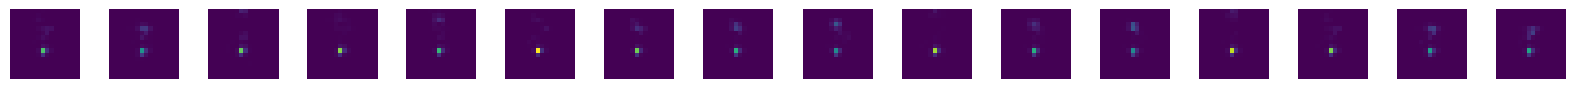

[Epoch 225/300] [D loss: 0.4863] [G loss: 0.4208] [Validity_loss: 0.2021] 
 [Stat_loss: 0.2004] [NNZ_loss: 0.0184]
Sample feature coding: [ 0.         -0.13003299  0.74560416  0.3804265   0.6016406   0.00919477
  0.07162571  0.00356564  0.02776454]


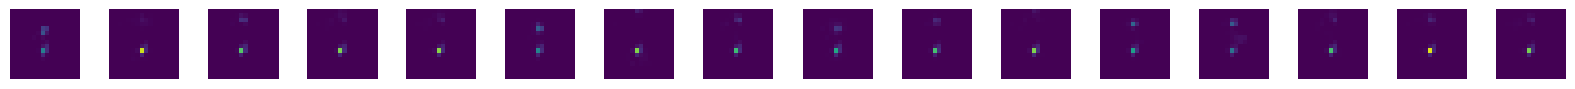

[Epoch 226/300] [D loss: 0.4679] [G loss: 0.2864] [Validity_loss: 0.1864] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0118]
Sample feature coding: [1.         0.41255313 0.19836038 0.50050175 0.6473727  0.00930581
 0.04325564 0.00358099 0.01602582]


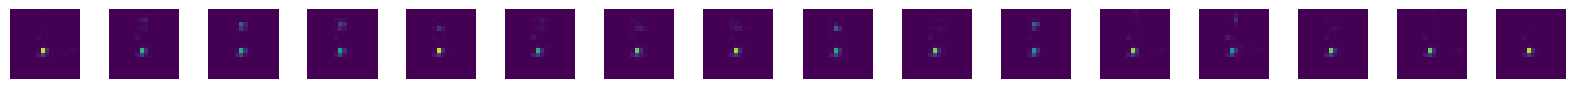

[Epoch 227/300] [D loss: 0.3867] [G loss: 0.3051] [Validity_loss: 0.2046] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0121]
Sample feature coding: [1.         1.1905718  0.07062717 0.6531296  0.56565946 0.00877617
 0.09140026 0.00407553 0.02739438]


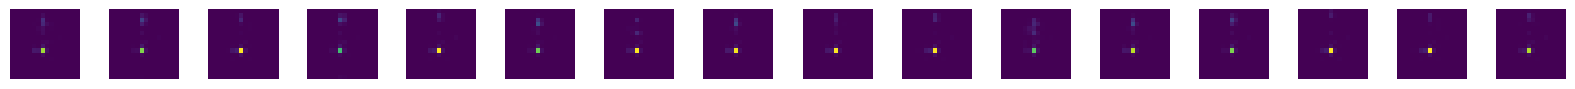

[Epoch 228/300] [D loss: 0.4278] [G loss: 0.2888] [Validity_loss: 0.1898] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0108]
Sample feature coding: [ 0.         -0.52035815  0.7005495   0.4230064   0.58539826  0.00611364
  0.09319257  0.00391545  0.02655529]


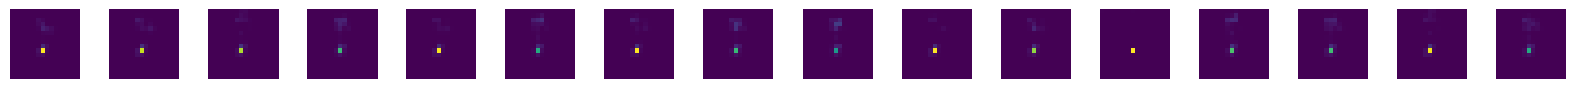

[Epoch 229/300] [D loss: 0.4039] [G loss: 0.2984] [Validity_loss: 0.1985] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0117]
Sample feature coding: [0.         1.1397425  0.9549875  0.34839144 0.45478067 0.0105115
 0.04346422 0.00391787 0.02417128]


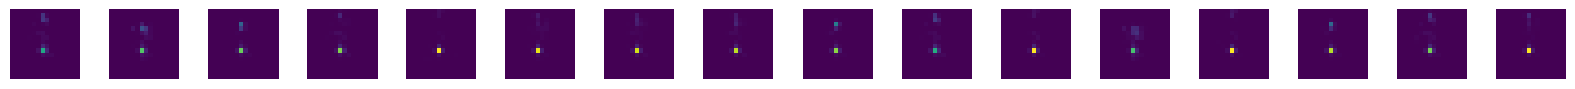

[Epoch 230/300] [D loss: 0.4433] [G loss: 0.4826] [Validity_loss: 0.2043] 
 [Stat_loss: 0.2605] [NNZ_loss: 0.0178]
Sample feature coding: [1.         0.6538283  0.65787053 0.04081476 0.53659093 0.01082809
 0.0561024  0.00382444 0.02664556]


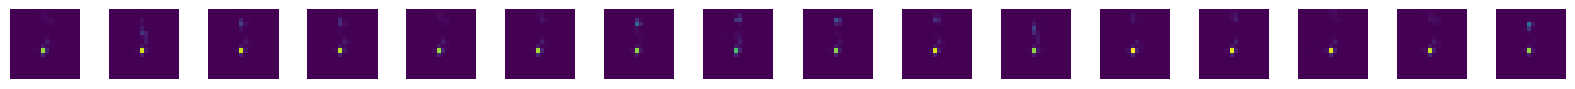

[Epoch 231/300] [D loss: 0.4926] [G loss: 0.2995] [Validity_loss: 0.1947] 
 [Stat_loss: 0.0930] [NNZ_loss: 0.0118]
Sample feature coding: [ 1.         -1.4612558   0.2910508   0.53342116  0.37651706  0.00866691
  0.03633864  0.00372936  0.03172159]


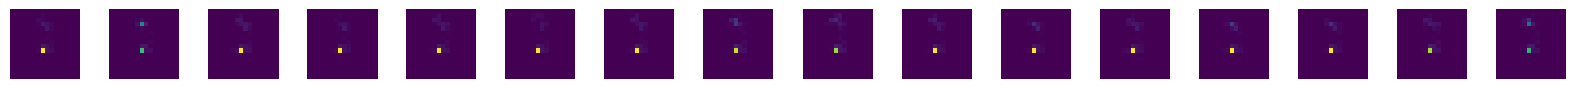

[Epoch 232/300] [D loss: 0.4637] [G loss: 0.2996] [Validity_loss: 0.1991] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0121]
Sample feature coding: [1.         0.861325   0.12329736 0.55363667 0.39566284 0.01066353
 0.03797695 0.00397482 0.01925386]


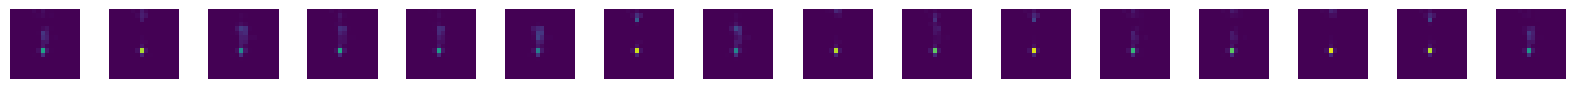

[Epoch 233/300] [D loss: 0.5748] [G loss: 0.2882] [Validity_loss: 0.1884] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0117]
Sample feature coding: [1.         1.6962395  0.7326302  0.4448022  0.41212445 0.00929142
 0.06838351 0.00407914 0.03512116]


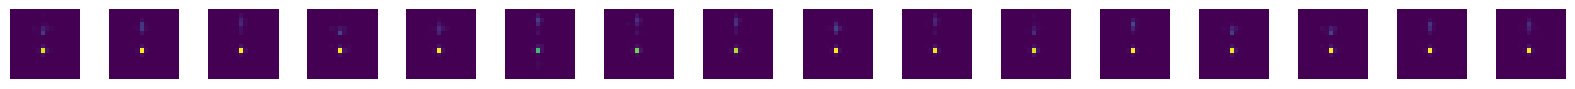

[Epoch 234/300] [D loss: 0.4910] [G loss: 0.2744] [Validity_loss: 0.1749] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0112]
Sample feature coding: [ 1.         -1.6408069   0.39524308  0.5814163   0.61123407  0.00869506
  0.04105756  0.00414272  0.02270319]


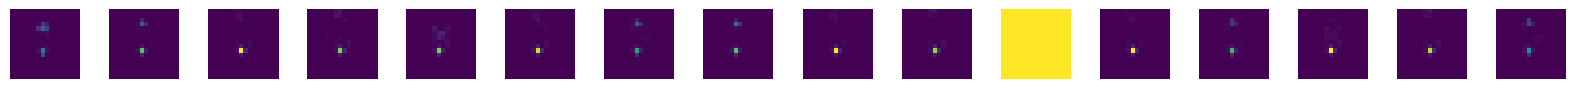

[Epoch 235/300] [D loss: 0.4892] [G loss: 0.2917] [Validity_loss: 0.1934] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0100]
Sample feature coding: [ 1.         -1.5238308   0.03145949  0.8027493   0.8477504   0.00896838
  0.05000466  0.00366011  0.03117998]


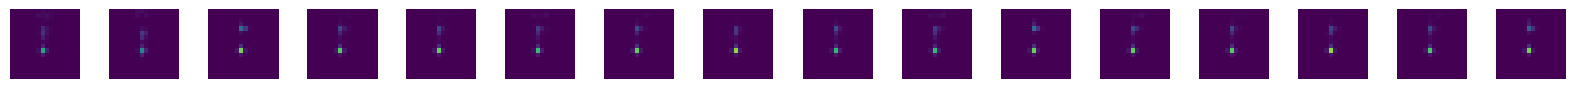

[Epoch 236/300] [D loss: 0.4643] [G loss: 0.2962] [Validity_loss: 0.1898] 
 [Stat_loss: 0.0949] [NNZ_loss: 0.0116]
Sample feature coding: [1.         1.8105506  0.29552895 0.5355077  0.4286403  0.00926392
 0.03791098 0.00321009 0.02878882]


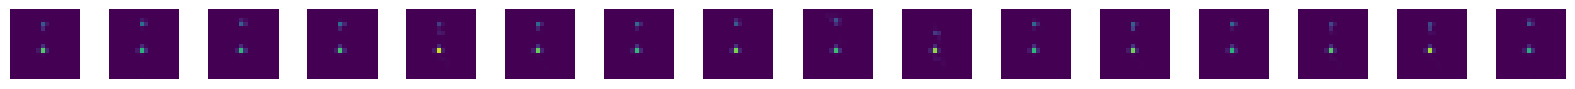

[Epoch 237/300] [D loss: 0.4625] [G loss: 0.2754] [Validity_loss: 0.1746] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0126]
Sample feature coding: [1.         0.34983906 0.47503018 0.5083645  0.6864614  0.00934096
 0.06405293 0.0038636  0.03432475]


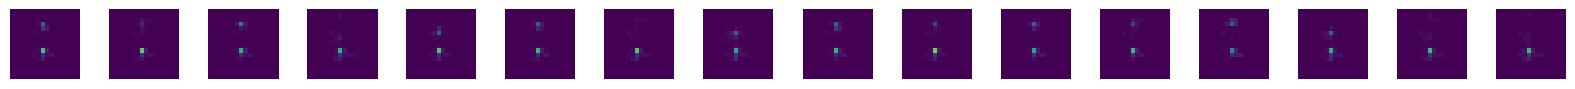

[Epoch 238/300] [D loss: 0.4515] [G loss: 0.3320] [Validity_loss: 0.2120] 
 [Stat_loss: 0.1084] [NNZ_loss: 0.0116]
Sample feature coding: [1.         0.50371975 0.10147375 0.5611243  0.9039982  0.0099213
 0.03993569 0.00370145 0.02171005]


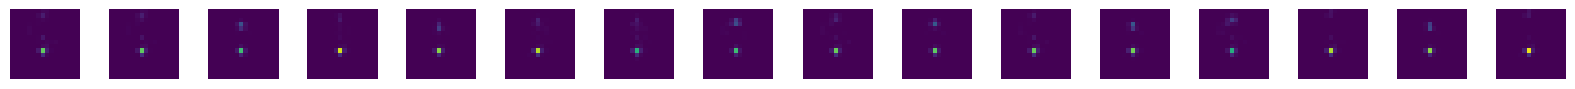

[Epoch 239/300] [D loss: 0.4767] [G loss: 0.2806] [Validity_loss: 0.1808] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0116]
Sample feature coding: [0.         1.0057247  0.80780923 0.3202179  0.53811085 0.01050541
 0.07187101 0.00381305 0.02608361]


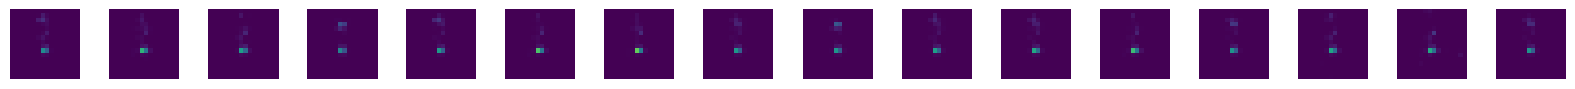

[Epoch 240/300] [D loss: 0.3527] [G loss: 0.4864] [Validity_loss: 0.2106] 
 [Stat_loss: 0.2584] [NNZ_loss: 0.0173]
Sample feature coding: [1.         0.7069996  0.3217385  0.27687684 0.46161237 0.01004853
 0.05529159 0.00349818 0.02480884]


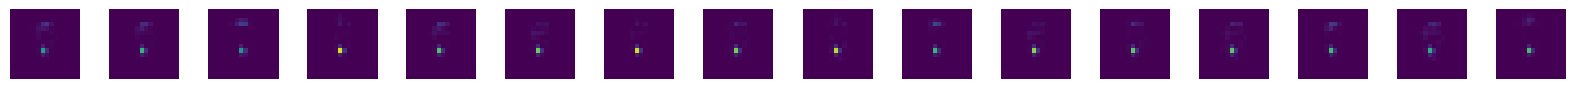

[Epoch 241/300] [D loss: 0.4611] [G loss: 0.3082] [Validity_loss: 0.2084] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0116]
Sample feature coding: [ 1.         -0.7806976   0.9151348   0.4413174   0.73327035  0.00998849
  0.04239405  0.00421939  0.02983816]


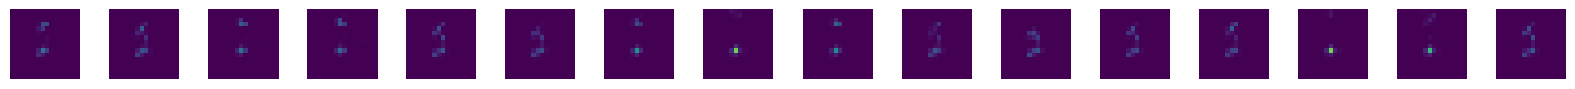

[Epoch 242/300] [D loss: 0.4625] [G loss: 0.4170] [Validity_loss: 0.1826] 
 [Stat_loss: 0.2169] [NNZ_loss: 0.0176]
Sample feature coding: [1.         0.48467577 0.06355952 0.36516523 0.5634536  0.01022539
 0.06391731 0.00405815 0.01487799]


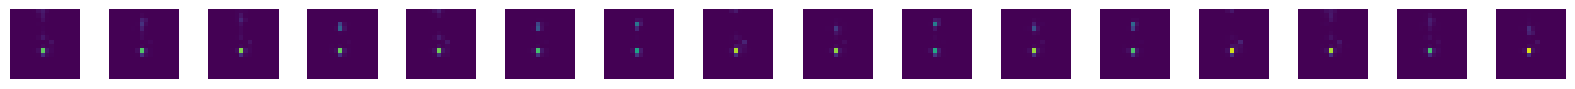

[Epoch 243/300] [D loss: 0.4435] [G loss: 0.3013] [Validity_loss: 0.1932] 
 [Stat_loss: 0.0953] [NNZ_loss: 0.0127]
Sample feature coding: [ 1.         -0.30950662  0.9072495   0.58203197  0.7607586   0.01056811
  0.05745573  0.00367608  0.02617903]


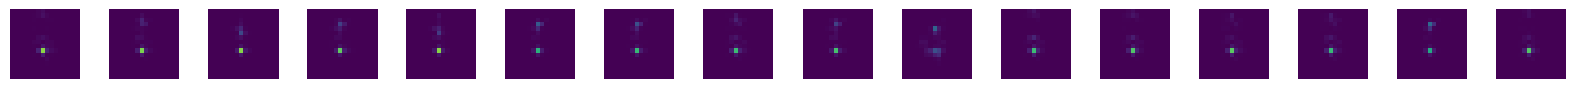

[Epoch 244/300] [D loss: 0.4932] [G loss: 0.2855] [Validity_loss: 0.1858] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0116]
Sample feature coding: [1.         0.9216896  1.0180529  0.5170096  0.5531238  0.00982967
 0.0508861  0.00374942 0.04345349]


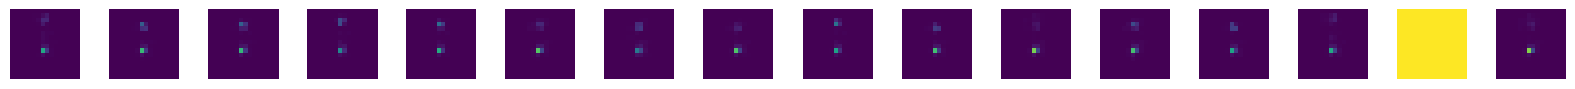

[Epoch 245/300] [D loss: 0.5104] [G loss: 0.2668] [Validity_loss: 0.1678] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0107]
Sample feature coding: [0.         0.81305665 0.92889637 0.3143655  0.7183322  0.01153985
 0.02702983 0.00393112 0.03414344]


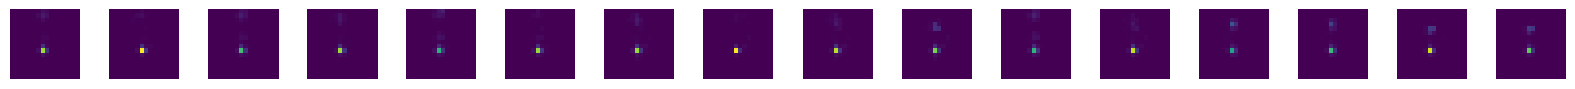

[Epoch 246/300] [D loss: 0.4091] [G loss: 0.2957] [Validity_loss: 0.1948] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0126]
Sample feature coding: [ 1.         -0.47340086  0.571653    0.48093754  0.49976134  0.01101334
  0.0830616   0.00381812  0.01661507]


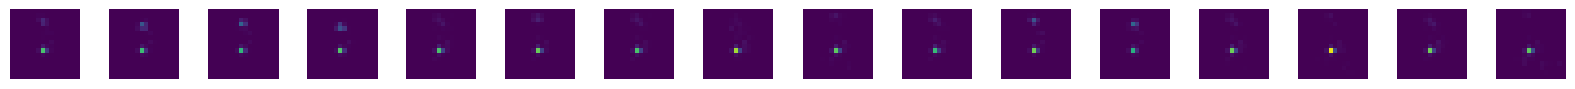

[Epoch 247/300] [D loss: 0.4436] [G loss: 0.2755] [Validity_loss: 0.1760] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0113]
Sample feature coding: [0.         1.3622546  0.919422   0.22264133 0.9496541  0.01208784
 0.06022284 0.00390682 0.01989108]


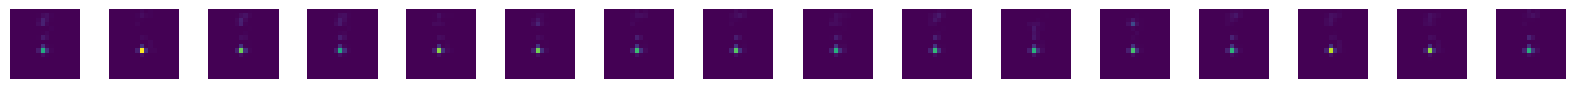

[Epoch 248/300] [D loss: 0.4370] [G loss: 0.3111] [Validity_loss: 0.2043] 
 [Stat_loss: 0.0940] [NNZ_loss: 0.0128]
Sample feature coding: [ 1.         -1.2644993   0.14954433  0.876768    0.4180075   0.0110225
  0.06974316  0.00404411  0.02362541]


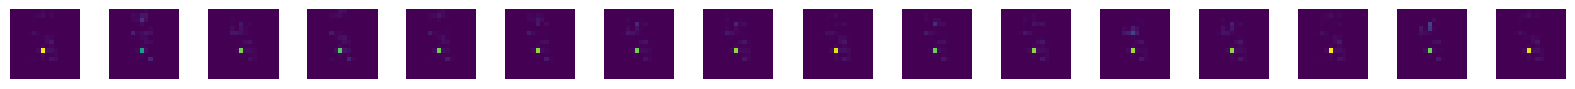

[Epoch 249/300] [D loss: 0.4265] [G loss: 0.3111] [Validity_loss: 0.2105] 
 [Stat_loss: 0.0880] [NNZ_loss: 0.0126]
Sample feature coding: [0.         1.3263179  0.01202937 0.4048183  0.53356504 0.00878745
 0.0307293  0.00359804 0.03631196]


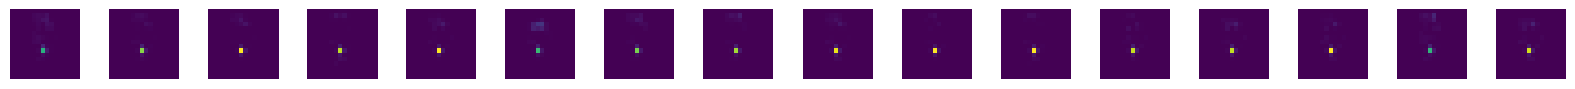

[Epoch 250/300] [D loss: 0.5186] [G loss: 0.3061] [Validity_loss: 0.2060] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0119]
Sample feature coding: [1.         0.11175947 0.87532264 0.42622352 0.95579636 0.00877596
 0.08109717 0.00356311 0.02095013]


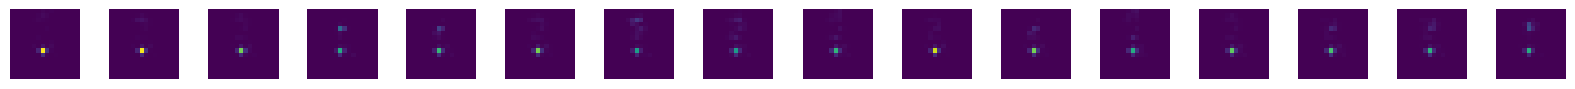

[Epoch 251/300] [D loss: 0.3929] [G loss: 0.3012] [Validity_loss: 0.1979] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0151]
Sample feature coding: [1.         0.448497   0.06446628 0.51196516 0.44786027 0.01070313
 0.04324749 0.00328977 0.03275155]


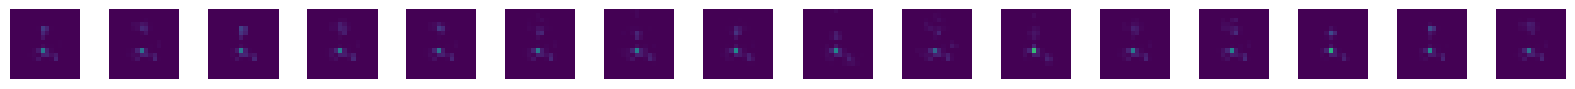

[Epoch 252/300] [D loss: 0.3963] [G loss: 0.4925] [Validity_loss: 0.2225] 
 [Stat_loss: 0.2552] [NNZ_loss: 0.0148]
Sample feature coding: [0.         0.89755005 0.512217   0.44994557 0.90256155 0.00822136
 0.03477436 0.00382207 0.02808642]


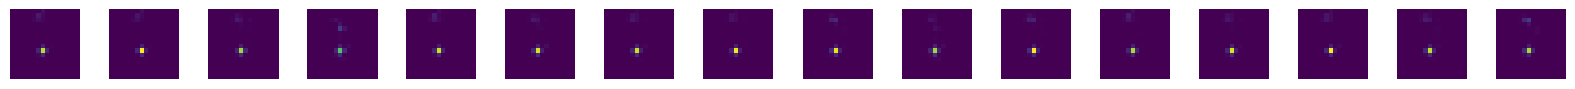

[Epoch 253/300] [D loss: 0.4459] [G loss: 0.2729] [Validity_loss: 0.1740] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0108]
Sample feature coding: [0.         0.30429938 0.5056129  0.48983687 0.48288226 0.01021913
 0.09006201 0.00404533 0.02160826]


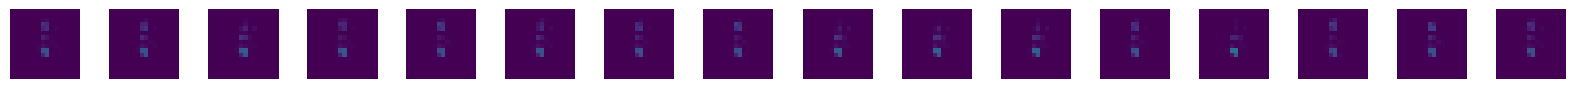

[Epoch 254/300] [D loss: 0.4355] [G loss: 0.3153] [Validity_loss: 0.2105] 
 [Stat_loss: 0.0933] [NNZ_loss: 0.0115]
Sample feature coding: [ 1.         -0.7894538   0.15285118  0.34636065  0.6238592   0.00914906
  0.04462963  0.00361662  0.0475626 ]


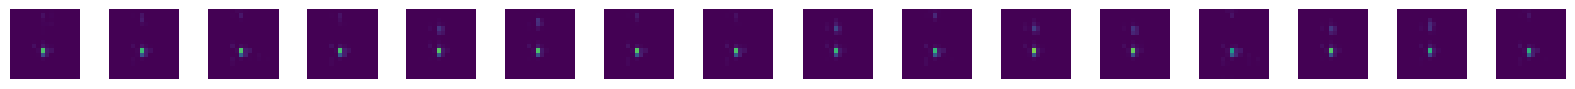

[Epoch 255/300] [D loss: 0.3401] [G loss: 0.3408] [Validity_loss: 0.2401] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0124]
Sample feature coding: [ 0.         -1.3921236   0.44009146  0.35046563  0.7262674   0.00923352
  0.05443678  0.00407094  0.02886421]


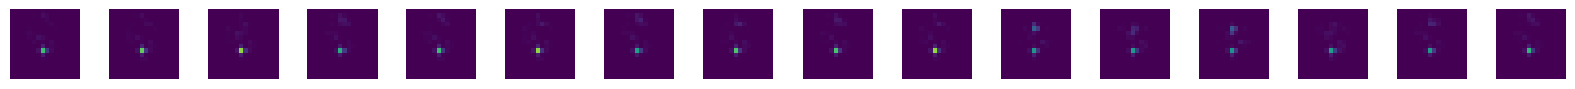

[Epoch 256/300] [D loss: 0.5220] [G loss: 0.2816] [Validity_loss: 0.1818] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0116]
Sample feature coding: [0.         0.78666276 0.6748416  0.8179108  0.72602457 0.00825799
 0.05704412 0.00382869 0.04406646]


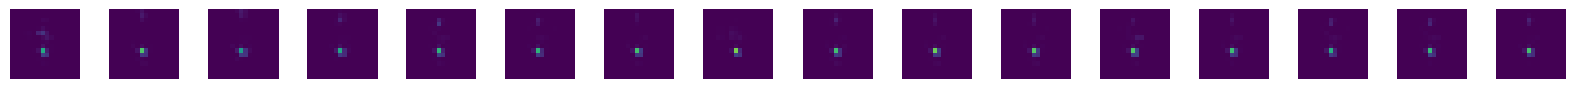

[Epoch 257/300] [D loss: 0.4145] [G loss: 0.3022] [Validity_loss: 0.2049] 
 [Stat_loss: 0.0870] [NNZ_loss: 0.0104]
Sample feature coding: [1.         0.22541653 0.27496022 0.29508576 0.9108799  0.00665112
 0.05864663 0.00362202 0.01664344]


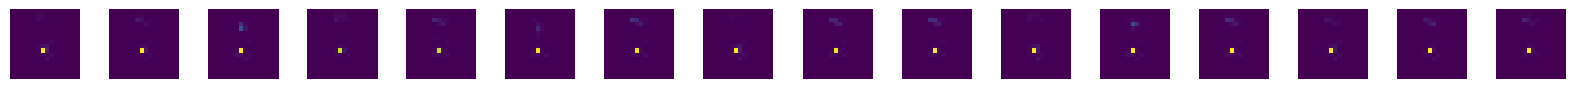

[Epoch 258/300] [D loss: 0.2633] [G loss: 0.3907] [Validity_loss: 0.2870] 
 [Stat_loss: 0.0934] [NNZ_loss: 0.0103]
Sample feature coding: [1.         1.2707072  0.41222712 0.18941996 0.66139644 0.00933293
 0.05819869 0.00414727 0.02835083]


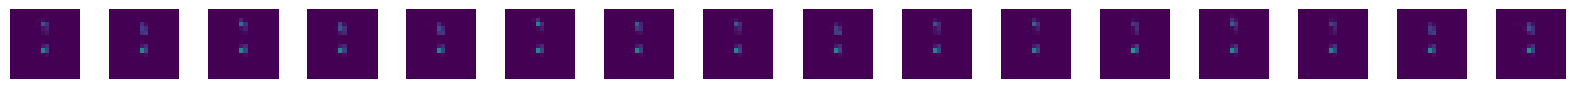

[Epoch 259/300] [D loss: 0.3802] [G loss: 0.3937] [Validity_loss: 0.2425] 
 [Stat_loss: 0.1378] [NNZ_loss: 0.0134]
Sample feature coding: [ 1.         -0.5416726   0.67950815  0.18713017  0.8557757   0.01046409
  0.07103403  0.00358016  0.03013829]


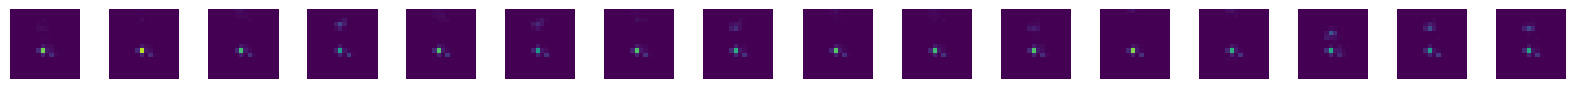

[Epoch 260/300] [D loss: 0.5186] [G loss: 0.3218] [Validity_loss: 0.2171] 
 [Stat_loss: 0.0930] [NNZ_loss: 0.0117]
Sample feature coding: [0.         1.2670856  0.55679905 0.8311926  0.7522999  0.01020683
 0.06250427 0.00409823 0.01451323]


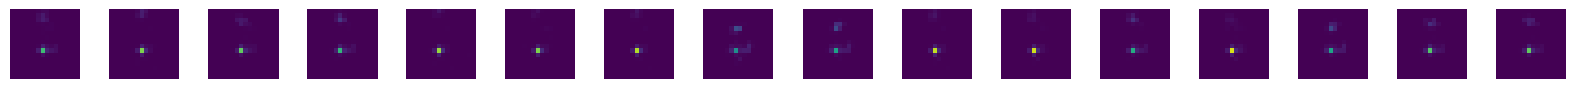

[Epoch 261/300] [D loss: 0.4114] [G loss: 0.3003] [Validity_loss: 0.2000] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0121]
Sample feature coding: [1.         0.22963382 0.61052316 0.49973682 0.8711364  0.00976327
 0.05023531 0.00407633 0.03104433]


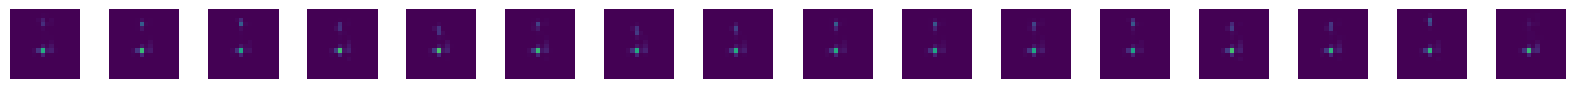

[Epoch 262/300] [D loss: 0.4280] [G loss: 0.3469] [Validity_loss: 0.2399] 
 [Stat_loss: 0.0947] [NNZ_loss: 0.0123]
Sample feature coding: [ 1.         -0.6088406   0.04292927  0.61151135  0.34066308  0.00922442
  0.08740205  0.00393135  0.02653   ]


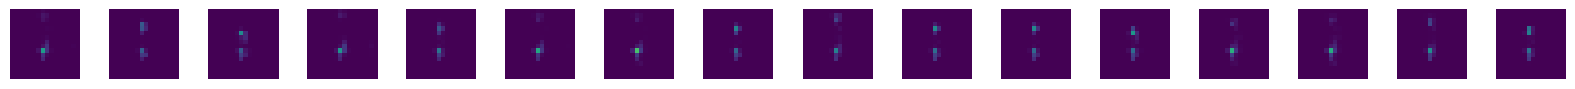

[Epoch 263/300] [D loss: 0.5309] [G loss: 0.2519] [Validity_loss: 0.1519] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0118]
Sample feature coding: [1.         1.781334   0.6281723  0.7717548  0.6142224  0.00933379
 0.02406732 0.00417786 0.05077475]


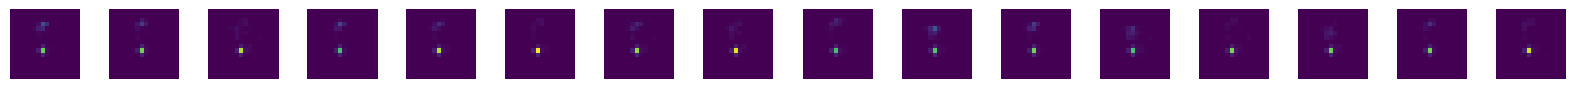

[Epoch 264/300] [D loss: 0.4511] [G loss: 0.2829] [Validity_loss: 0.1830] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0116]
Sample feature coding: [1.         1.2080606  0.8741989  0.2534441  0.445664   0.0124968
 0.04829466 0.00395638 0.02419607]


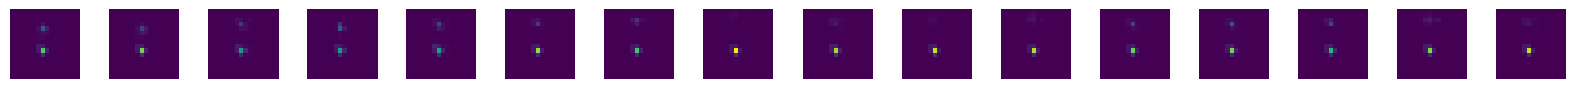

[Epoch 265/300] [D loss: 0.4674] [G loss: 0.3002] [Validity_loss: 0.1997] 
 [Stat_loss: 0.0877] [NNZ_loss: 0.0127]
Sample feature coding: [0.         1.0518433  0.7825722  0.59516484 0.5407914  0.01114275
 0.03636371 0.00360192 0.03323207]


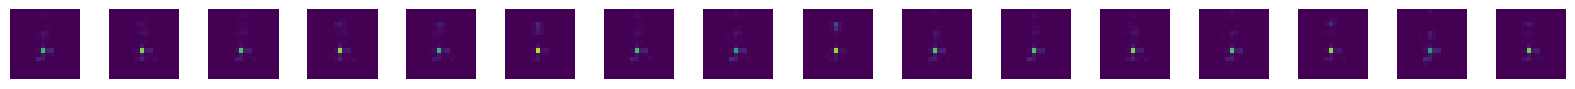

[Epoch 266/300] [D loss: 0.4475] [G loss: 0.2711] [Validity_loss: 0.1718] 
 [Stat_loss: 0.0880] [NNZ_loss: 0.0112]
Sample feature coding: [ 0.         -1.0606754   0.5266928   0.60415274  1.0147706   0.00889601
  0.04063841  0.00387144  0.01841547]


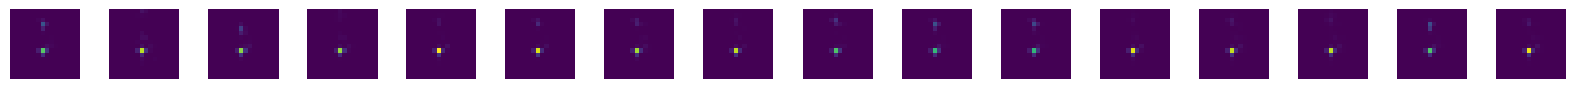

[Epoch 267/300] [D loss: 0.4206] [G loss: 0.3184] [Validity_loss: 0.2179] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0122]
Sample feature coding: [ 1.         -0.43595797  0.7401806   0.28840756  0.5145192   0.00902366
  0.06005444  0.00387318  0.02640814]


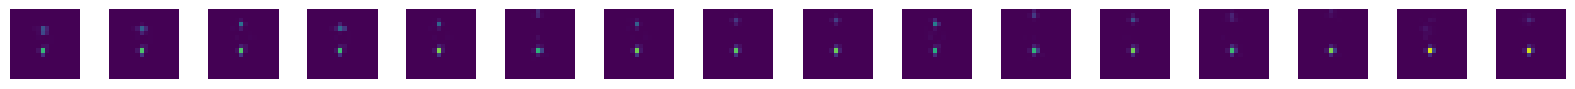

[Epoch 268/300] [D loss: 0.4673] [G loss: 0.2746] [Validity_loss: 0.1741] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0122]
Sample feature coding: [1.         1.65565    0.91831094 0.58129394 0.9123218  0.00930718
 0.05014542 0.00417913 0.05575932]


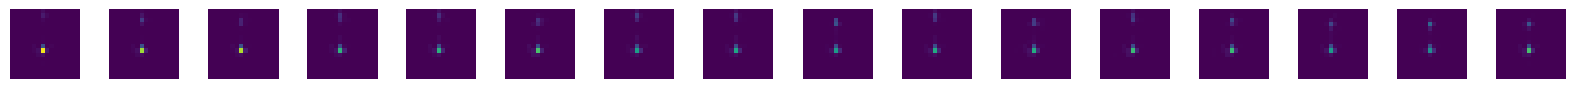

[Epoch 269/300] [D loss: 0.4748] [G loss: 0.2890] [Validity_loss: 0.1900] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0109]
Sample feature coding: [1.         1.1815054  0.25734165 0.73393077 0.47840732 0.00966802
 0.06652292 0.00381512 0.02139021]


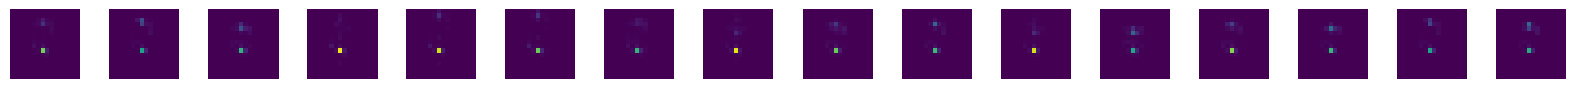

[Epoch 270/300] [D loss: 0.4415] [G loss: 0.3003] [Validity_loss: 0.2010] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0111]
Sample feature coding: [0.         0.8743118  0.9014844  0.3726561  0.64699405 0.00968695
 0.04747833 0.00398014 0.01932538]


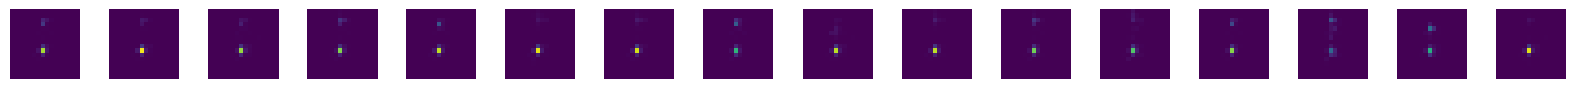

[Epoch 271/300] [D loss: 0.4452] [G loss: 0.3139] [Validity_loss: 0.2135] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0121]
Sample feature coding: [1.         0.05518329 0.09066971 0.3090802  0.62193966 0.0078187
 0.05610769 0.00419018 0.03270335]


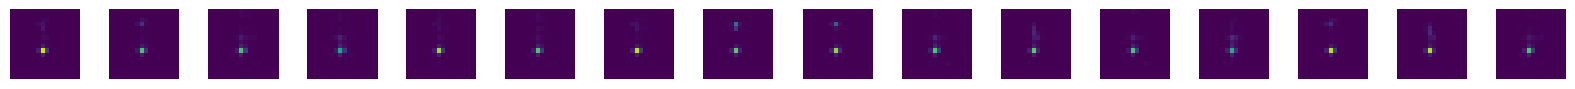

[Epoch 272/300] [D loss: 0.4181] [G loss: 0.3094] [Validity_loss: 0.2099] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0113]
Sample feature coding: [1.         1.4092901  0.7759265  0.39554605 0.93481857 0.00825503
 0.0517924  0.00377497 0.02978721]


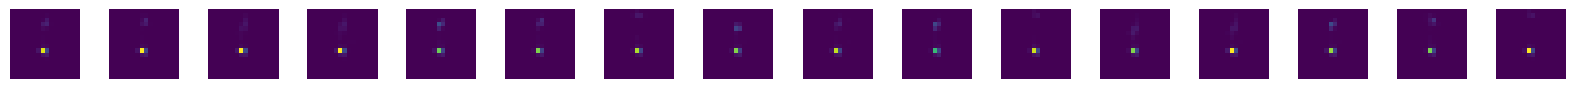

[Epoch 273/300] [D loss: 0.4025] [G loss: 0.2936] [Validity_loss: 0.1923] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0130]
Sample feature coding: [1.         1.4656591  0.9225     0.32706872 0.49990395 0.00855833
 0.05839958 0.00336674 0.01894088]


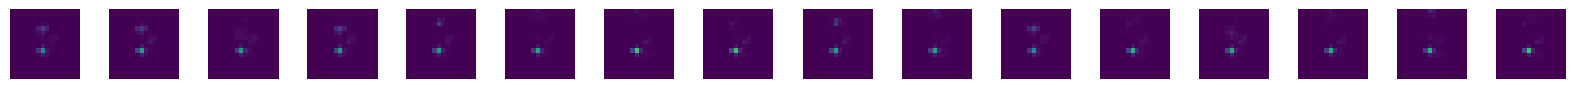

[Epoch 274/300] [D loss: 0.4385] [G loss: 0.2929] [Validity_loss: 0.1930] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0117]
Sample feature coding: [ 1.         -0.89983064  0.28386825  0.32603902  0.6828975   0.00732132
  0.04685296  0.0034713   0.02862801]


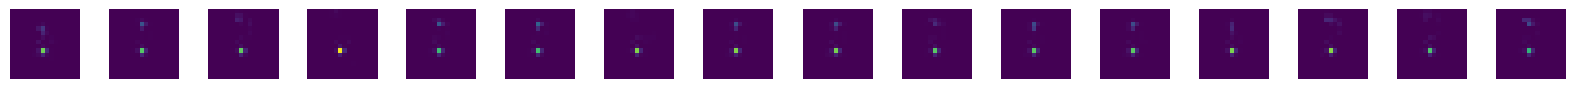

[Epoch 275/300] [D loss: 0.4016] [G loss: 0.3118] [Validity_loss: 0.2122] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0113]
Sample feature coding: [ 0.         -0.28324682  0.29673314  0.5800176   0.37463394  0.01057682
  0.05705328  0.0037742   0.0231598 ]


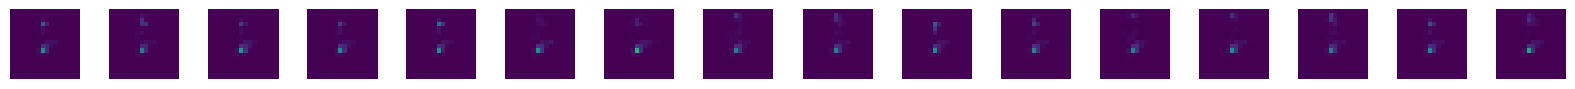

[Epoch 276/300] [D loss: 0.4167] [G loss: 0.3341] [Validity_loss: 0.2231] 
 [Stat_loss: 0.0996] [NNZ_loss: 0.0114]
Sample feature coding: [0.         0.31279743 0.7810831  0.29467088 0.5076224  0.00892151
 0.04859699 0.00392859 0.01547365]


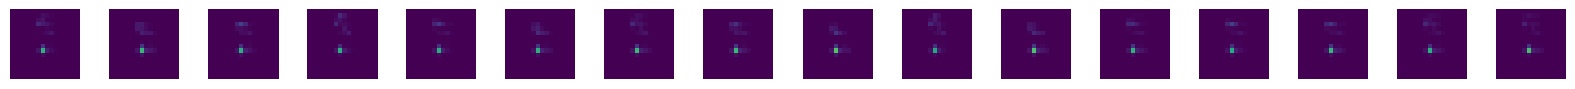

[Epoch 277/300] [D loss: 0.3225] [G loss: 0.3460] [Validity_loss: 0.2452] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0125]
Sample feature coding: [ 1.         -0.6848323   0.74562526  0.65091515  0.5694421   0.01011691
  0.06546573  0.00351818  0.02720178]


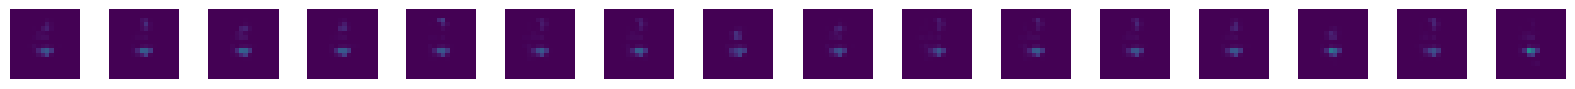

[Epoch 278/300] [D loss: 0.4196] [G loss: 0.3001] [Validity_loss: 0.2001] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0117]
Sample feature coding: [ 0.         -0.51530266  0.13435124  0.15058047  0.6366699   0.00808916
  0.06221233  0.00366906  0.0432872 ]


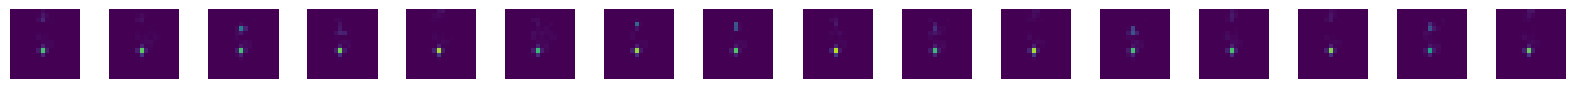

[Epoch 279/300] [D loss: 0.4466] [G loss: 0.3228] [Validity_loss: 0.2235] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0113]
Sample feature coding: [1.         0.21147603 0.50126517 0.4529333  0.857944   0.00861526
 0.07051902 0.00377124 0.04676266]


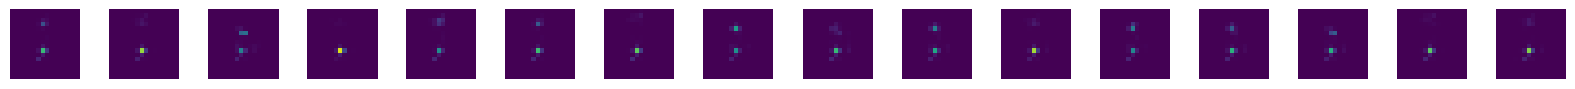

[Epoch 280/300] [D loss: 0.3687] [G loss: 0.3832] [Validity_loss: 0.2532] 
 [Stat_loss: 0.1180] [NNZ_loss: 0.0120]
Sample feature coding: [ 0.         -0.24380487  0.04715244  0.3481359   0.5698411   0.00861073
  0.08003519  0.00390581  0.03383758]


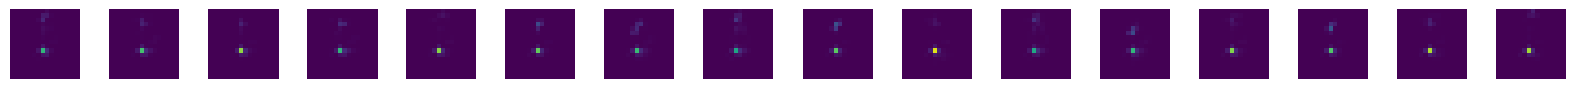

[Epoch 281/300] [D loss: 0.3977] [G loss: 0.3243] [Validity_loss: 0.2240] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0120]
Sample feature coding: [ 1.         -1.435355    0.5781041   0.87761915  0.618952    0.01055199
  0.05796925  0.00393902  0.0266626 ]


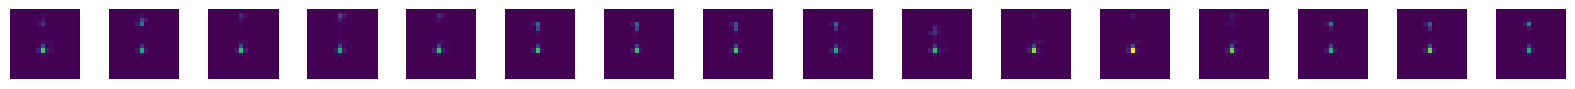

[Epoch 282/300] [D loss: 0.4759] [G loss: 0.3259] [Validity_loss: 0.2274] 
 [Stat_loss: 0.0878] [NNZ_loss: 0.0107]
Sample feature coding: [0.         0.17988259 0.15286025 0.59234446 0.5000035  0.00921065
 0.05701014 0.00360513 0.03272878]


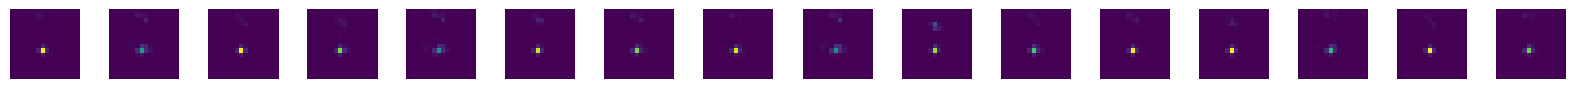

[Epoch 283/300] [D loss: 0.4612] [G loss: 0.2951] [Validity_loss: 0.1965] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0104]
Sample feature coding: [1.         0.18779236 0.47731525 0.02923527 0.93593967 0.00979675
 0.03418043 0.00362909 0.02475723]


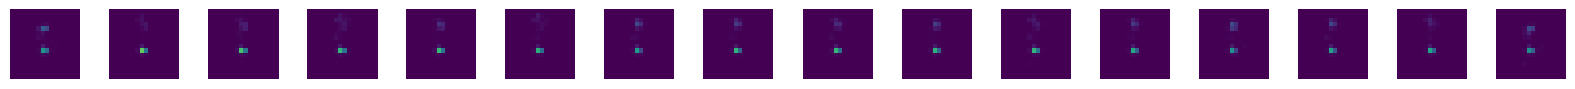

[Epoch 284/300] [D loss: 0.3674] [G loss: 0.3677] [Validity_loss: 0.2350] 
 [Stat_loss: 0.1195] [NNZ_loss: 0.0133]
Sample feature coding: [ 0.         -0.822352    0.41649613  0.03264694  0.8887347   0.00573966
  0.03243638  0.00384351  0.01852655]


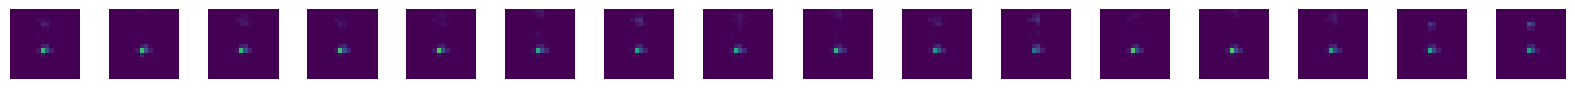

[Epoch 285/300] [D loss: 0.4585] [G loss: 0.2820] [Validity_loss: 0.1821] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0116]
Sample feature coding: [ 1.         -0.9352496   1.0091643   0.47503287  0.50977975  0.00970963
  0.04812662  0.00355616  0.01792751]


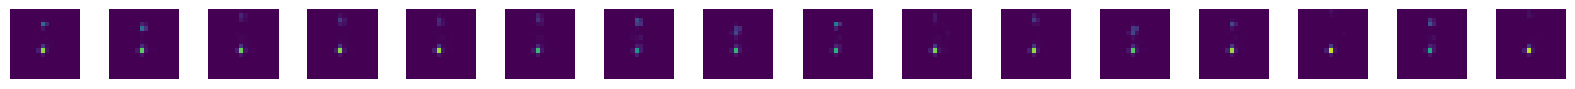

[Epoch 286/300] [D loss: 0.4007] [G loss: 0.3079] [Validity_loss: 0.2085] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0111]
Sample feature coding: [ 1.         -0.2083144   0.52225274  0.01847083  0.40184274  0.01075845
  0.04316879  0.00393768  0.02691404]


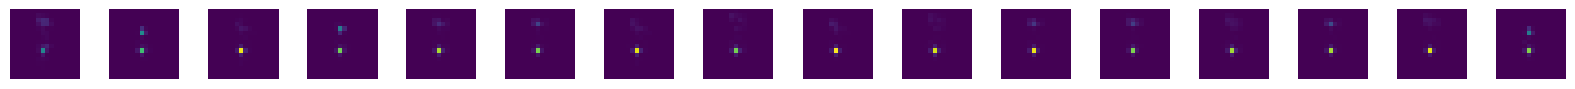

[Epoch 287/300] [D loss: 0.4192] [G loss: 0.3122] [Validity_loss: 0.2136] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0103]
Sample feature coding: [ 1.         -1.7539338   0.12182824  0.469693    0.50574875  0.00951468
  0.07586436  0.00348586  0.02824784]


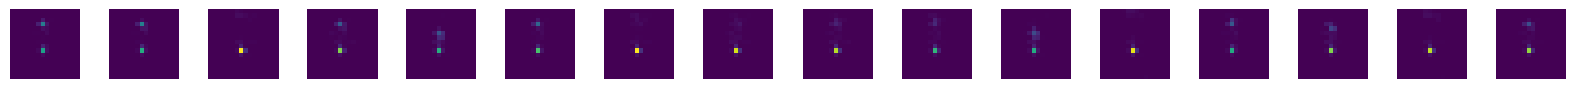

[Epoch 288/300] [D loss: 0.3810] [G loss: 0.4621] [Validity_loss: 0.2169] 
 [Stat_loss: 0.2325] [NNZ_loss: 0.0126]
Sample feature coding: [ 0.         -0.5037036   0.56849426  0.6089666   0.7699278   0.00945077
  0.06793465  0.00399805  0.01696702]


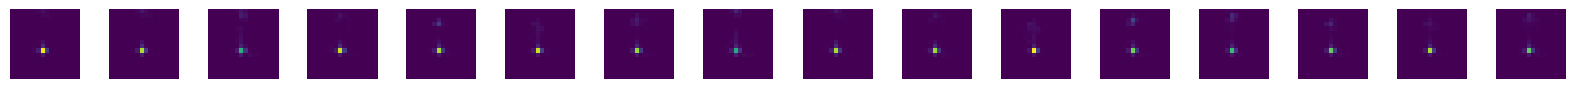

[Epoch 289/300] [D loss: 0.3174] [G loss: 0.3297] [Validity_loss: 0.2290] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0124]
Sample feature coding: [ 0.         -0.03013507  0.01672996  0.30457184  0.83431095  0.00862661
  0.07621478  0.00367826  0.03599091]


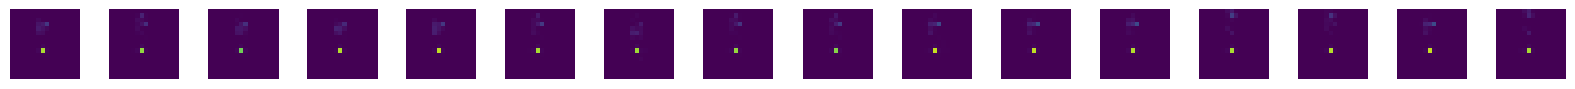

[Epoch 290/300] [D loss: 0.3689] [G loss: 0.3728] [Validity_loss: 0.2657] 
 [Stat_loss: 0.0931] [NNZ_loss: 0.0141]
Sample feature coding: [ 1.         -1.514133    0.59727687  0.33849186  0.86523724  0.00989978
  0.07660485  0.00360154  0.0306673 ]


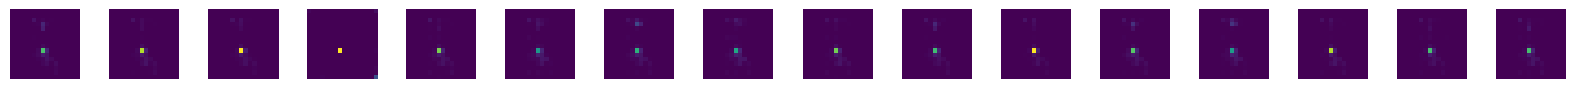

[Epoch 291/300] [D loss: 0.3999] [G loss: 0.2889] [Validity_loss: 0.1887] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0119]
Sample feature coding: [ 0.         -1.3403351   0.5382597   0.5742058   0.40726915  0.01073279
  0.06989685  0.0040814   0.03660773]


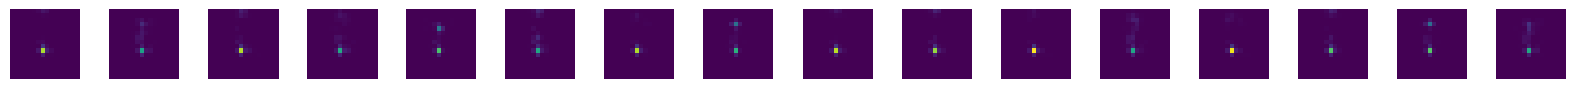

[Epoch 292/300] [D loss: 0.4597] [G loss: 0.2881] [Validity_loss: 0.1885] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0115]
Sample feature coding: [1.         0.0766495  0.71192473 0.5378911  0.36678958 0.00900027
 0.05703608 0.00421383 0.0332257 ]


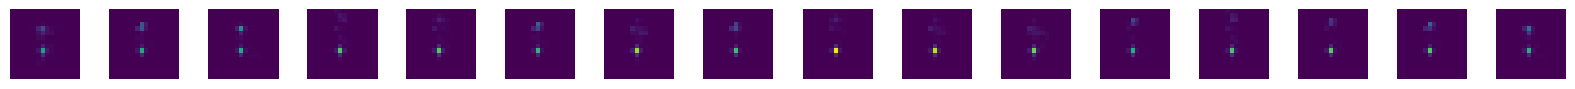

[Epoch 293/300] [D loss: 0.4197] [G loss: 0.3089] [Validity_loss: 0.2092] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0114]
Sample feature coding: [ 1.         -0.0178193   0.23919475  0.4434053   0.6747008   0.00848621
  0.03456129  0.00387691  0.02797202]


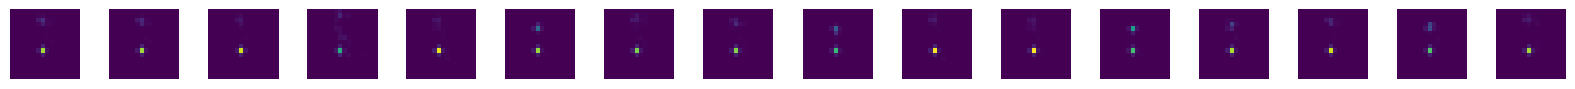

[Epoch 294/300] [D loss: 0.3416] [G loss: 0.3098] [Validity_loss: 0.2112] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0105]
Sample feature coding: [ 1.         -0.9161557   0.66058576  0.60299075  0.49063453  0.00755595
  0.03834098  0.00389916  0.02855218]


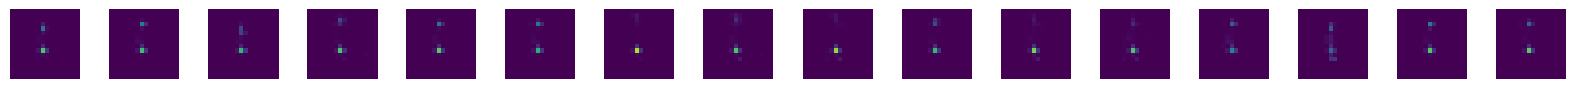

[Epoch 295/300] [D loss: 0.4104] [G loss: 0.3420] [Validity_loss: 0.2319] 
 [Stat_loss: 0.1001] [NNZ_loss: 0.0100]
Sample feature coding: [ 0.         -0.7885443   0.6088669   0.31160957  0.45294243  0.0088147
  0.04627399  0.00360758  0.0368544 ]


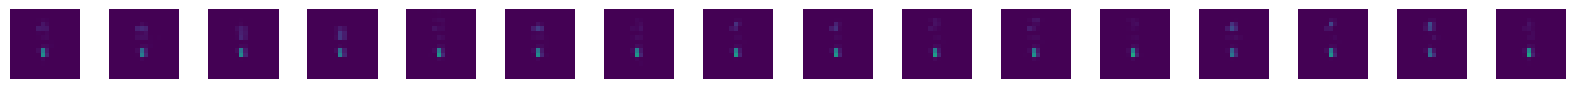

[Epoch 296/300] [D loss: 0.4029] [G loss: 0.2941] [Validity_loss: 0.1949] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0110]
Sample feature coding: [0.         1.0381211  0.92725325 0.46216014 0.8285867  0.00817102
 0.07143191 0.00415238 0.03092225]


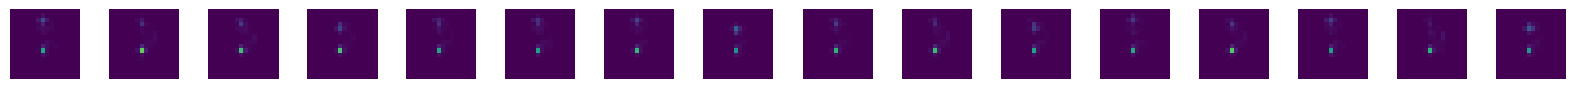

[Epoch 297/300] [D loss: 0.3641] [G loss: 0.2892] [Validity_loss: 0.1894] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0116]
Sample feature coding: [0.         0.5913169  0.35933092 0.44415462 0.35360938 0.00751902
 0.06831461 0.00412429 0.02304771]


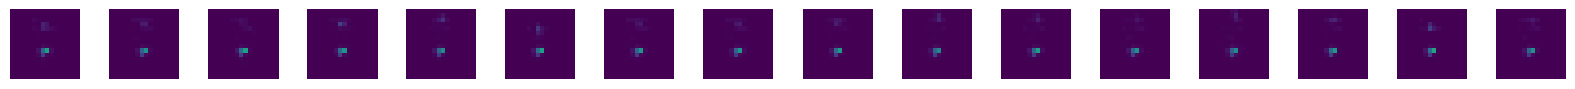

[Epoch 298/300] [D loss: 0.4014] [G loss: 0.3473] [Validity_loss: 0.2491] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0101]
Sample feature coding: [0.         1.1282225  0.5724236  0.49336967 0.81399846 0.00714288
 0.0744792  0.00402855 0.03054821]


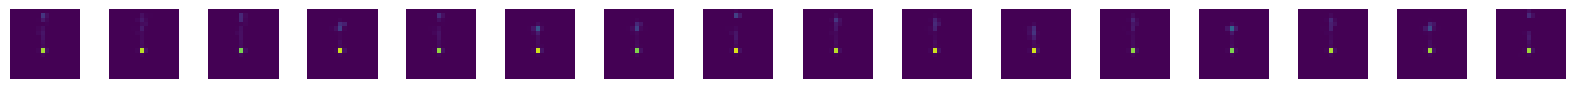

[Epoch 299/300] [D loss: 0.4878] [G loss: 0.3418] [Validity_loss: 0.2423] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0113]
Sample feature coding: [0.         0.87530476 0.97826433 0.54863894 0.558451   0.00818894
 0.05556359 0.00379836 0.03101213]


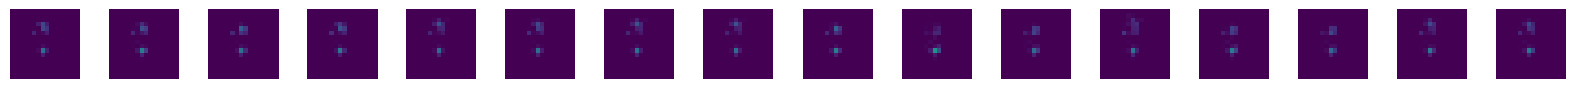

[Epoch 300/300] [D loss: 0.5380] [G loss: 0.2639] [Validity_loss: 0.1633] 
 [Stat_loss: 0.0881] [NNZ_loss: 0.0124]
Sample feature coding: [ 1.         -0.02590223  0.29445297  0.3863853   0.6117084   0.00798793
  0.04565257  0.00386222  0.04601201]


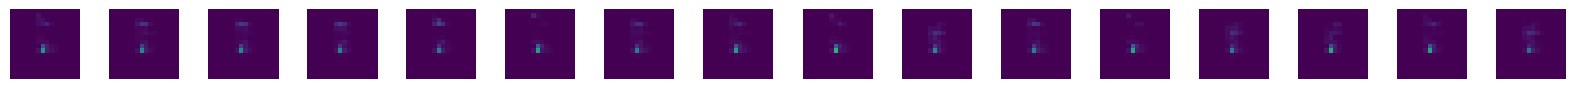

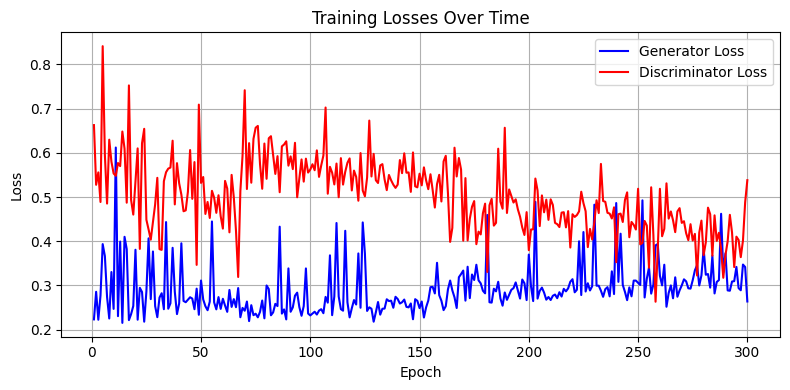

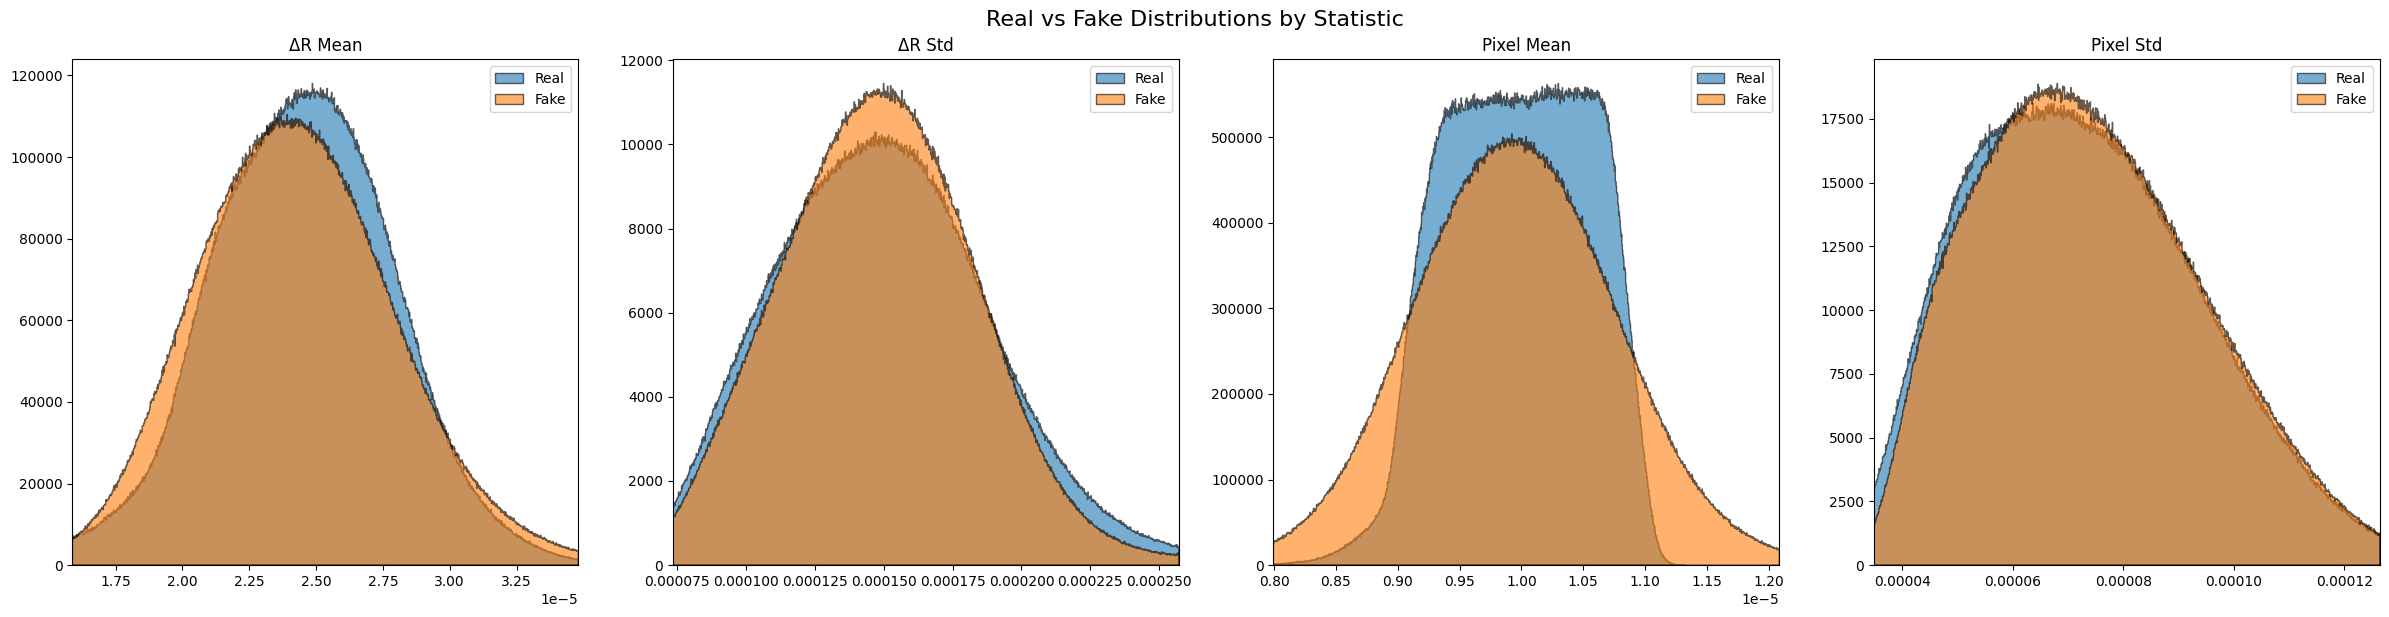

In [5]:
for epoch in range(n_epochs):
    for i, (real_image, real_features, flipped_image, flipped_features) in enumerate(dataloader):
        
        # All real data are normalized in the dataloader
        real_feat = real_features.cuda()
        real_flipped_feat = flipped_features.cuda()
        real_img = real_image.unsqueeze(1).cuda()
        real_flipped_img = flipped_image.unsqueeze(1).cuda()

        # print(f"Real: {real_img.shape}")

        # Codings should be label, eta, pT, mass that get passed directly to the discriminator
        # Other values are pure noise and get passed to the generator, then those outputs passed to the discriminator

        # Discriminator training
        if i % 3 == 0:
            optimizer_D.zero_grad()
            discriminator.train()
            # Generate fake samples
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)
            # print(f"Fake: {fake_img.shape}")

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            real_disc_codings = real_feat[:,:num]
            real_flipped_disc_codings = real_flipped_feat[:,:num]
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]

            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            fake_pred = discriminator(fake_img, fake_disc_codings)
            fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)

            preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)


            # real_labels = torch.empty_like(real_pred).uniform_(0.7, 1.2)
            # fake_labels = torch.empty_like(fake_pred).uniform_(0.0, 0.3)
            # labels = (torch.cat([real_labels, fake_labels], dim=0)).cuda()

            ones = torch.ones(2*len(fake_pred))
            zeros = torch.zeros(2*len(real_pred))
            labels = (torch.cat([ones, zeros], dim=0)).cuda()

            # Discriminator loss is just its ability to distinguish
            d_loss = torch.nn.BCELoss()(preds, labels)

            d_loss.backward()
            optimizer_D.step()

        # Generator Training
        if i % 1 == 0:
            optimizer_G.zero_grad()
            # generator.train()
            
            # Generate fake data
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]
            
            # Fooled discriminator loss
            d_out = discriminator(fake_img, fake_disc_codings)
            d_out_flip = discriminator(fake_flipped_img, fake_flipped_disc_codings)
            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            
            target = torch.ones_like(d_out)
            bce = nn.BCELoss()
            validity_loss = bce(d_out, target) + bce(d_out_flip, target)
            
            # ----- Fake ΔR Calculation -----
            # Original
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_img.squeeze(1)

            dR = (weights * dists)

            fake_dR_mean = dR.mean(dim = (1,2))
            fake_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            fake_pixel_mean = weights.mean(dim = (1,2))
            fake_pixel_std = weights.std(dim = (1,2))
            
            # Flipped
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_flipped_img.squeeze(1)
            dR = (weights * dists)

            flipped_dR_mean = dR.mean(dim = (1,2))
            flipped_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            flipped_pixel_mean = weights.squeeze(1).mean(dim = (1,2))
            flipped_pixel_std = weights.squeeze(1).std(dim = (1,2))

            real_dR_mean = z_codings[:,5]
            real_dR_std = z_codings[:,6]
            real_pixel_mean = z_codings[:,7]
            real_pixel_std = z_codings[:,8]


            # Statistical MSE loss
            # dR_mean_loss = (torch.nn.MSELoss()(fake_dR_mean, real_dR_mean) + torch.nn.MSELoss()(flipped_dR_mean, real_dR_mean))
            # dR_std_loss = (torch.nn.MSELoss()(fake_dR_std, real_dR_std) + torch.nn.MSELoss()(flipped_dR_std, real_dR_std))
            # pixel_mean_loss = (torch.nn.MSELoss()(fake_pixel_mean, real_pixel_mean) + torch.nn.MSELoss()(flipped_pixel_mean, real_pixel_mean))
            # pixel_std_loss = (torch.nn.MSELoss()(fake_pixel_std, real_pixel_std) + torch.nn.MSELoss()(flipped_pixel_std, real_pixel_std))
            
            # stat_loss = dR_mean_loss + dR_std_loss + 3*pixel_mean_loss + 2*pixel_std_loss

            # print(dR_mean_loss)
            # print(dR_std_loss)
            # print(3*pixel_mean_loss)
            # print(2*pixel_std_loss)

            # Statistical KL Divergence loss
            kl_total = 0
            kl_total += kde_kl_divergence_torch(real_dR_mean, fake_dR_mean) / .001
            kl_total += kde_kl_divergence_torch(real_dR_std, fake_dR_std) / .04
            kl_total += kde_kl_divergence_torch(real_pixel_mean, fake_pixel_mean) / .00003
            kl_total += kde_kl_divergence_torch(real_pixel_std, fake_pixel_std) / .007

            stat_loss = kl_total

            # Number non-zero loss
            fake_nnz = soft_count_nonzero(fake_img, threshold=3e-3, sharpness=10000.0)
            real_nnz = soft_count_nonzero(real_img, threshold=3e-3, sharpness=10000.0)
            nnz_loss = torch.nn.MSELoss()(fake_nnz, real_nnz)

            
            # Total generator loss is the average of the discriminator's predictions of the original and flipped data
            # + the difference between input and output dR and pixel statistics

            alpha = .05
            beta = .00005
            chi = .001

            g_loss = (alpha*validity_loss + beta*nnz_loss + chi*stat_loss)

            g_loss.backward()
            optimizer_G.step()

            if n_epochs - epoch <= 10:
                # Track fake stats
                tracked_fake_dR_mean.append(fake_dR_mean.detach().cpu())
                tracked_fake_dR_std.append(fake_dR_std.detach().cpu())
                tracked_fake_pixel_mean.append(fake_pixel_mean.detach().cpu())
                tracked_fake_pixel_std.append(fake_pixel_std.detach().cpu())
                
                # Track real stats from z_codings
                tracked_real_dR_mean.append(z_codings[:,5].detach().cpu())
                tracked_real_dR_std.append(z_codings[:,6].detach().cpu())
                tracked_real_pixel_mean.append(z_codings[:,7].detach().cpu())
                tracked_real_pixel_std.append(z_codings[:,8].detach().cpu())

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[epoch]:.4f}] [G loss: {g_losses[epoch]:.4f}] [Validity_loss: {alpha*validity_loss:.4f}] \n [Stat_loss: {chi*stat_loss:.4f}] [NNZ_loss: {beta*nnz_loss:.4f}]") 

    z_img = torch.randn(batch_size, 256, 1, 1).cuda()

    # Should be very easy to modify which values are passed as codings
    z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                          sample_fit_noise(kdes, num_samples=batch_size)],
                          dim=1).cuda()
    # z_noise = torch.randn(batch_size, 5, ).cuda()
    # z_feat1 = torch.cat([z_codings, z_noise], dim=1)
    z_feat = torch.cat([z_codings], dim=1)

    fake_images = generator(z_feat)
    fake_feat = z_codings
    fake_images.detach().cpu()
    fake_feat.detach().cpu()
    # real_images = next(iter(dataloader))[0][:1000].cpu()

    # output_image = fake_images[:16]  # Save 16 generated samples
    # output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    # grid = (torchvision.utils.make_grid(output_image, nrow=4, normalize=True)).cpu()
    # np_img = grid.permute(1, 2, 0).numpy()
    # plt.imsave(f'classical_Jet_image_epoch_{epoch}.png', np_img)
    plot_generated_samples(generator,dataset, kdes, batch_size=16, latent_dim=256)

plot_metrics(g_losses, d_losses)

## Last 10 epochs stats
# Flatten all batches
fake_dR_mean_vals = torch.cat(tracked_fake_dR_mean).numpy() / batch_size
fake_dR_std_vals = torch.cat(tracked_fake_dR_std).numpy() / batch_size
fake_pixel_mean_vals = torch.cat(tracked_fake_pixel_mean).numpy() / batch_size
fake_pixel_std_vals = torch.cat(tracked_fake_pixel_std).numpy() / batch_size

real_dR_mean_vals = torch.cat(tracked_real_dR_mean).numpy() / batch_size
real_dR_std_vals = torch.cat(tracked_real_dR_std).numpy() / batch_size
real_pixel_mean_vals = torch.cat(tracked_real_pixel_mean).numpy() / batch_size
real_pixel_std_vals = torch.cat(tracked_real_pixel_std).numpy() / batch_size

fig, axs = plt.subplots(1, 4, figsize=(24, 6))  # 4 stats

stat_titles = ['ΔR Mean', 'ΔR Std', 'Pixel Mean', 'Pixel Std']
real_stats = [real_dR_mean_vals, real_dR_std_vals, real_pixel_mean_vals, real_pixel_std_vals]
fake_stats = [fake_dR_mean_vals, fake_dR_std_vals, fake_pixel_mean_vals, fake_pixel_std_vals]

for row in range(4):
    ax = axs[row]

    real_vals = real_stats[row]
    fake_vals = fake_stats[row]

    # Compute limits
    lower = min(np.percentile(real_vals, 1), np.percentile(fake_vals, 1))
    upper = max(np.percentile(real_vals, 99), np.percentile(fake_vals, 99))

    # Truncate values
    real_vals_trunc = real_vals[(real_vals >= lower) & (real_vals <= upper)]
    fake_vals_trunc = fake_vals[(fake_vals >= lower) & (fake_vals <= upper)]

    # Plot
    ax.hist(real_vals_trunc, bins=1000, alpha=0.6, label='Real',
            edgecolor='black', density=True, histtype='stepfilled')
    ax.hist(fake_vals_trunc, bins=1000, alpha=0.6, label='Fake',
            edgecolor='black', density=True, histtype='stepfilled')

    ax.set_xlim(lower, upper)
    ax.set_title(f"{stat_titles[row]}")
    ax.legend()

plt.tight_layout()
plt.suptitle("Real vs Fake Distributions by Statistic", fontsize=16, y=1.02)
plt.show()

## Save Model
# Create output directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Timestamp for unique filenames
timestamp = datetime.now().strftime("m%d_%H%M)

# Save model states and tracked data in a single file
save_path = f"models/class_gan_model_{timestamp}.pt"
torch.save({
    "generator_state_dict": generator.state_dict(),
    "discriminator_state_dict": discriminator.state_dict(),
    "g_losses": g_losses,
    "d_losses": d_losses,
    "tracked_fake_dR_mean": tracked_fake_dR_mean,
    "tracked_fake_dR_std": tracked_fake_dR_std,
    "tracked_fake_pixel_mean": tracked_fake_pixel_mean,
    "tracked_fake_pixel_std": tracked_fake_pixel_std,
    "tracked_real_dR_mean": tracked_real_dR_mean,
    "tracked_real_dR_std": tracked_real_dR_std,
    "tracked_real_pixel_mean": tracked_real_pixel_mean,
    "tracked_real_pixel_std": tracked_real_pixel_std
}, save_path)

print(f"Model and statistics saved to {save_path}")

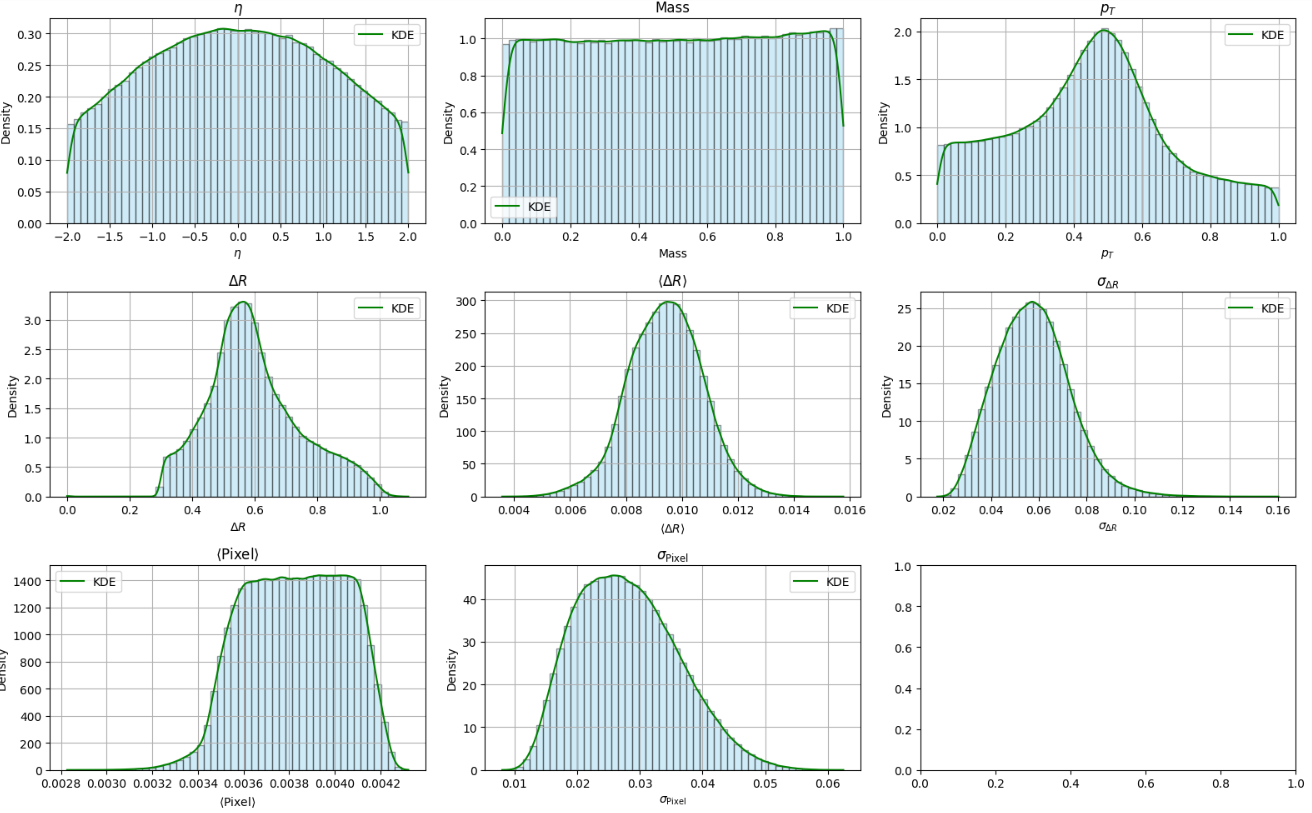

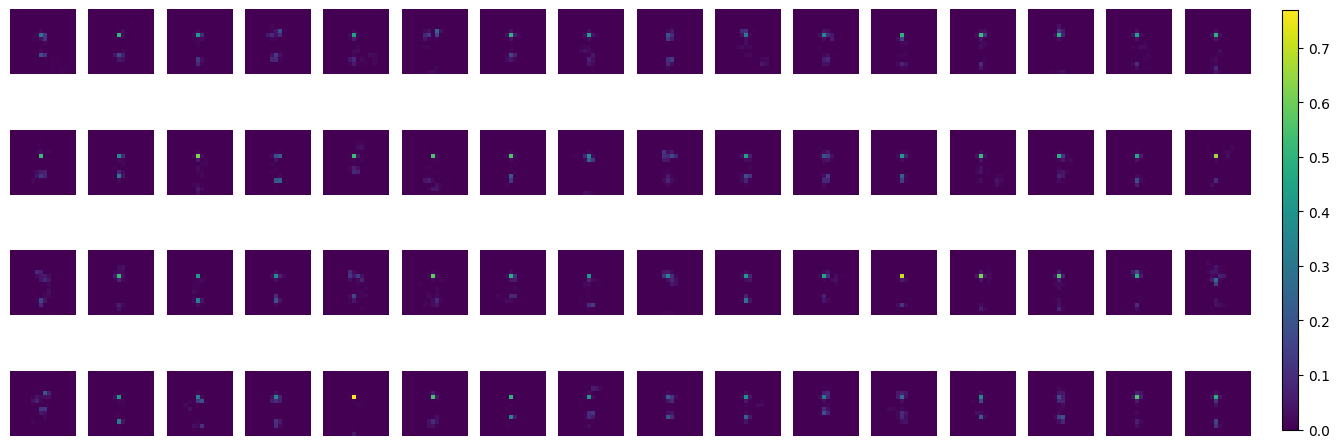

In [6]:
n_rows, n_cols = 4, 16
n_images = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows * 1.5))

vmin = dataset.images[:n_images].min()
vmax = dataset.images[:n_images].max()

# Show images and keep the first imshow object for colorbar
im = None
for i in range(n_images):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(dataset.images[i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.axis('off')

# Add a single colorbar on the right of the grid
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [21]:
test_generated_samples(generator, discriminator, dataset, kdes, batch_size=100000)

# Optional args:
#     generator,
#     discriminator,
#     dataset,
#     kdes,
#     batch_size=16,
#     latent_dim=256,
#     codings=None,
#     plot_distributions=True,
#     compare_discriminator=True

TypeError: test_generated_samples() got multiple values for argument 'batch_size'